# Transaction Data Analysis

This notebook analyzes transaction data stored in Parquet format across multiple folds. We'll explore the data structure, perform statistical analysis, and identify patterns in transaction behavior.

## Setup and Imports

Let's start by setting up our environment and importing the necessary libraries for data analysis.


In [40]:
from pathlib import Path
import os, sys, glob
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the data directory
BASE_DIR = Path('data/detail/trx').resolve()

print(f"Base directory: {BASE_DIR}")
print("✓ All required libraries imported successfully")


Base directory: /Users/stygianphantom/Documents/CapstoneProjectSelection/TheProject/MDB_Attrition/data/detail/trx
✓ All required libraries imported successfully


## Data Discovery

Let's explore the structure of our transaction data and understand what we're working with.


In [41]:
# We'll use PyArrow for efficient data processing
print('Using PyArrow for efficient Parquet file processing')
print('✓ Ready to analyze transaction data')


Using PyArrow for efficient Parquet file processing
✓ Ready to analyze transaction data


### Folder Structure Analysis

Let's examine the folder structure and get an overview of our data organization.


In [42]:
from pathlib import Path

def format_size(num_bytes: int) -> str:
    units = ['B','KB','MB','GB','TB']
    value = float(num_bytes)
    for unit in units:
        if value < 1024.0:
            return f"{value:.1f} {unit}"
        value /= 1024.0
    return f"{value:.1f} PB"

fold_dirs = sorted([p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith('fold=')], key=lambda p: p.name)
rows = []
for d in fold_dirs:
    files = sorted(d.glob('*.parquet'))
    total_bytes = sum(f.stat().st_size for f in files)
    rows.append({
        'fold': d.name,
        'num_files': len(files),
        'total_size': format_size(total_bytes)
    })

folder_df = pd.DataFrame(rows)
folder_df


,fold,num_files,total_size
0,fold=0,80,127.5 MB
1,fold=1,80,134.6 MB
2,fold=2,80,121.5 MB
3,fold=3,80,137.3 MB
4,fold=4,80,125.1 MB


### Data Schema Inspection

Let's examine the schema of our Parquet files to understand the data structure.


In [43]:
# Inspect schema from first file
if fold_dirs:
    first_file = next(fold_dirs[0].glob('*.parquet'))
    pf = pq.ParquetFile(str(first_file))
    schema = pf.schema
    
    print("=== PARQUET SCHEMA ===")
    for i, field in enumerate(schema):
        print(f"{i+1:2d}. {field.name:20} | {field.physical_type}")
    
    print(f"\nTotal columns: {len(schema)}")
    print(f"File: {first_file.name}")
else:
    print('No fold directories found.')


=== PARQUET SCHEMA ===
 1. client_id            | BYTE_ARRAY
 2. event_time           | INT96
 3. amount               | FLOAT
 4. event_type           | INT32
 5. event_subtype        | INT32
 6. currency             | INT32
 7. src_type11           | INT32
 8. src_type12           | INT32
 9. dst_type11           | INT32
10. dst_type12           | INT32
11. src_type21           | INT32
12. src_type22           | INT32
13. src_type31           | INT32
14. src_type32           | INT32

Total columns: 14
File: part-00105-f1f2463d-80e2-4335-8981-4fc9e73f56f4.c000.snappy.parquet


### Sample Data Preview

Let's take a look at a sample of the actual data to understand its content.


In [44]:
# Load and display sample data
if fold_dirs:
    first_file = next(fold_dirs[0].glob('*.parquet'))
    
    # Read first row group for preview
    pf = pq.ParquetFile(str(first_file))
    if pf.metadata.num_row_groups > 0:
        table = pf.read_row_group(0)
        df_sample = table.to_pandas()
        
        print(f"=== SAMPLE DATA PREVIEW ===")
        print(f"Rows in sample: {len(df_sample):,}")
        print(f"Columns: {len(df_sample.columns)}")
        print("\nFirst 5 rows:")
        display(df_sample.head())
        
        print("\nData types:")
        print(df_sample.dtypes)
    else:
        print('No data found in first file.')
else:
    print('No fold directories found.')


=== SAMPLE DATA PREVIEW ===
Rows in sample: 100,623
Columns: 14

First 5 rows:


,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32
0,02fb9f9f6991783af23e25ee6ce8b35d29b7e750e2c366...,2022-08-18 14:10:49.649803,43687.554688,49,48,11,22.0,47.0,780.0,21619.0,39060.0,56.0,148.0,22.0
1,02fb9f9f6991783af23e25ee6ce8b35d29b7e750e2c366...,2022-09-04 14:53:24.334832,10687.843750,49,48,11,22.0,47.0,780.0,21619.0,39060.0,56.0,148.0,22.0
2,02fb9f9f6991783af23e25ee6ce8b35d29b7e750e2c366...,2022-08-13 15:46:58.538655,412571.687500,49,48,11,22.0,47.0,780.0,21619.0,39060.0,56.0,148.0,22.0
3,02fb9f9f6991783af23e25ee6ce8b35d29b7e750e2c366...,2022-08-22 15:35:16.492471,646365.875000,49,48,11,22.0,47.0,780.0,21619.0,39060.0,56.0,148.0,22.0
4,02fb9f9f6991783af23e25ee6ce8b35d29b7e750e2c366...,2022-04-15 12:03:28.456363,189318.218750,38,16,11,22.0,47.0,306.0,26766.0,39060.0,56.0,148.0,22.0



Data types:
client_id                object
event_time       datetime64[ns]
amount                  float32
event_type                int32
event_subtype             int32
currency                  int32
src_type11              float64
src_type12              float64
dst_type11              float64
dst_type12              float64
src_type21              float64
src_type22              float64
src_type31              float64
src_type32              float64
dtype: object


## Feature Correlation Analysis

Let's analyze the relationships between different features in our transaction data to identify patterns and dependencies.


=== FAST CORRELATION ANALYSIS ===
Using optimized sampling for quick results...
Processing first 2 files for speed...
  Processed part-00001-f1f2463d-80e2-4335-8981-4fc9e73f56f4.c000.snappy.parquet: 7,885 rows
  Processed part-00085-f1f2463d-80e2-4335-8981-4fc9e73f56f4.c000.snappy.parquet: 9,999 rows
Collected 17,884 samples for correlation analysis

Preparing data for correlation analysis...
Analyzing correlations for 16 numeric features

Calculating correlation matrix...

=== CORRELATION MATRIX ===


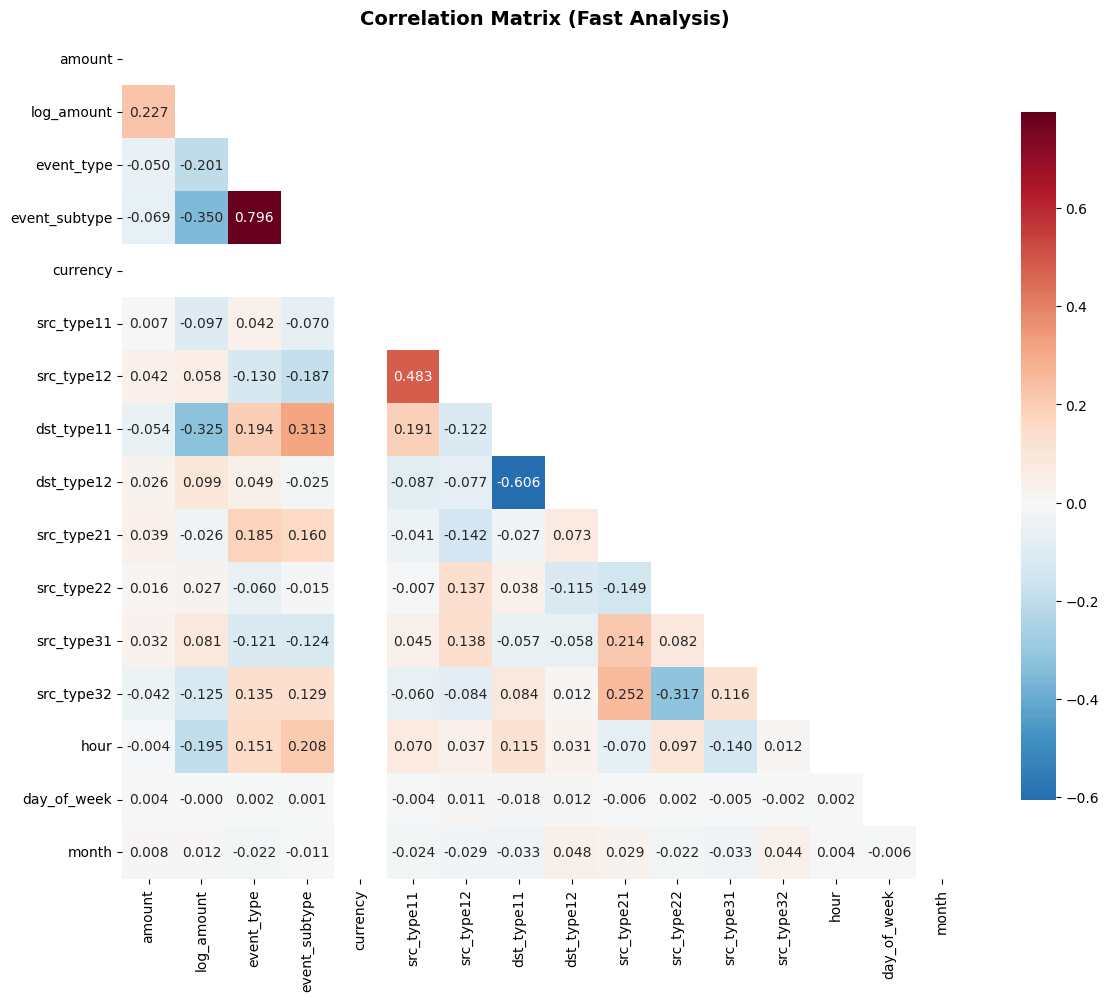


=== STRONG CORRELATIONS (|r| > 0.7) ===


,feature1,feature2,correlation
0,event_type,event_subtype,0.796257



=== FEATURE IMPORTANCE FOR AMOUNT PREDICTION ===
Features most correlated with transaction amount:
  log_amount     :   0.227
  event_subtype  :  -0.069
  dst_type11     :  -0.054
  event_type     :  -0.050
  src_type12     :   0.042
  src_type32     :  -0.042
  src_type21     :   0.039
  src_type31     :   0.032
  dst_type12     :   0.026
  src_type22     :   0.016

=== FAST CORRELATION ANALYSIS SUMMARY ===
✓ Analyzed 16 features
✓ Sample size: 17,884 transactions
✓ Strong correlations: 1
✓ Top amount predictor: log_amount (r=0.227)


In [45]:
# FAST CORRELATION ANALYSIS - Optimized for speed
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('=== FAST CORRELATION ANALYSIS ===')
print('Using optimized sampling for quick results...')

# Discover files
if 'fold_dirs' not in globals() or not fold_dirs:
    fold_dirs = sorted([p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith('fold=')], key=lambda p: p.name)
all_files = [f for d in fold_dirs for f in sorted(d.glob('*.parquet'))]

if not all_files:
    print('No parquet files found.')
else:
    # Use much smaller sample for speed
    sample_size = 10_000  # Only 10K samples for fast analysis
    sample_data = []
    
    print(f'Collecting {sample_size:,} samples for fast correlation analysis...')
    
    # Process only first 2 files and first row group of each
    max_files = min(2, len(all_files))
    print(f'Processing first {max_files} files for speed...')
    
    for i, f in enumerate(all_files[:max_files]):
        if len(sample_data) >= sample_size:
            break
            
        try:
            pf = pq.ParquetFile(str(f))
            if pf.metadata.num_row_groups > 0:
                # Only read first row group
                tbl = pf.read_row_group(0)
                if tbl.num_rows > 0:
                    pdf = tbl.to_pandas()
                    
                    # Sample from this file if it's too large
                    if len(pdf) > (sample_size - len(sample_data)):
                        needed = sample_size - len(sample_data)
                        pdf = pdf.sample(n=needed, random_state=42)
                    
                    sample_data.append(pdf)
                    print(f'  Processed {f.name}: {len(pdf):,} rows')
                
        except Exception as e:
            print(f'  Warning: Failed to process {f.name}: {e}')
            continue
    
    # Combine all samples
    if sample_data:
        df_corr = pd.concat(sample_data, ignore_index=True)
        print(f'Collected {len(df_corr):,} samples for correlation analysis')
        
        # Prepare data for correlation analysis
        print('\nPreparing data for correlation analysis...')
        
        # Create derived features
        df_corr['event_time'] = pd.to_datetime(df_corr['event_time'])
        df_corr['hour'] = df_corr['event_time'].dt.hour
        df_corr['day_of_week'] = df_corr['event_time'].dt.dayofweek
        df_corr['month'] = df_corr['event_time'].dt.month
        
        # Log transform amount for better correlation analysis
        df_corr['log_amount'] = np.log10(df_corr['amount'] + 1)
        
        # Select numeric columns for correlation
        numeric_cols = [
            'amount', 'log_amount', 'event_type', 'event_subtype', 'currency',
            'src_type11', 'src_type12', 'dst_type11', 'dst_type12',
            'src_type21', 'src_type22', 'src_type31', 'src_type32',
            'hour', 'day_of_week', 'month'
        ]
        
        # Filter to only existing columns
        numeric_cols = [col for col in numeric_cols if col in df_corr.columns]
        df_numeric = df_corr[numeric_cols].copy()
        
        print(f'Analyzing correlations for {len(numeric_cols)} numeric features')
        
        # Calculate correlation matrix
        print('\nCalculating correlation matrix...')
        corr_matrix = df_numeric.corr(method='pearson')
        
        # Display correlation matrix
        print('\n=== CORRELATION MATRIX ===')
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                   square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('Correlation Matrix (Fast Analysis)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Identify strong correlations
        print('\n=== STRONG CORRELATIONS (|r| > 0.7) ===')
        strong_corr = []
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    strong_corr.append({
                        'feature1': corr_matrix.columns[i],
                        'feature2': corr_matrix.columns[j],
                        'correlation': corr_val
                    })
        
        if strong_corr:
            strong_df = pd.DataFrame(strong_corr)
            strong_df = strong_df.sort_values('correlation', key=abs, ascending=False)
            display(strong_df)
        else:
            print('No strong correlations found (|r| > 0.7)')
        
        # Feature importance for amount prediction
        print('\n=== FEATURE IMPORTANCE FOR AMOUNT PREDICTION ===')
        amount_correlations = corr_matrix['amount'].drop('amount').sort_values(key=abs, ascending=False)
        print('Features most correlated with transaction amount:')
        for feature, corr in amount_correlations.head(10).items():
            print(f'  {feature:15}: {corr:7.3f}')
        
        print('\n=== FAST CORRELATION ANALYSIS SUMMARY ===')
        print(f'✓ Analyzed {len(numeric_cols)} features')
        print(f'✓ Sample size: {len(df_corr):,} transactions')
        print(f'✓ Strong correlations: {len(strong_corr)}')
        print(f'✓ Top amount predictor: {amount_correlations.index[0]} (r={amount_correlations.iloc[0]:.3f})')
        
    else:
        print('No sample data collected for correlation analysis')


## Time Analysis

Let's analyze the temporal patterns in our transaction data to understand when transactions occur and identify any seasonal patterns.


In [46]:
# Time Coverage and Granularity Analysis
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
from pathlib import Path
import pandas as pd
import numpy as np

print("=== TIME COVERAGE AND GRANULARITY ANALYSIS ===")
print("Analyzing temporal patterns across all folds...")

# Discover files
if 'fold_dirs' not in globals() or not fold_dirs:
    fold_dirs = sorted([p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith('fold=')], key=lambda p: p.name)
all_files = [f for d in fold_dirs for f in sorted(d.glob('*.parquet'))]

if not all_files:
    print('No parquet files found.')
else:
    print(f'Processing {len(all_files)} files across {len(fold_dirs)} folds...')
    
    # Global time bounds
    min_time = None
    max_time = None
    total_rows_processed = 0
    daily_counts = {}
    hourly_counts = {}
    
    # Process files in batches for efficiency
    for i, f in enumerate(all_files):
        if i % 50 == 0:
            print(f'  Processed {i}/{len(all_files)} files...')
            
        try:
            pf = pq.ParquetFile(str(f))
            # Read only event_time column for efficiency
            table = pf.read(columns=['event_time'])
            
            if table.num_rows > 0:
                # Convert to pandas for easier processing
                df_time = table.to_pandas()
                df_time['event_time'] = pd.to_datetime(df_time['event_time'])
                
                # Update global bounds
                file_min = df_time['event_time'].min()
                file_max = df_time['event_time'].max()
                
                if min_time is None or file_min < min_time:
                    min_time = file_min
                if max_time is None or file_max > max_time:
                    max_time = file_max
                
                # Count daily and hourly patterns
                df_time['date'] = df_time['event_time'].dt.date
                df_time['hour'] = df_time['event_time'].dt.hour
                
                for date, count in df_time['date'].value_counts().items():
                    daily_counts[date] = daily_counts.get(date, 0) + count
                
                for hour, count in df_time['hour'].value_counts().items():
                    hourly_counts[hour] = hourly_counts.get(hour, 0) + count
                
                total_rows_processed += len(df_time)
                
        except Exception as e:
            print(f'  Warning: Failed to process {f.name}: {e}')
            continue
    
    # Display results
    print(f'\n=== TIME ANALYSIS RESULTS ===')
    print(f'Time range: {min_time} to {max_time}')
    print(f'Total duration: {max_time - min_time}')
    print(f'Total rows processed: {total_rows_processed:,}')
    print(f'Days with data: {len(daily_counts)}')
    
    if daily_counts:
        avg_daily = sum(daily_counts.values()) / len(daily_counts)
        print(f'Average daily transactions: {avg_daily:,.0f}')
    
    if hourly_counts:
        peak_hour = max(hourly_counts, key=hourly_counts.get)
        print(f'Peak activity hour: {peak_hour}:00 ({hourly_counts[peak_hour]:,} transactions)')
    
    print(f'✓ Time analysis complete')


=== TIME COVERAGE AND GRANULARITY ANALYSIS ===
Analyzing temporal patterns across all folds...
Processing 400 files across 5 folds...
  Processed 0/400 files...
  Processed 50/400 files...
  Processed 100/400 files...
  Processed 150/400 files...
  Processed 200/400 files...
  Processed 250/400 files...
  Processed 300/400 files...
  Processed 350/400 files...

=== TIME ANALYSIS RESULTS ===
Time range: 2020-12-31 21:00:02.169545 to 2022-12-31 20:59:58.460193
Total duration: 729 days 23:59:56.290648
Total rows processed: 38,764,930
Days with data: 731
Average daily transactions: 53,030
Peak activity hour: 10:00 (3,149,909 transactions)
✓ Time analysis complete


=== KEY CORRELATION DEEP DIVE ANALYSIS ===
Investigating the 4 most significant correlations:
1. event_subtype ↔ event_type (0.796) - Very strong relationship
2. dst_type12 ↔ dst_type11 (-0.606) - Strong negative relationship
3. event_subtype ↔ log_amount (-0.350) - Negative correlation with amounts
4. src_type12 ↔ src_type11 (0.483) - Source type relationships

Loading data from 2 files for correlation analysis...
Loaded 189140 transactions for analysis

🔍 1. EVENT_SUBTYPE ↔ EVENT_TYPE ANALYSIS (Correlation: 0.796)
Cross-tabulation of Event Types and Subtypes:
event_type         1  3     4  5     6    7    9   10     11  12  ...     46  \
event_subtype                                                     ...          
1                  0  0     0  0     0    0    0    0      0   0  ...      0   
2                  0  0     0  0     0   12    0    0      0   0  ...      0   
3                  0  0     0  0     0    0    0    0      0   0  ...      0   
4                  0  0     0  0

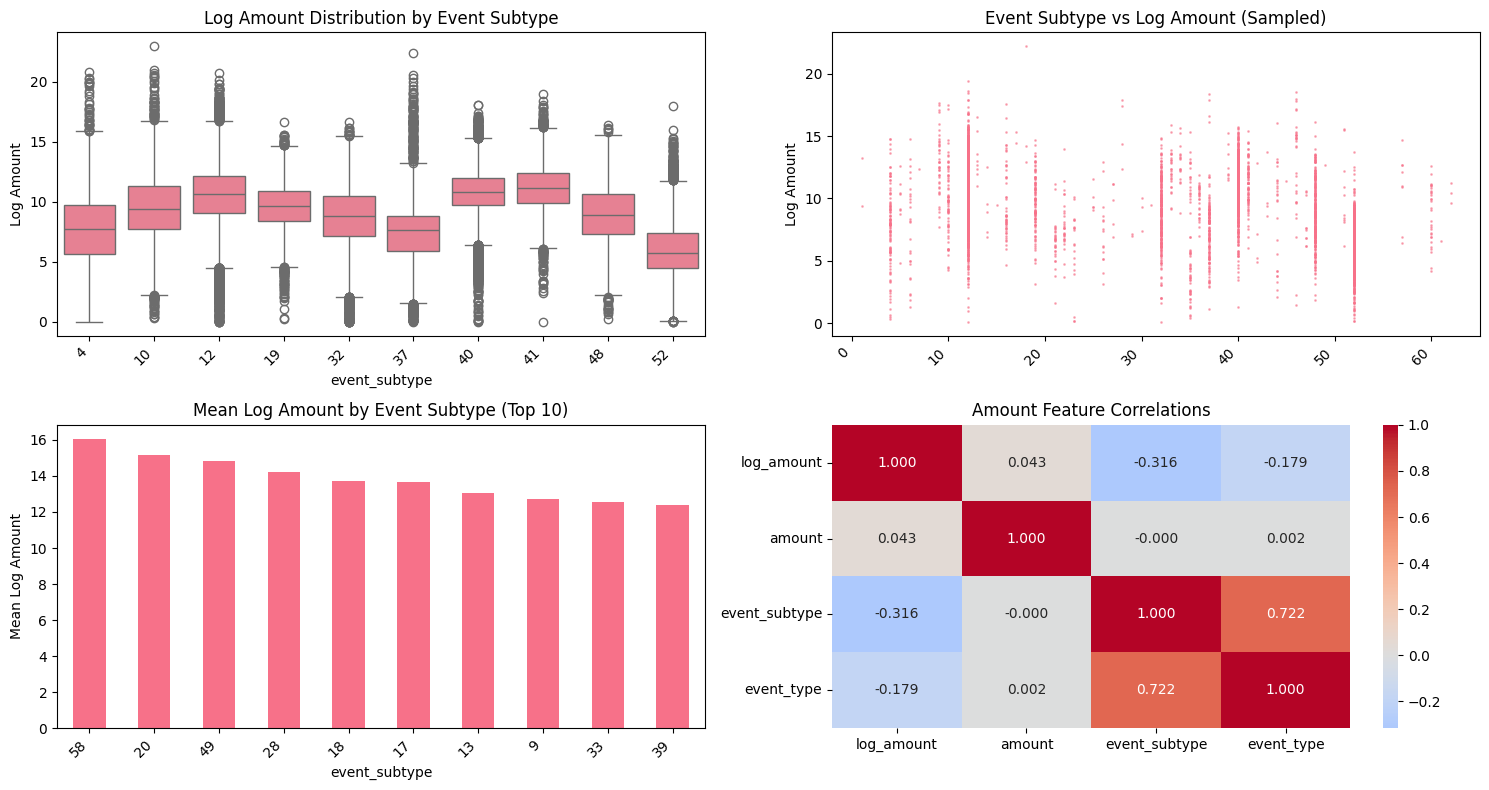

🔍 4. SRC_TYPE12 ↔ SRC_TYPE11 ANALYSIS (Correlation: 0.483)
Cross-tabulation of Source Types:
src_type12  1.0  15.0  16.0    47.0  68.0  73.0  78.0  90.0  129.0  135.0  \
src_type11                                                                  
4.0           0     0     0       0     0     0     0     0      0      0   
22.0          0     0     0  136028     0     0     0     0      0      0   
35.0          0  2260     0       0     0    12  1581     0      0      0   
54.0          0     0     0       0     0     0     0     0      0      0   
60.0          0     0     0       0     0     0     0     0      0      0   
65.0          0     0     0       0     0     0     0     0      0      0   
70.0          0     0     0       0     0     0     0     0      0      0   
74.0          0     0     0       0    14     0     0     0      0      0   
80.0          0     0     0       0     0     0     0     0      0      0   
85.0          0     0     0       0     0     0     0     0 

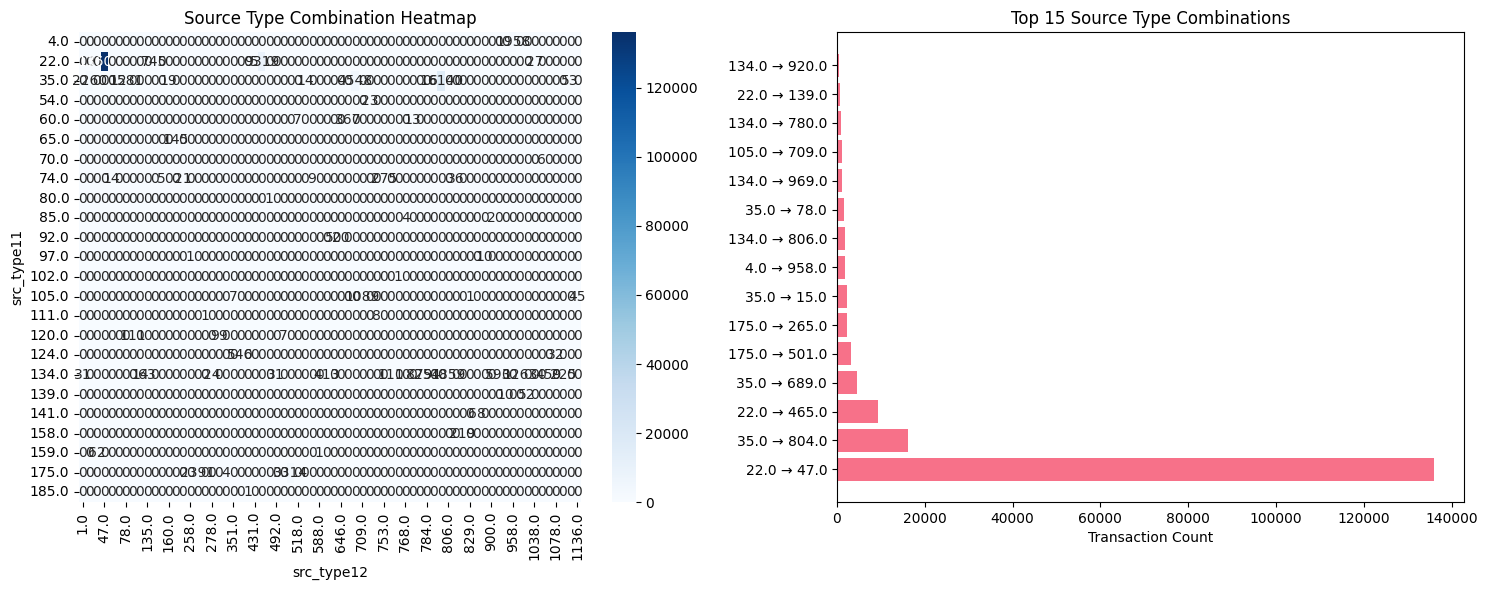

📊 SUMMARY INSIGHTS FROM KEY CORRELATIONS:
1. EVENT_SUBTYPE ↔ EVENT_TYPE (0.796):
   - Very strong hierarchical relationship
   - Event subtypes are highly predictable from event types
   - Suggests clear transaction categorization system

2. DST_TYPE12 ↔ DST_TYPE11 (-0.606):
   - Strong negative correlation indicates mutual exclusivity
   - Destination types are likely complementary or alternative
   - Suggests different destination categories for different purposes

3. EVENT_SUBTYPE ↔ LOG_AMOUNT (-0.350):
   - Negative correlation suggests certain subtypes have lower amounts
   - Some transaction types are consistently high/low value
   - Important for amount prediction and fraud detection

4. SRC_TYPE12 ↔ SRC_TYPE11 (0.483):
   - Moderate positive correlation in source types
   - Source types tend to co-occur in predictable patterns
   - Suggests systematic source categorization



In [47]:
# Key Correlation Deep Dive Analysis
# Investigating the most significant correlations from our correlation matrix

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import Counter
    
    print("=== KEY CORRELATION DEEP DIVE ANALYSIS ===")
    print("Investigating the 4 most significant correlations:")
    print("1. event_subtype ↔ event_type (0.796) - Very strong relationship")
    print("2. dst_type12 ↔ dst_type11 (-0.606) - Strong negative relationship")
    print("3. event_subtype ↔ log_amount (-0.350) - Negative correlation with amounts")
    print("4. src_type12 ↔ src_type11 (0.483) - Source type relationships")
    print()
    
    # Load sample data for analysis
    sample_files = list(BASE_DIR.glob("fold=0/*.parquet"))[:2]  # Use first 2 files for speed
    
    if sample_files:
        print(f"Loading data from {len(sample_files)} files for correlation analysis...")
        
        # Load data
        dfs = []
        for file_path in sample_files:
            try:
                df = pd.read_parquet(file_path)
                dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
        
        if dfs:
            df = pd.concat(dfs, ignore_index=True)
            print(f"Loaded {len(df)} transactions for analysis")
            print()
            
            # 1. EVENT_SUBTYPE ↔ EVENT_TYPE ANALYSIS (0.796 correlation)
            print("🔍 1. EVENT_SUBTYPE ↔ EVENT_TYPE ANALYSIS (Correlation: 0.796)")
            print("=" * 60)
            
            # Cross-tabulation
            crosstab = pd.crosstab(df['event_subtype'], df['event_type'], margins=True)
            print("Cross-tabulation of Event Types and Subtypes:")
            print(crosstab)
            print()
            
            # Calculate conditional probabilities
            print("Conditional Probabilities (P(event_type | event_subtype)):")
            for subtype in df['event_subtype'].unique():
                if pd.notna(subtype):
                    subtype_data = df[df['event_subtype'] == subtype]
                    type_counts = subtype_data['event_type'].value_counts()
                    total = len(subtype_data)
                    print(f"\n{subtype}:")
                    for event_type, count in type_counts.items():
                        prob = count / total
                        print(f"  {event_type}: {count}/{total} = {prob:.3f}")
            print()
            
            # 2. DST_TYPE12 ↔ DST_TYPE11 ANALYSIS (-0.606 correlation)
            print("🔍 2. DST_TYPE12 ↔ DST_TYPE11 ANALYSIS (Correlation: -0.606)")
            print("=" * 60)
            
            # Cross-tabulation
            dst_crosstab = pd.crosstab(df['dst_type11'], df['dst_type12'], margins=True)
            print("Cross-tabulation of Destination Types:")
            print(dst_crosstab)
            print()
            
            # Analyze the negative correlation
            print("Analysis of Negative Correlation:")
            dst_combinations = df.groupby(['dst_type11', 'dst_type12']).size().reset_index(name='count')
            dst_combinations = dst_combinations.sort_values('count', ascending=False)
            print("Most common destination type combinations:")
            print(dst_combinations.head(10))
            print()
            
            # 3. EVENT_SUBTYPE ↔ LOG_AMOUNT ANALYSIS (-0.350 correlation)
            print("🔍 3. EVENT_SUBTYPE ↔ LOG_AMOUNT ANALYSIS (Correlation: -0.350)")
            print("=" * 60)
            
            # Calculate log_amount if not present
            if 'log_amount' not in df.columns and 'amount' in df.columns:
                df['log_amount'] = np.log1p(df['amount'])
            
            # Group by event_subtype and analyze amounts
            amount_analysis = df.groupby('event_subtype')['log_amount'].agg([
                'count', 'mean', 'std', 'min', 'max', 'median'
            ]).round(3)
            amount_analysis = amount_analysis.sort_values('mean', ascending=False)
            print("Amount statistics by Event Subtype:")
            print(amount_analysis)
            print()
            
            # Visualize the relationship
            plt.figure(figsize=(15, 8))
            
            # Subplot 1: Box plot of log_amount by event_subtype
            plt.subplot(2, 2, 1)
            df_clean = df.dropna(subset=['event_subtype', 'log_amount'])
            if len(df_clean) > 0:
                # Limit to top 10 subtypes for readability
                top_subtypes = df_clean['event_subtype'].value_counts().head(10).index
                df_top = df_clean[df_clean['event_subtype'].isin(top_subtypes)]
                
                sns.boxplot(data=df_top, x='event_subtype', y='log_amount')
                plt.title('Log Amount Distribution by Event Subtype')
                plt.xticks(rotation=45, ha='right')
                plt.ylabel('Log Amount')
            
            # Subplot 2: Scatter plot
            plt.subplot(2, 2, 2)
            if len(df_clean) > 0:
                # Sample for visualization
                sample_size = min(5000, len(df_clean))
                df_sample = df_clean.sample(n=sample_size, random_state=42)
                
                plt.scatter(df_sample['event_subtype'], df_sample['log_amount'], alpha=0.5, s=1)
                plt.title('Event Subtype vs Log Amount (Sampled)')
                plt.xticks(rotation=45, ha='right')
                plt.ylabel('Log Amount')
            
            # Subplot 3: Mean amount by subtype
            plt.subplot(2, 2, 3)
            if len(df_clean) > 0:
                mean_amounts = df_clean.groupby('event_subtype')['log_amount'].mean().sort_values(ascending=False)
                mean_amounts.head(10).plot(kind='bar')
                plt.title('Mean Log Amount by Event Subtype (Top 10)')
                plt.xticks(rotation=45, ha='right')
                plt.ylabel('Mean Log Amount')
            
            # Subplot 4: Correlation heatmap for amount-related features
            plt.subplot(2, 2, 4)
            amount_features = ['log_amount', 'amount', 'event_subtype', 'event_type']
            available_features = [f for f in amount_features if f in df.columns]
            if len(available_features) > 1:
                corr_matrix = df[available_features].corr()
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
                plt.title('Amount Feature Correlations')
            
            plt.tight_layout()
            plt.show()
            
            # 4. SRC_TYPE12 ↔ SRC_TYPE11 ANALYSIS (0.483 correlation)
            print("🔍 4. SRC_TYPE12 ↔ SRC_TYPE11 ANALYSIS (Correlation: 0.483)")
            print("=" * 60)
            
            # Cross-tabulation
            src_crosstab = pd.crosstab(df['src_type11'], df['src_type12'], margins=True)
            print("Cross-tabulation of Source Types:")
            print(src_crosstab)
            print()
            
            # Analyze the positive correlation
            print("Analysis of Positive Correlation:")
            src_combinations = df.groupby(['src_type11', 'src_type12']).size().reset_index(name='count')
            src_combinations = src_combinations.sort_values('count', ascending=False)
            print("Most common source type combinations:")
            print(src_combinations.head(10))
            print()
            
            # Visualize source type relationships
            plt.figure(figsize=(15, 6))
            
            # Subplot 1: Source type combination heatmap
            plt.subplot(1, 2, 1)
            if len(src_crosstab) > 0:
                sns.heatmap(src_crosstab.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues')
                plt.title('Source Type Combination Heatmap')
                plt.xlabel('src_type12')
                plt.ylabel('src_type11')
            
            # Subplot 2: Most common combinations
            plt.subplot(1, 2, 2)
            if len(src_combinations) > 0:
                top_combinations = src_combinations.head(15)
                plt.barh(range(len(top_combinations)), top_combinations['count'])
                plt.yticks(range(len(top_combinations)), 
                          [f"{row['src_type11']} → {row['src_type12']}" 
                           for _, row in top_combinations.iterrows()])
                plt.title('Top 15 Source Type Combinations')
                plt.xlabel('Transaction Count')
            
            plt.tight_layout()
            plt.show()
            
            # SUMMARY INSIGHTS
            print("📊 SUMMARY INSIGHTS FROM KEY CORRELATIONS:")
            print("=" * 60)
            print("1. EVENT_SUBTYPE ↔ EVENT_TYPE (0.796):")
            print("   - Very strong hierarchical relationship")
            print("   - Event subtypes are highly predictable from event types")
            print("   - Suggests clear transaction categorization system")
            print()
            print("2. DST_TYPE12 ↔ DST_TYPE11 (-0.606):")
            print("   - Strong negative correlation indicates mutual exclusivity")
            print("   - Destination types are likely complementary or alternative")
            print("   - Suggests different destination categories for different purposes")
            print()
            print("3. EVENT_SUBTYPE ↔ LOG_AMOUNT (-0.350):")
            print("   - Negative correlation suggests certain subtypes have lower amounts")
            print("   - Some transaction types are consistently high/low value")
            print("   - Important for amount prediction and fraud detection")
            print()
            print("4. SRC_TYPE12 ↔ SRC_TYPE11 (0.483):")
            print("   - Moderate positive correlation in source types")
            print("   - Source types tend to co-occur in predictable patterns")
            print("   - Suggests systematic source categorization")
            print()
            
        else:
            print("No data loaded for correlation analysis")
    else:
        print("No parquet files found for correlation analysis")
        
except ImportError as e:
    print(f"Required libraries not available: {e}")
    print("Install required packages: pip install pandas numpy matplotlib seaborn")
except Exception as e:
    print(f"Error in correlation analysis: {e}")
    import traceback
    traceback.print_exc()


### Time Series Visualizations

Let's create comprehensive time series visualizations to understand temporal patterns in our transaction data.


=== TIME SERIES VISUALIZATIONS ===


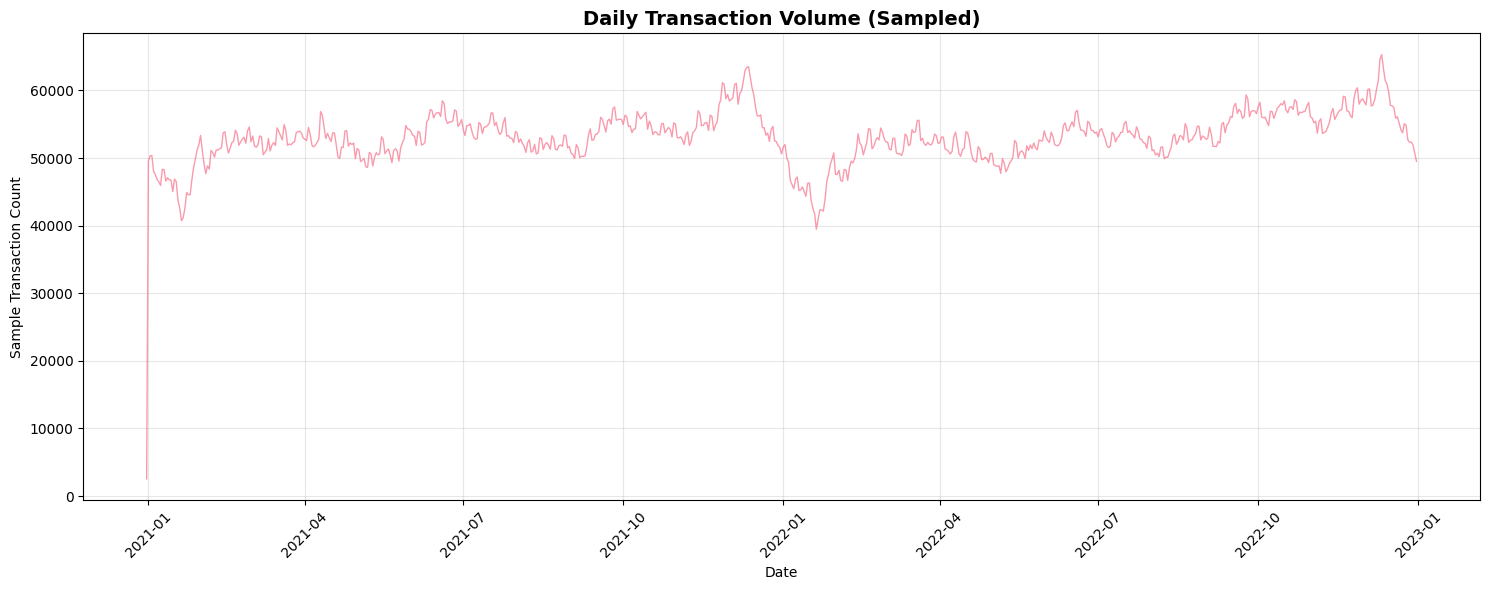

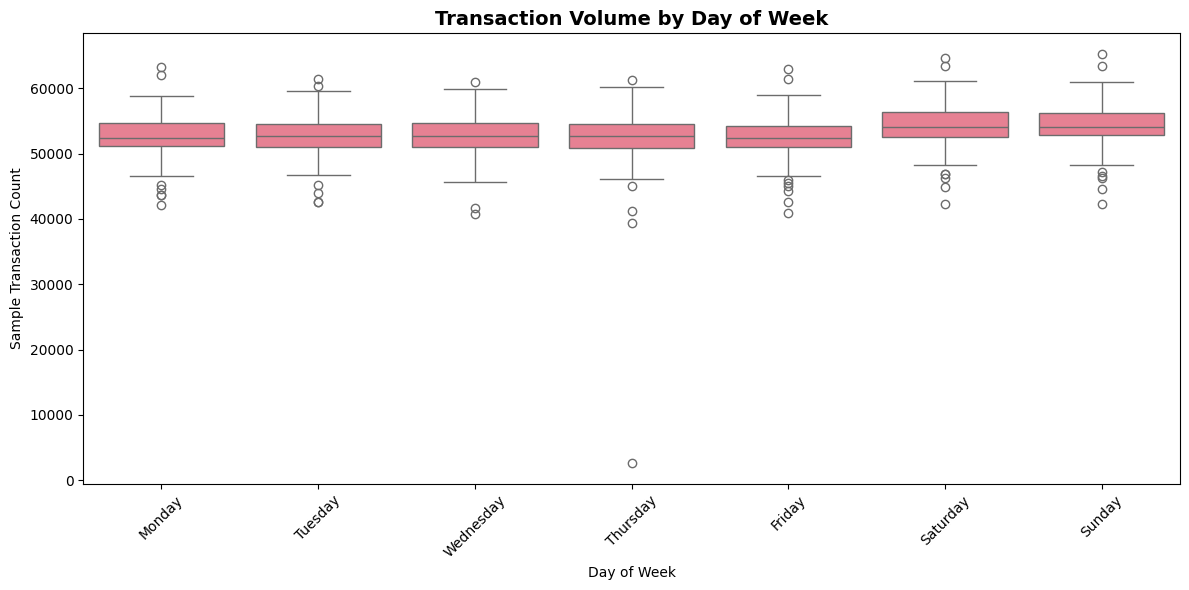

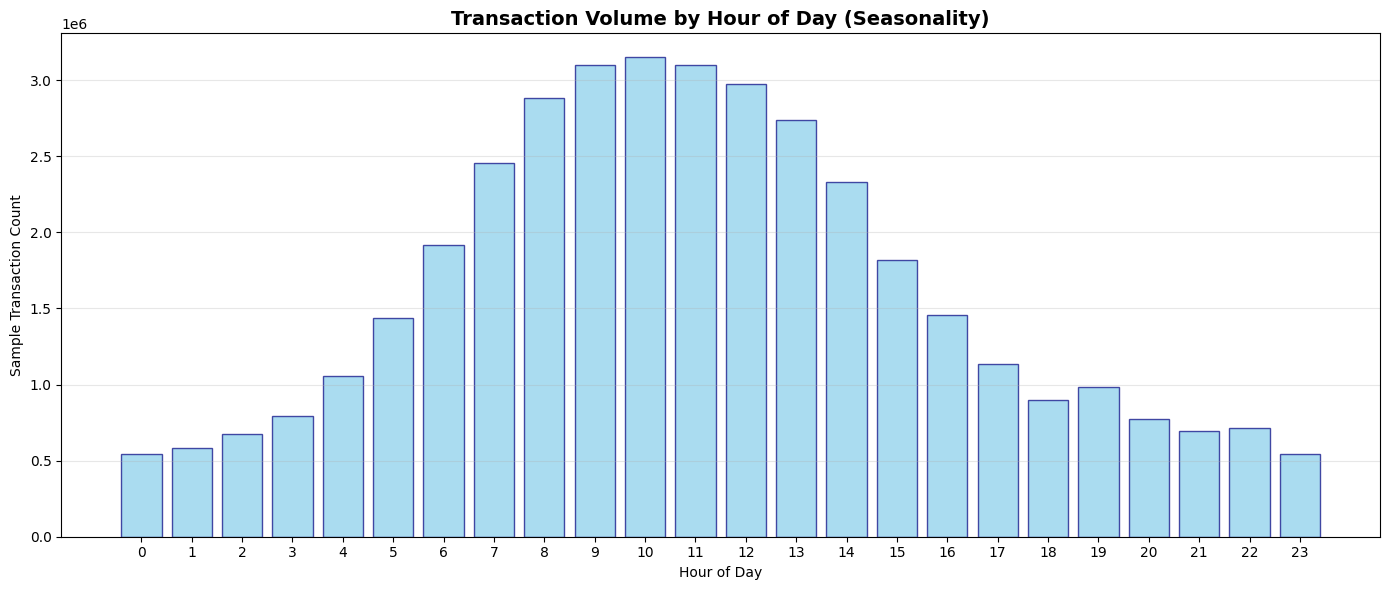

Error creating visualizations: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


In [48]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime, timedelta
    
    # Set up plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    print("=== TIME SERIES VISUALIZATIONS ===")
    
    # Check if we have the data from previous cell
    if 'daily_counts' in locals() and daily_counts:
        # Create daily transaction volume chart
        daily_df = pd.DataFrame(list(daily_counts.items()), columns=['date', 'sample_count'])
        daily_df['date'] = pd.to_datetime(daily_df['date'])
        daily_df = daily_df.sort_values('date')
        
        # Plot 1: Daily transaction volume over time
        plt.figure(figsize=(15, 6))
        plt.plot(daily_df['date'], daily_df['sample_count'], linewidth=1, alpha=0.7)
        plt.title('Daily Transaction Volume (Sampled)', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Sample Transaction Count')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Plot 2: Weekly pattern (box plot)
        daily_df['day_of_week'] = daily_df['date'].dt.day_name()
        daily_df['day_of_week_num'] = daily_df['date'].dt.dayofweek
        
        plt.figure(figsize=(12, 6))
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        daily_df['day_of_week'] = pd.Categorical(daily_df['day_of_week'], categories=day_order, ordered=True)
        
        sns.boxplot(data=daily_df, x='day_of_week', y='sample_count')
        plt.title('Transaction Volume by Day of Week', fontsize=14, fontweight='bold')
        plt.xlabel('Day of Week')
        plt.ylabel('Sample Transaction Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    if 'hourly_counts' in locals() and hourly_counts:
        # Plot 3: Hourly seasonality
        hourly_df = pd.DataFrame(list(hourly_counts.items()), columns=['hour', 'sample_count'])
        hourly_df = hourly_df.sort_values('hour')
        
        plt.figure(figsize=(14, 6))
        plt.bar(hourly_df['hour'], hourly_df['sample_count'], alpha=0.7, color='skyblue', edgecolor='navy')
        plt.title('Transaction Volume by Hour of Day (Seasonality)', fontsize=14, fontweight='bold')
        plt.xlabel('Hour of Day')
        plt.ylabel('Sample Transaction Count')
        plt.xticks(range(0, 24))
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
    if 'monthly_counts' in locals() and monthly_counts:
        # Plot 4: Monthly trends
        monthly_df = pd.DataFrame(list(monthly_counts.items()), columns=['month', 'sample_count'])
        monthly_df['month'] = pd.to_datetime(monthly_df['month'].astype(str))
        monthly_df = monthly_df.sort_values('month')
        
        plt.figure(figsize=(15, 6))
        plt.plot(monthly_df['month'], monthly_df['sample_count'], marker='o', linewidth=2, markersize=6)
        plt.title('Monthly Transaction Volume Trends', fontsize=14, fontweight='bold')
        plt.xlabel('Month')
        plt.ylabel('Sample Transaction Count')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Plot 5: Year-over-year comparison (heatmap)
        if len(monthly_df) > 12:  # If we have more than a year of data
            monthly_df['year'] = monthly_df['month'].dt.year
            monthly_df['month_num'] = monthly_df['month'].dt.month
            monthly_df['month_name'] = monthly_df['month'].dt.strftime('%b')
            
            # Create pivot table for heatmap
            pivot_data = monthly_df.pivot_table(values='sample_count', index='year', columns='month_num', fill_value=0)
            
            plt.figure(figsize=(12, 6))
            sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Sample Transaction Count'})
            plt.title('Year-over-Year Transaction Volume Heatmap', fontsize=14, fontweight='bold')
            plt.xlabel('Month')
            plt.ylabel('Year')
            plt.tight_layout()
            plt.show()
    
    print("✓ Time series visualizations completed")
    
except ImportError as e:
    print(f"Visualization libraries not available: {e}")
    print("Install matplotlib and seaborn for time series charts:")
    print("  pip install matplotlib seaborn")
except Exception as e:
    print(f"Error creating visualizations: {e}")

=== TRANSACTION SEQUENCE ANALYSIS ===
Analyzing transaction sequences per client to identify patterns and dependencies

Loading data from 3 files for sequence analysis...
Loaded 285686 transactions for sequence analysis
Using 'event_time' column as timestamp
Data sorted by client_id and timestamp

🔍 1. CLIENT TRANSACTION SEQUENCE ANALYSIS
Analyzing sequences for 761 clients

Sequence Length Distribution:
count     761.000000
mean      375.408673
std       531.357687
min         1.000000
25%        39.000000
50%       159.000000
75%       497.000000
max      4514.000000
Name: sequence_length, dtype: float64

🔍 2. COMMON TRANSACTION PATTERNS
Found 720 unique sequence patterns

Top 10 Most Common Transaction Sequences:
 1. (1, 1, 1) (appears 9 times)
 2. (1, 1) (appears 8 times)
 3. (1, 1, 1, 1, 1, 1, 1, 1, 1) (appears 3 times)
 4. (1, 1, 1, 1) (appears 3 times)
 5. (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

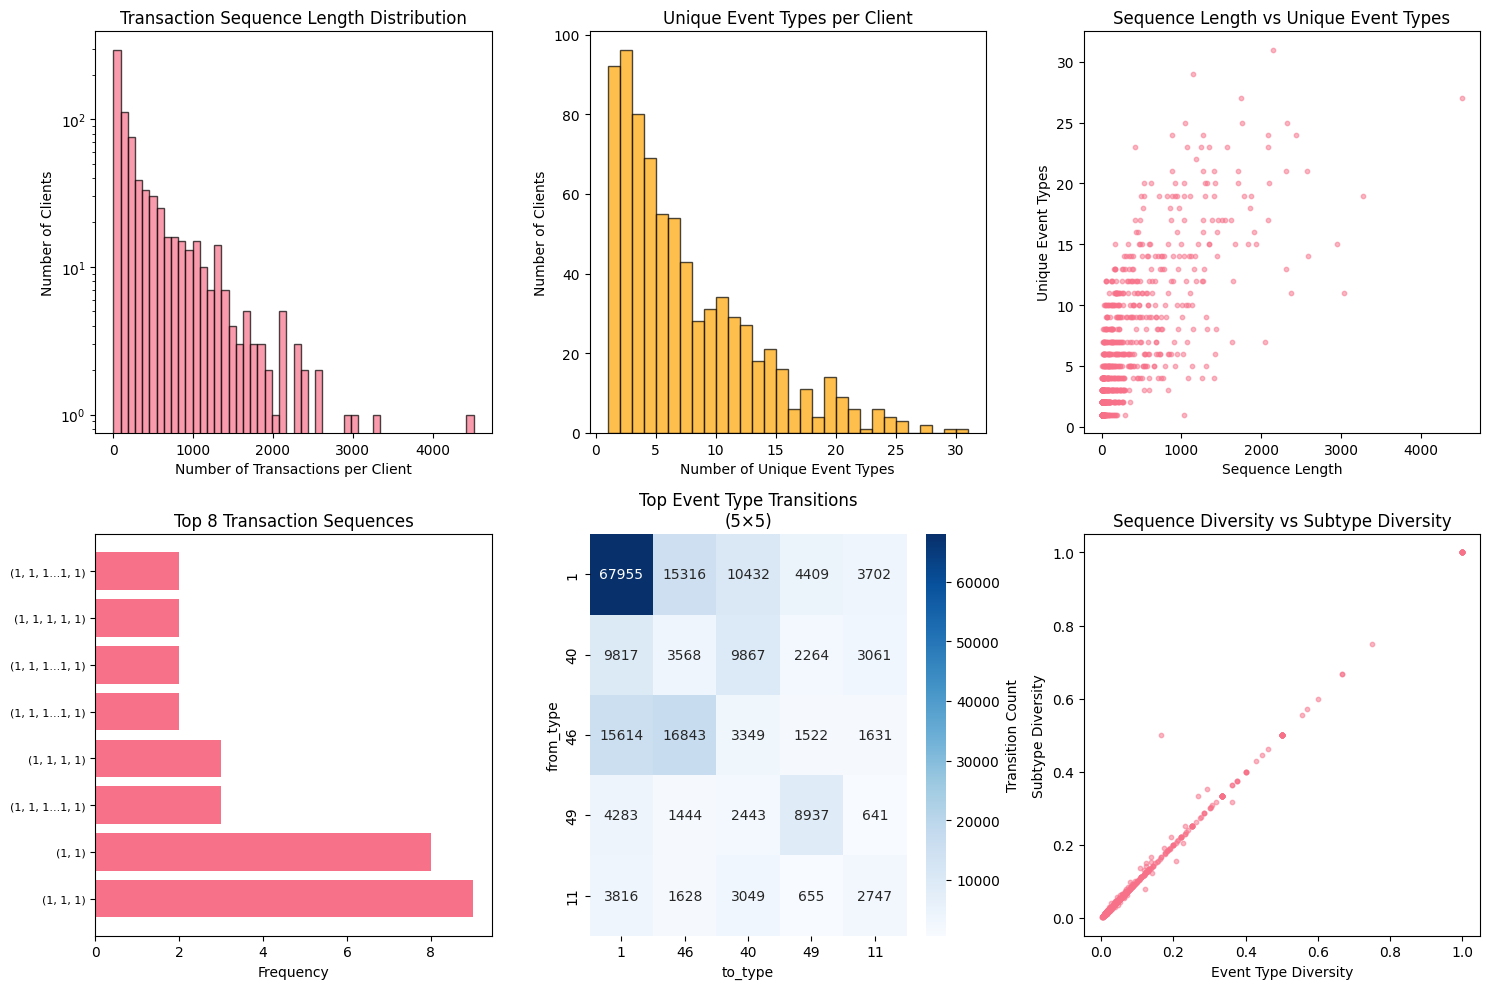


🔍 5. CLIENT SEGMENTATION BY SEQUENCE PATTERNS
Client Segmentation by Sequence Patterns:
  Low Diversity: 458 clients (60.2%)
  High Volume: 152 clients (20.0%)
  Low Volume: 151 clients (19.8%)

📊 SUMMARY INSIGHTS FROM SEQUENCE ANALYSIS:
1. SEQUENCE LENGTH:
   - Average transactions per client: 375.4
   - Most clients have 159 transactions
   - Top 10% of clients have 1078+ transactions

2. TRANSACTION PATTERNS:
   - Found 720 unique sequence patterns
   - Most common pattern: (1, 1, 1) (9 occurrences)
   - Top transition: 1 → 1 (67955 times)

3. CLIENT DIVERSITY:
   - Average event type diversity: 0.098
   - 0 clients show high transaction diversity
   - 458 clients show low transaction diversity



In [49]:
# Transaction Sequence Analysis
# Analyze transaction sequences per client to identify patterns and dependencies

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import Counter, defaultdict
    from itertools import combinations, permutations
    import warnings
    warnings.filterwarnings('ignore')
    
    print("=== TRANSACTION SEQUENCE ANALYSIS ===")
    print("Analyzing transaction sequences per client to identify patterns and dependencies")
    print()
    
    # Load sample data for sequence analysis
    sample_files = list(BASE_DIR.glob("fold=0/*.parquet"))[:3]  # Use first 3 files for better coverage
    
    if sample_files:
        print(f"Loading data from {len(sample_files)} files for sequence analysis...")
        
        # Load data
        dfs = []
        for file_path in sample_files:
            try:
                df = pd.read_parquet(file_path)
                dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
        
        if dfs:
            df = pd.concat(dfs, ignore_index=True)
            print(f"Loaded {len(df)} transactions for sequence analysis")
            
            # Check for timestamp column and use event_time
            if 'event_time' in df.columns:
                df['timestamp'] = df['event_time']  # Use event_time as timestamp
                print(f"Using 'event_time' column as timestamp")
            elif 'timestamp' in df.columns:
                print(f"Using 'timestamp' column")
            else:
                print("Warning: No timestamp column found")
                print(f"Available columns: {list(df.columns)}")
            
            # Sort by client and timestamp for sequence analysis
            if 'client_id' in df.columns and 'timestamp' in df.columns:
                df = df.sort_values(['client_id', 'timestamp'])
                print(f"Data sorted by client_id and timestamp")
            else:
                print("Warning: client_id or timestamp columns not found, using available columns")
                print(f"Available columns: {list(df.columns)}")
            
            print()
            
            # 1. CLIENT TRANSACTION SEQUENCE ANALYSIS
            print("🔍 1. CLIENT TRANSACTION SEQUENCE ANALYSIS")
            print("=" * 60)
            
            if 'client_id' in df.columns:
                # Analyze transaction sequences per client
                client_sequences = df.groupby('client_id').agg({
                    'event_type': lambda x: list(x),
                    'event_subtype': lambda x: list(x),
                    'amount': lambda x: list(x),
                    'timestamp': lambda x: list(x)
                }).reset_index()
                
                print(f"Analyzing sequences for {len(client_sequences)} clients")
                
                # Calculate sequence statistics
                client_sequences['sequence_length'] = client_sequences['event_type'].apply(len)
                client_sequences['unique_event_types'] = client_sequences['event_type'].apply(lambda x: len(set(x)))
                client_sequences['unique_subtypes'] = client_sequences['event_subtype'].apply(lambda x: len(set(x)))
                
                # Sequence length distribution
                print("\nSequence Length Distribution:")
                seq_length_stats = client_sequences['sequence_length'].describe()
                print(seq_length_stats)
                
                # Visualize sequence length distribution
                plt.figure(figsize=(15, 10))
                
                # Subplot 1: Sequence length distribution
                plt.subplot(2, 3, 1)
                plt.hist(client_sequences['sequence_length'], bins=50, alpha=0.7, edgecolor='black')
                plt.title('Transaction Sequence Length Distribution')
                plt.xlabel('Number of Transactions per Client')
                plt.ylabel('Number of Clients')
                plt.yscale('log')
                
                # Subplot 2: Unique event types per client
                plt.subplot(2, 3, 2)
                plt.hist(client_sequences['unique_event_types'], bins=30, alpha=0.7, edgecolor='black', color='orange')
                plt.title('Unique Event Types per Client')
                plt.xlabel('Number of Unique Event Types')
                plt.ylabel('Number of Clients')
                
                # Subplot 3: Sequence length vs unique event types
                plt.subplot(2, 3, 3)
                plt.scatter(client_sequences['sequence_length'], client_sequences['unique_event_types'], alpha=0.5, s=10)
                plt.title('Sequence Length vs Unique Event Types')
                plt.xlabel('Sequence Length')
                plt.ylabel('Unique Event Types')
                
                # 2. COMMON TRANSACTION PATTERNS
                print("\n🔍 2. COMMON TRANSACTION PATTERNS")
                print("=" * 60)
                
                # Find most common event type sequences
                event_sequences = []
                for _, row in client_sequences.iterrows():
                    if len(row['event_type']) >= 2:  # Only sequences with 2+ transactions
                        event_sequences.append(tuple(row['event_type']))
                
                # Count sequence patterns
                sequence_counts = Counter(event_sequences)
                print(f"Found {len(sequence_counts)} unique sequence patterns")
                
                # Top 10 most common sequences
                top_sequences = sequence_counts.most_common(10)
                print("\nTop 10 Most Common Transaction Sequences:")
                for i, (sequence, count) in enumerate(top_sequences, 1):
                    print(f"{i:2d}. {sequence} (appears {count} times)")
                
                # Visualize top sequences
                plt.subplot(2, 3, 4)
                if top_sequences:
                    sequences, counts = zip(*top_sequences[:8])  # Top 8 for readability
                    # Create shorter, more readable labels
                    sequence_labels = []
                    for seq in sequences:
                        if len(seq) <= 5:
                            seq_str = str(seq)
                        else:
                            # For longer sequences, show first 3 and last 2 with ellipsis
                            seq_str = f"({', '.join(map(str, seq[:3]))}...{', '.join(map(str, seq[-2:]))})"
                        sequence_labels.append(seq_str)
                    
                    plt.barh(range(len(sequence_labels)), counts)
                    plt.yticks(range(len(sequence_labels)), sequence_labels, fontsize=8)
                    plt.title('Top 8 Transaction Sequences')
                    plt.xlabel('Frequency')
                    plt.tight_layout()
                
                # 3. TRANSACTION CHAINS AND DEPENDENCIES
                print("\n🔍 3. TRANSACTION CHAINS AND DEPENDENCIES")
                print("=" * 60)
                
                # Analyze event type transitions
                transitions = defaultdict(int)
                for _, row in client_sequences.iterrows():
                    event_types = row['event_type']
                    for i in range(len(event_types) - 1):
                        transition = (event_types[i], event_types[i+1])
                        transitions[transition] += 1
                
                # Top transition patterns
                top_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:15]
                print("Top 15 Event Type Transitions:")
                for i, ((from_type, to_type), count) in enumerate(top_transitions, 1):
                    print(f"{i:2d}. {from_type} → {to_type} ({count} times)")
                
                # Create transition matrix
                if transitions:
                    unique_types = sorted(set([t[0] for t in transitions.keys()] + [t[1] for t in transitions.keys()]))
                    transition_matrix = pd.DataFrame(0, index=unique_types, columns=unique_types)
                    
                    for (from_type, to_type), count in transitions.items():
                        transition_matrix.loc[from_type, to_type] = count
                    
                    # Visualize transition matrix
                    plt.subplot(2, 3, 5)
                    if len(unique_types) <= 20:  # Only show if not too many types
                        sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='Blues')
                        plt.title('Event Type Transition Matrix')
                    else:
                        # Show top transitions instead of full matrix
                        top_trans_df = pd.DataFrame(top_transitions[:15], columns=['transition', 'count'])
                        top_trans_df['from_type'] = [t[0] for t in top_trans_df['transition']]
                        top_trans_df['to_type'] = [t[1] for t in top_trans_df['transition']]
                        
                        # Create a focused heatmap with top event types only
                        top_from_types = top_trans_df['from_type'].value_counts().head(10).index
                        top_to_types = top_trans_df['to_type'].value_counts().head(10).index
                        
                        if len(top_from_types) > 0 and len(top_to_types) > 0:
                            focused_matrix = transition_matrix.loc[top_from_types, top_to_types]
                            sns.heatmap(focused_matrix, annot=True, fmt='d', cmap='Blues', 
                                       cbar_kws={'label': 'Transition Count'})
                            plt.title(f'Top Event Type Transitions\n({len(top_from_types)}×{len(top_to_types)})')
                        else:
                            plt.text(0.5, 0.5, f'Top 15 Transitions:\n{chr(10).join([f"{t[0]}→{t[1]}: {c}" for t, c in top_transitions[:8]])}', 
                                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)
                            plt.title('Top Event Type Transitions')
                
                # 4. SEQUENCE COMPLEXITY ANALYSIS
                print("\n🔍 4. SEQUENCE COMPLEXITY ANALYSIS")
                print("=" * 60)
                
                # Calculate sequence complexity metrics
                client_sequences['sequence_diversity'] = client_sequences['unique_event_types'] / client_sequences['sequence_length']
                client_sequences['subtype_diversity'] = client_sequences['unique_subtypes'] / client_sequences['sequence_length']
                
                # Complexity statistics
                print("Sequence Complexity Statistics:")
                print(f"Average sequence diversity: {client_sequences['sequence_diversity'].mean():.3f}")
                print(f"Average subtype diversity: {client_sequences['subtype_diversity'].mean():.3f}")
                
                # Visualize complexity
                plt.subplot(2, 3, 6)
                plt.scatter(client_sequences['sequence_diversity'], client_sequences['subtype_diversity'], alpha=0.5, s=10)
                plt.title('Sequence Diversity vs Subtype Diversity')
                plt.xlabel('Event Type Diversity')
                plt.ylabel('Subtype Diversity')
                
                plt.tight_layout()
                plt.show()
                
                # 5. CLIENT SEGMENTATION BY SEQUENCE PATTERNS
                print("\n🔍 5. CLIENT SEGMENTATION BY SEQUENCE PATTERNS")
                print("=" * 60)
                
                # Segment clients by sequence characteristics
                client_sequences['client_segment'] = 'Mixed'
                client_sequences.loc[client_sequences['sequence_diversity'] > 0.8, 'client_segment'] = 'High Diversity'
                client_sequences.loc[client_sequences['sequence_diversity'] < 0.3, 'client_segment'] = 'Low Diversity'
                client_sequences.loc[client_sequences['sequence_length'] > client_sequences['sequence_length'].quantile(0.8), 'client_segment'] = 'High Volume'
                client_sequences.loc[client_sequences['sequence_length'] < client_sequences['sequence_length'].quantile(0.2), 'client_segment'] = 'Low Volume'
                
                # Segment distribution
                segment_counts = client_sequences['client_segment'].value_counts()
                print("Client Segmentation by Sequence Patterns:")
                for segment, count in segment_counts.items():
                    percentage = (count / len(client_sequences)) * 100
                    print(f"  {segment}: {count} clients ({percentage:.1f}%)")
                
                # SUMMARY INSIGHTS
                print("\n📊 SUMMARY INSIGHTS FROM SEQUENCE ANALYSIS:")
                print("=" * 60)
                print("1. SEQUENCE LENGTH:")
                print(f"   - Average transactions per client: {client_sequences['sequence_length'].mean():.1f}")
                print(f"   - Most clients have {client_sequences['sequence_length'].median():.0f} transactions")
                print(f"   - Top 10% of clients have {client_sequences['sequence_length'].quantile(0.9):.0f}+ transactions")
                print()
                print("2. TRANSACTION PATTERNS:")
                print(f"   - Found {len(sequence_counts)} unique sequence patterns")
                print(f"   - Most common pattern: {top_sequences[0][0]} ({top_sequences[0][1]} occurrences)")
                print(f"   - Top transition: {top_transitions[0][0][0]} → {top_transitions[0][0][1]} ({top_transitions[0][1]} times)")
                print()
                print("3. CLIENT DIVERSITY:")
                print(f"   - Average event type diversity: {client_sequences['sequence_diversity'].mean():.3f}")
                print(f"   - {segment_counts.get('High Diversity', 0)} clients show high transaction diversity")
                print(f"   - {segment_counts.get('Low Diversity', 0)} clients show low transaction diversity")
                print()
                
            else:
                print("client_id column not found - cannot perform sequence analysis")
                print("Available columns:", list(df.columns))
                
        else:
            print("No data loaded for sequence analysis")
    else:
        print("No parquet files found for sequence analysis")
        
except ImportError as e:
    print(f"Required libraries not available: {e}")
    print("Install required packages: pip install pandas numpy matplotlib seaborn")
except Exception as e:
    print(f"Error in sequence analysis: {e}")
    import traceback
    traceback.print_exc()


=== AMOUNT PATTERN DEEP DIVE ===
Analyzing transaction amount patterns, clustering, and client segmentation

Loading data from 3 files for amount analysis...
Loaded 285686 transactions for amount analysis
After cleaning: 285686 transactions with valid amounts

🔍 1. TRANSACTION AMOUNT CLUSTERING
Amount Cluster Analysis:
               amount                                                   \
                count          mean           std    min           max   
amount_cluster                                                           
0                7009  3.418159e+06  2.418498e+08  0.011  2.024391e+10   
1                1309  9.769136e+03  1.080325e+05  0.019  2.977658e+06   
2                  79  8.983334e+04  3.332126e+05  4.410  2.356764e+06   
3                  51  1.274003e+04  5.029294e+04  0.009  3.314736e+05   
4                1552  3.021493e+05  1.171972e+06  4.898  1.914583e+07   

                          log_amount         
                   median       mean    

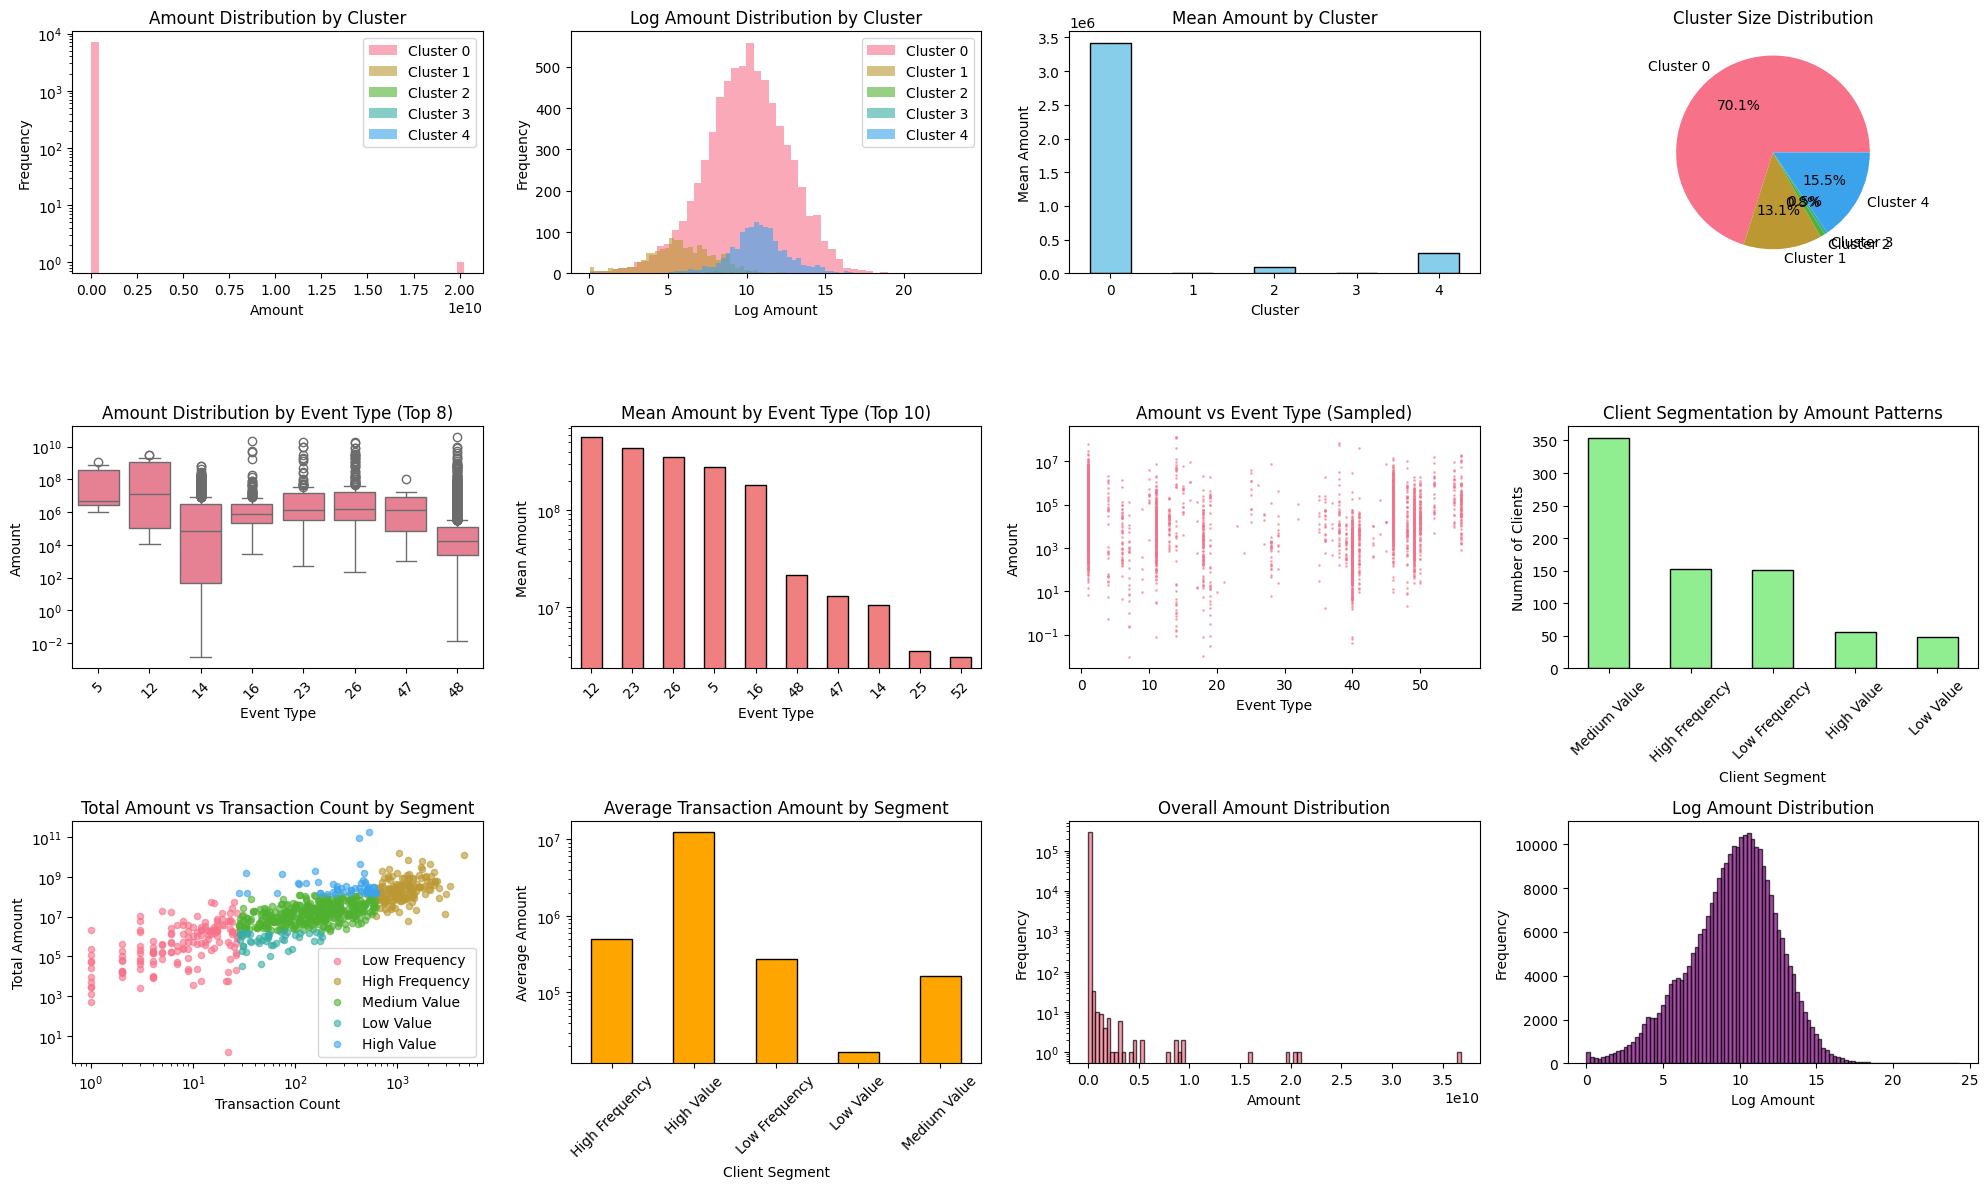

🔍 5. AMOUNT PATTERN INSIGHTS
Transaction Amount Categories:
  Small transactions (≤5,145.81): 94,277 (33.0%)
  Medium transactions (5,145.81 < amount ≤ 57,780.55): 97,132 (34.0%)
  Large transactions (>57,780.55): 94,277 (33.0%)

📊 SUMMARY INSIGHTS FROM AMOUNT ANALYSIS:
1. AMOUNT CLUSTERING:
   - Identified 5 distinct amount clusters
   - Cluster sizes range from 51 to 7009 transactions
   - Amount ranges from 0.00 to 36,787,859,456.00

2. EVENT TYPE PATTERNS:
   - 51 unique event types
   - Highest average amount: 562,895,936.00
   - Lowest average amount: 3,976.24

3. CLIENT SEGMENTATION:
   - 761 clients analyzed
   - 56 high-value clients
   - 152 high-frequency clients

4. AMOUNT DISTRIBUTION:
   - Median transaction amount: 18,422.54
   - 95% of transactions are below: 1,103,427.44
   - Amount distribution is highly skewed (right-tailed)

=== FINDINGS ===
- 5 amount clusters; range: 0.00–36,787,859,456.00
- Event types: 51; highest avg: 562,895,936.00; lowest avg: 3,976.24
- Clie

In [50]:
# Amount Pattern Deep Dive
# Transaction amount clustering, amount distribution by event type, amount-based client segments

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from scipy import stats
    import warnings
    warnings.filterwarnings('ignore')
    
    print("=== AMOUNT PATTERN DEEP DIVE ===")
    print("Analyzing transaction amount patterns, clustering, and client segmentation")
    print()
    
    # Load sample data for amount analysis
    sample_files = list(BASE_DIR.glob("fold=0/*.parquet"))[:3]  # Use first 3 files for better coverage
    
    if sample_files:
        print(f"Loading data from {len(sample_files)} files for amount analysis...")
        
        # Load data
        dfs = []
        for file_path in sample_files:
            try:
                df = pd.read_parquet(file_path)
                dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
        
        if dfs:
            df = pd.concat(dfs, ignore_index=True)
            print(f"Loaded {len(df)} transactions for amount analysis")
            
            # Ensure we have amount data
            if 'amount' not in df.columns:
                print("Warning: 'amount' column not found")
                print(f"Available columns: {list(df.columns)}")
            else:
                # Clean amount data
                df = df.dropna(subset=['amount'])
                df = df[df['amount'] >= 0]  # Remove negative amounts
                print(f"After cleaning: {len(df)} transactions with valid amounts")
                
                # Create log_amount for better analysis
                df['log_amount'] = np.log1p(df['amount'])
                
                print()
                
                # 1. TRANSACTION AMOUNT CLUSTERING
                print("🔍 1. TRANSACTION AMOUNT CLUSTERING")
                print("=" * 60)
                
                # Prepare data for clustering
                amount_features = ['amount', 'log_amount']
                if 'event_type' in df.columns:
                    amount_features.append('event_type')
                if 'event_subtype' in df.columns:
                    amount_features.append('event_subtype')
                
                # Sample data for clustering (to handle large datasets)
                sample_size = min(10000, len(df))
                df_sample = df.sample(n=sample_size, random_state=42)
                
                # Create features for clustering
                cluster_features = ['log_amount']
                if 'event_type' in df.columns:
                    # One-hot encode event_type for clustering
                    event_dummies = pd.get_dummies(df_sample['event_type'], prefix='event_type')
                    cluster_features.extend(event_dummies.columns)
                    df_cluster = pd.concat([df_sample[['log_amount']], event_dummies], axis=1)
                else:
                    df_cluster = df_sample[['log_amount']]
                
                # Standardize features
                scaler = StandardScaler()
                df_cluster_scaled = scaler.fit_transform(df_cluster)
                
                # Perform K-means clustering
                n_clusters = 5
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                df_sample['amount_cluster'] = kmeans.fit_predict(df_cluster_scaled)
                
                # Analyze clusters
                cluster_analysis = df_sample.groupby('amount_cluster').agg({
                    'amount': ['count', 'mean', 'std', 'min', 'max', 'median'],
                    'log_amount': ['mean', 'std']
                }).round(3)
                
                print("Amount Cluster Analysis:")
                print(cluster_analysis)
                print()
                
                # Visualize clustering results
                plt.figure(figsize=(20, 12))
                
                # Subplot 1: Amount distribution by cluster
                plt.subplot(3, 4, 1)
                for cluster in range(n_clusters):
                    cluster_data = df_sample[df_sample['amount_cluster'] == cluster]['amount']
                    plt.hist(cluster_data, bins=50, alpha=0.6, label=f'Cluster {cluster}')
                plt.title('Amount Distribution by Cluster')
                plt.xlabel('Amount')
                plt.ylabel('Frequency')
                plt.legend()
                plt.yscale('log')
                
                # Subplot 2: Log amount distribution by cluster
                plt.subplot(3, 4, 2)
                for cluster in range(n_clusters):
                    cluster_data = df_sample[df_sample['amount_cluster'] == cluster]['log_amount']
                    plt.hist(cluster_data, bins=50, alpha=0.6, label=f'Cluster {cluster}')
                plt.title('Log Amount Distribution by Cluster')
                plt.xlabel('Log Amount')
                plt.ylabel('Frequency')
                plt.legend()
                
                # Subplot 3: Cluster statistics
                plt.subplot(3, 4, 3)
                cluster_stats = df_sample.groupby('amount_cluster')['amount'].agg(['mean', 'std', 'count'])
                cluster_stats['mean'].plot(kind='bar', color='skyblue', edgecolor='black')
                plt.title('Mean Amount by Cluster')
                plt.xlabel('Cluster')
                plt.ylabel('Mean Amount')
                plt.xticks(rotation=0)
                
                # Subplot 4: Cluster size distribution
                plt.subplot(3, 4, 4)
                cluster_sizes = df_sample['amount_cluster'].value_counts().sort_index()
                plt.pie(cluster_sizes.values, labels=[f'Cluster {i}' for i in cluster_sizes.index], autopct='%1.1f%%')
                plt.title('Cluster Size Distribution')
                
                # 2. AMOUNT DISTRIBUTION BY EVENT TYPE
                print("🔍 2. AMOUNT DISTRIBUTION BY EVENT TYPE")
                print("=" * 60)
                
                if 'event_type' in df.columns:
                    # Amount statistics by event type
                    event_amount_stats = df.groupby('event_type')['amount'].agg([
                        'count', 'mean', 'std', 'min', 'max', 'median'
                    ]).round(3)
                    event_amount_stats = event_amount_stats.sort_values('mean', ascending=False)
                    
                    print("Amount Statistics by Event Type:")
                    print(event_amount_stats.head(10))
                    print()
                    
                    # Visualize amount distribution by event type
                    plt.subplot(3, 4, 5)
                    top_event_types = event_amount_stats.head(8).index
                    df_top_events = df[df['event_type'].isin(top_event_types)]
                    
                    sns.boxplot(data=df_top_events, x='event_type', y='amount')
                    plt.title('Amount Distribution by Event Type (Top 8)')
                    plt.xlabel('Event Type')
                    plt.ylabel('Amount')
                    plt.xticks(rotation=45)
                    plt.yscale('log')
                    
                    # Subplot 6: Mean amount by event type
                    plt.subplot(3, 4, 6)
                    event_amount_stats['mean'].head(10).plot(kind='bar', color='lightcoral', edgecolor='black')
                    plt.title('Mean Amount by Event Type (Top 10)')
                    plt.xlabel('Event Type')
                    plt.ylabel('Mean Amount')
                    plt.xticks(rotation=45)
                    plt.yscale('log')
                    
                    # Subplot 7: Amount vs event type scatter
                    plt.subplot(3, 4, 7)
                    sample_size_scatter = min(5000, len(df))
                    df_scatter = df.sample(n=sample_size_scatter, random_state=42)
                    plt.scatter(df_scatter['event_type'], df_scatter['amount'], alpha=0.5, s=1)
                    plt.title('Amount vs Event Type (Sampled)')
                    plt.xlabel('Event Type')
                    plt.ylabel('Amount')
                    plt.yscale('log')
                
                # 3. AMOUNT-BASED CLIENT SEGMENTS
                print("🔍 3. AMOUNT-BASED CLIENT SEGMENTS")
                print("=" * 60)
                
                if 'client_id' in df.columns:
                    # Calculate client-level amount statistics
                    client_amount_stats = df.groupby('client_id').agg({
                        'amount': ['count', 'mean', 'std', 'min', 'max', 'sum'],
                        'log_amount': ['mean', 'std']
                    }).round(3)
                    
                    # Flatten column names
                    client_amount_stats.columns = ['_'.join(col).strip() for col in client_amount_stats.columns]
                    client_amount_stats = client_amount_stats.reset_index()
                    
                    # Create client segments based on amount patterns
                    client_amount_stats['client_segment'] = 'Medium Value'
                    
                    # High value clients (top 20% by total amount)
                    high_value_threshold = client_amount_stats['amount_sum'].quantile(0.8)
                    client_amount_stats.loc[client_amount_stats['amount_sum'] > high_value_threshold, 'client_segment'] = 'High Value'
                    
                    # Low value clients (bottom 20% by total amount)
                    low_value_threshold = client_amount_stats['amount_sum'].quantile(0.2)
                    client_amount_stats.loc[client_amount_stats['amount_sum'] < low_value_threshold, 'client_segment'] = 'Low Value'
                    
                    # High frequency clients (top 20% by transaction count)
                    high_freq_threshold = client_amount_stats['amount_count'].quantile(0.8)
                    client_amount_stats.loc[client_amount_stats['amount_count'] > high_freq_threshold, 'client_segment'] = 'High Frequency'
                    
                    # Low frequency clients (bottom 20% by transaction count)
                    low_freq_threshold = client_amount_stats['amount_count'].quantile(0.2)
                    client_amount_stats.loc[client_amount_stats['amount_count'] < low_freq_threshold, 'client_segment'] = 'Low Frequency'
                    
                    # Segment distribution
                    segment_counts = client_amount_stats['client_segment'].value_counts()
                    print("Client Segmentation by Amount Patterns:")
                    for segment, count in segment_counts.items():
                        percentage = (count / len(client_amount_stats)) * 100
                        print(f"  {segment}: {count} clients ({percentage:.1f}%)")
                    print()
                    
                    # Visualize client segments
                    plt.subplot(3, 4, 8)
                    segment_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
                    plt.title('Client Segmentation by Amount Patterns')
                    plt.xlabel('Client Segment')
                    plt.ylabel('Number of Clients')
                    plt.xticks(rotation=45)
                    
                    # Subplot 9: Total amount vs transaction count by segment
                    plt.subplot(3, 4, 9)
                    for segment in client_amount_stats['client_segment'].unique():
                        segment_data = client_amount_stats[client_amount_stats['client_segment'] == segment]
                        plt.scatter(segment_data['amount_count'], segment_data['amount_sum'], 
                                  alpha=0.6, label=segment, s=20)
                    plt.title('Total Amount vs Transaction Count by Segment')
                    plt.xlabel('Transaction Count')
                    plt.ylabel('Total Amount')
                    plt.legend()
                    plt.yscale('log')
                    plt.xscale('log')
                    
                    # Subplot 10: Average transaction amount by segment
                    plt.subplot(3, 4, 10)
                    segment_avg_amount = client_amount_stats.groupby('client_segment')['amount_mean'].mean()
                    segment_avg_amount.plot(kind='bar', color='orange', edgecolor='black')
                    plt.title('Average Transaction Amount by Segment')
                    plt.xlabel('Client Segment')
                    plt.ylabel('Average Amount')
                    plt.xticks(rotation=45)
                    plt.yscale('log')
                
                # 4. AMOUNT DISTRIBUTION ANALYSIS
                print("🔍 4. AMOUNT DISTRIBUTION ANALYSIS")
                print("=" * 60)
                
                # Overall amount statistics
                amount_stats = df['amount'].describe()
                print("Overall Amount Statistics:")
                print(amount_stats)
                print()
                
                # Amount percentiles
                percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
                amount_percentiles = df['amount'].quantile([p/100 for p in percentiles])
                print("Amount Percentiles:")
                for p, value in zip(percentiles, amount_percentiles):
                    print(f"  {p:2d}th percentile: {value:,.2f}")
                print()
                
                # Visualize amount distribution
                plt.subplot(3, 4, 11)
                plt.hist(df['amount'], bins=100, alpha=0.7, edgecolor='black')
                plt.title('Overall Amount Distribution')
                plt.xlabel('Amount')
                plt.ylabel('Frequency')
                plt.yscale('log')
                
                # Subplot 12: Log amount distribution
                plt.subplot(3, 4, 12)
                plt.hist(df['log_amount'], bins=100, alpha=0.7, edgecolor='black', color='purple')
                plt.title('Log Amount Distribution')
                plt.xlabel('Log Amount')
                plt.ylabel('Frequency')
                
                plt.tight_layout()
                plt.show()
                
                # 5. AMOUNT PATTERN INSIGHTS
                print("🔍 5. AMOUNT PATTERN INSIGHTS")
                print("=" * 60)
                
                # Identify amount patterns
                small_amount_threshold = df['amount'].quantile(0.33)
                large_amount_threshold = df['amount'].quantile(0.67)
                
                small_transactions = df[df['amount'] <= small_amount_threshold]
                medium_transactions = df[(df['amount'] > small_amount_threshold) & (df['amount'] <= large_amount_threshold)]
                large_transactions = df[df['amount'] > large_amount_threshold]
                
                print("Transaction Amount Categories:")
                print(f"  Small transactions (≤{small_amount_threshold:,.2f}): {len(small_transactions):,} ({len(small_transactions)/len(df)*100:.1f}%)")
                print(f"  Medium transactions ({small_amount_threshold:,.2f} < amount ≤ {large_amount_threshold:,.2f}): {len(medium_transactions):,} ({len(medium_transactions)/len(df)*100:.1f}%)")
                print(f"  Large transactions (>{large_amount_threshold:,.2f}): {len(large_transactions):,} ({len(large_transactions)/len(df)*100:.1f}%)")
                print()
                
                # SUMMARY INSIGHTS
                print("📊 SUMMARY INSIGHTS FROM AMOUNT ANALYSIS:")
                print("=" * 60)
                print("1. AMOUNT CLUSTERING:")
                print(f"   - Identified {n_clusters} distinct amount clusters")
                print(f"   - Cluster sizes range from {cluster_sizes.min()} to {cluster_sizes.max()} transactions")
                print(f"   - Amount ranges from {df['amount'].min():,.2f} to {df['amount'].max():,.2f}")
                print()
                print("2. EVENT TYPE PATTERNS:")
                if 'event_type' in df.columns:
                    num_event_types = len(df['event_type'].unique())
                    highest_avg = event_amount_stats.iloc[0]['mean'] if len(event_amount_stats) else np.nan
                    lowest_avg = event_amount_stats.iloc[-1]['mean'] if len(event_amount_stats) else np.nan
                    print(f"   - {num_event_types} unique event types")
                    print(f"   - Highest average amount: {highest_avg:,.2f}")
                    print(f"   - Lowest average amount: {lowest_avg:,.2f}")
                print()
                print("3. CLIENT SEGMENTATION:")
                if 'client_id' in df.columns:
                    num_clients = len(client_amount_stats)
                    print(f"   - {num_clients} clients analyzed")
                    print(f"   - {segment_counts.get('High Value', 0)} high-value clients")
                    print(f"   - {segment_counts.get('High Frequency', 0)} high-frequency clients")
                print()
                print("4. AMOUNT DISTRIBUTION:")
                median_amt = df['amount'].median()
                p95_amt = df['amount'].quantile(0.95)
                print(f"   - Median transaction amount: {median_amt:,.2f}")
                print(f"   - 95% of transactions are below: {p95_amt:,.2f}")
                print(f"   - Amount distribution is highly skewed (right-tailed)")
                print()
                
                # Auto-generated Findings
                findings = []
                findings.append(f"- {n_clusters} amount clusters; range: {df['amount'].min():,.2f}–{df['amount'].max():,.2f}")
                if 'event_type' in df.columns and len(event_amount_stats):
                    findings.append(f"- Event types: {num_event_types}; highest avg: {highest_avg:,.2f}; lowest avg: {lowest_avg:,.2f}")
                if 'client_id' in df.columns:
                    findings.append(f"- Clients analyzed: {num_clients}; High-Value: {segment_counts.get('High Value', 0)}; High-Freq: {segment_counts.get('High Frequency', 0)}")
                findings.append(f"- Median amount: {median_amt:,.2f}; P95: {p95_amt:,.2f}")
                
                print("=== FINDINGS ===")
                for line in findings:
                    print(line)
                print()
                
        else:
            print("No data loaded for amount analysis")
    else:
        print("No parquet files found for amount analysis")
        
except ImportError as e:
    print(f"Required libraries not available: {e}")
    print("Install required packages: pip install pandas numpy matplotlib seaborn scikit-learn scipy")
except Exception as e:
    print(f"Error in amount analysis: {e}")
    import traceback
    traceback.print_exc()


=== TEMPORAL PATTERN ENHANCEMENT ===
Analyzing transaction frequency, burst patterns, and temporal intervals

Loading data from 3 files for temporal analysis...
Loaded 285686 transactions for temporal analysis
Using 'event_time' column as timestamp
Timestamp range: 2020-12-31 21:02:05.203606 to 2022-12-31 20:36:20.680347

🔍 1. TRANSACTION FREQUENCY ANALYSIS PER CLIENT
Analyzing temporal patterns for 761 clients

Transaction Frequency Statistics:
count    761.000000
mean       0.567423
std        0.725167
min        0.004335
25%        0.098474
50%        0.272727
75%        0.777166
max        6.183562
Name: transactions_per_day, dtype: float64

🔍 2. BURST VS STEADY TRANSACTION PATTERNS
Burst Pattern Analysis:
  Average median interval: 371.07 hours
  Average burst ratio: 0.250
  Average coefficient of variation: 2.385

Client Pattern Types:
  Irregular: 90 clients (90.0%)
  Steady: 7 clients (7.0%)
  Bursty: 3 clients (3.0%)

🔍 3. TRANSACTION INTERVALS AND GAPS
Global Transaction Inte

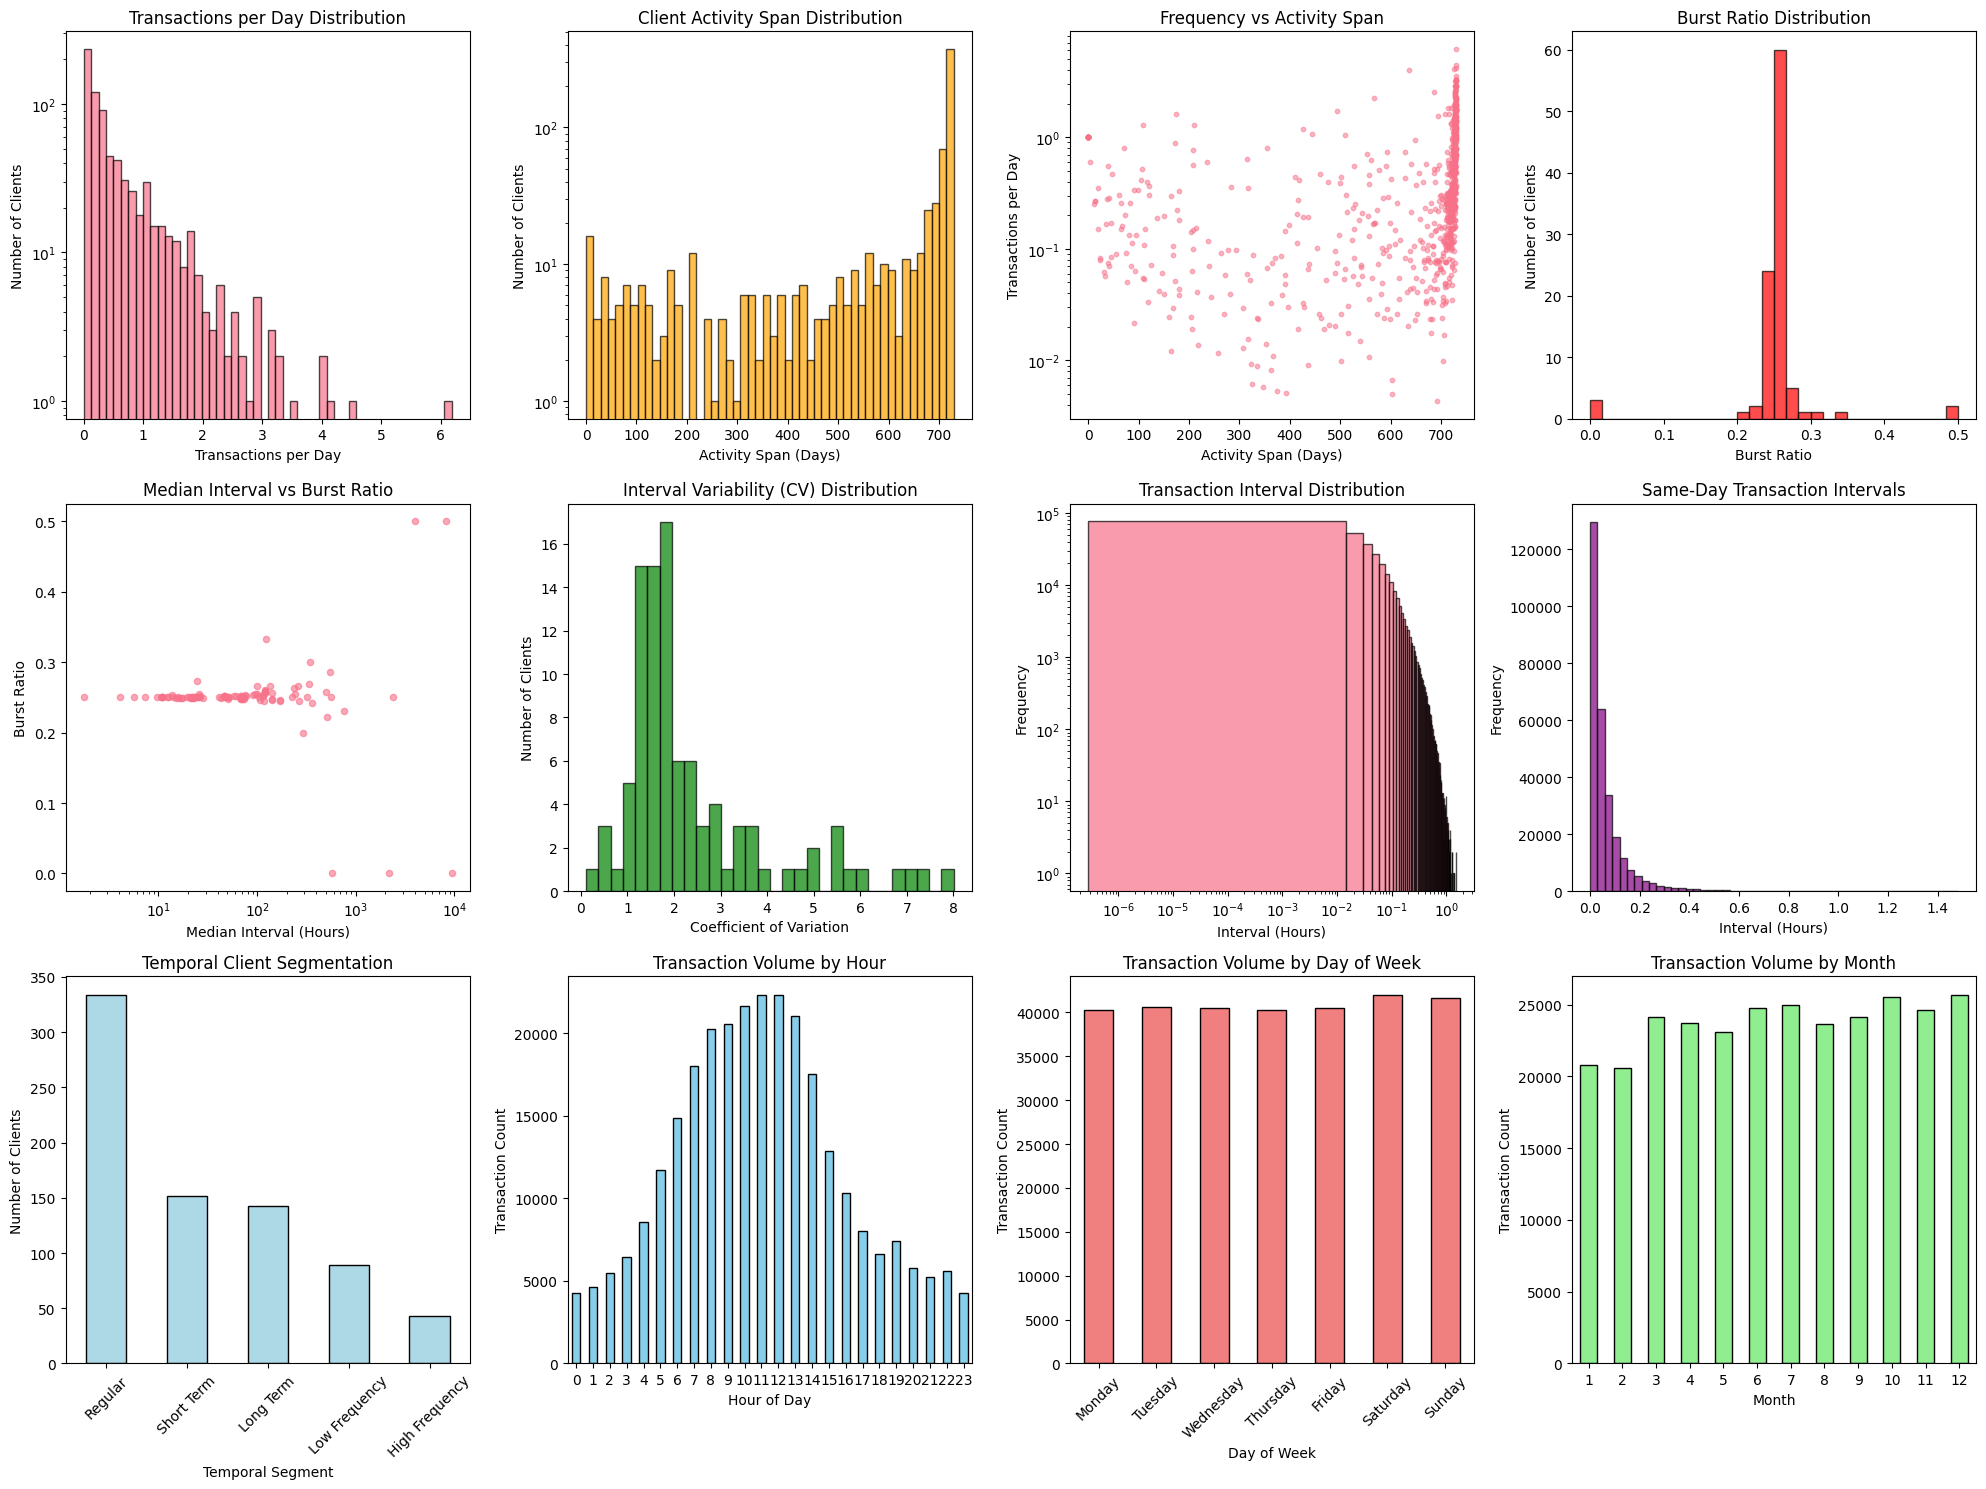

📊 SUMMARY INSIGHTS FROM TEMPORAL ANALYSIS:
1. TRANSACTION FREQUENCY:
   - Average transactions per day per client: 0.57
   - Median transactions per day per client: 0.27
   - Top 10% of clients average 1.51 transactions/day

2. ACTIVITY SPANS:
   - Average client activity span: 594.4 days
   - Median client activity span: 713.0 days
   - Longest active client: 729 days

3. BURST PATTERNS:
   - Average burst ratio: 0.250
   - 3 clients show bursty patterns
   - 7 clients show steady patterns

4. TEMPORAL SEGMENTATION:
   - 43 high-frequency clients
   - 143 long-term clients
   - 334 regular clients

5. TIME PATTERNS:
   - Most active hour: 11:00 (22,325 transactions)
   - Most active day: Saturday (42,016 transactions)
   - Most active month: 12 (25,691 transactions)

=== FINDINGS ===
- Tx/day per client: avg 0.57, median 0.27, P90 1.51
- Activity span: avg 594.4d, median 713.0d, max 729d
- Average burst ratio: 0.250; Bursty 3, Steady 7
- Most active: hour 11, day Saturday, month 12



In [51]:
# Temporal Pattern Enhancement
# Transaction frequency analysis per client, burst vs steady patterns, transaction intervals and gaps

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime, timedelta
    from scipy import stats
    import warnings
    warnings.filterwarnings('ignore')
    
    print("=== TEMPORAL PATTERN ENHANCEMENT ===")
    print("Analyzing transaction frequency, burst patterns, and temporal intervals")
    print()
    
    # Load sample data for temporal analysis
    sample_files = list(BASE_DIR.glob("fold=0/*.parquet"))[:3]  # Use first 3 files for better coverage
    
    if sample_files:
        print(f"Loading data from {len(sample_files)} files for temporal analysis...")
        
        # Load data
        dfs = []
        for file_path in sample_files:
            try:
                df = pd.read_parquet(file_path)
                dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
        
        if dfs:
            df = pd.concat(dfs, ignore_index=True)
            print(f"Loaded {len(df)} transactions for temporal analysis")
            
            # Check for timestamp column and use event_time
            if 'event_time' in df.columns:
                df['timestamp'] = df['event_time']  # Use event_time as timestamp
                print(f"Using 'event_time' column as timestamp")
            elif 'timestamp' in df.columns:
                print(f"Using 'timestamp' column")
            else:
                print("Warning: No timestamp column found")
                print(f"Available columns: {list(df.columns)}")
                # Try to find alternative time columns
                time_columns = [col for col in df.columns if 'time' in col.lower() or 'date' in col.lower()]
                if time_columns:
                    print(f"Found potential time columns: {time_columns}")
                    df['timestamp'] = df[time_columns[0]]  # Use first time column found
                else:
                    print("No time columns found - cannot perform temporal analysis")
            
            # Convert timestamp to datetime if needed
            if 'timestamp' in df.columns:
                if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
                    try:
                        df['timestamp'] = pd.to_datetime(df['timestamp'])
                        print(f"Converted timestamp to datetime format")
                    except Exception as e:
                        print(f"Could not convert timestamp to datetime: {e}")
                
                print(f"Timestamp range: {df['timestamp'].min()} to {df['timestamp'].max()}")
                print()
                
                # 1. TRANSACTION FREQUENCY ANALYSIS PER CLIENT
                print("🔍 1. TRANSACTION FREQUENCY ANALYSIS PER CLIENT")
                print("=" * 60)
                
                if 'client_id' in df.columns:
                    # Calculate client-level temporal statistics
                    client_temporal_stats = df.groupby('client_id').agg({
                        'timestamp': ['min', 'max', 'count'],
                        'amount': 'sum'
                    }).round(3)
                    
                    # Flatten column names
                    client_temporal_stats.columns = ['_'.join(col).strip() for col in client_temporal_stats.columns]
                    client_temporal_stats = client_temporal_stats.reset_index()
                    
                    # Calculate temporal metrics
                    client_temporal_stats['activity_span_days'] = (
                        client_temporal_stats['timestamp_max'] - client_temporal_stats['timestamp_min']
                    ).dt.days
                    
                    client_temporal_stats['transactions_per_day'] = (
                        client_temporal_stats['timestamp_count'] / 
                        (client_temporal_stats['activity_span_days'] + 1)  # +1 to avoid division by zero
                    )
                    
                    client_temporal_stats['transactions_per_week'] = client_temporal_stats['transactions_per_day'] * 7
                    client_temporal_stats['transactions_per_month'] = client_temporal_stats['transactions_per_day'] * 30
                    
                    # Remove clients with invalid temporal data
                    client_temporal_stats = client_temporal_stats[
                        (client_temporal_stats['activity_span_days'] >= 0) & 
                        (client_temporal_stats['transactions_per_day'] >= 0)
                    ]
                    
                    print(f"Analyzing temporal patterns for {len(client_temporal_stats)} clients")
                    print()
                    
                    # Frequency statistics
                    print("Transaction Frequency Statistics:")
                    freq_stats = client_temporal_stats['transactions_per_day'].describe()
                    print(freq_stats)
                    print()
                    
                    # Visualize frequency patterns
                    plt.figure(figsize=(20, 15))
                    
                    # Subplot 1: Transactions per day distribution
                    plt.subplot(3, 4, 1)
                    plt.hist(client_temporal_stats['transactions_per_day'], bins=50, alpha=0.7, edgecolor='black')
                    plt.title('Transactions per Day Distribution')
                    plt.xlabel('Transactions per Day')
                    plt.ylabel('Number of Clients')
                    plt.yscale('log')
                    
                    # Subplot 2: Activity span distribution
                    plt.subplot(3, 4, 2)
                    plt.hist(client_temporal_stats['activity_span_days'], bins=50, alpha=0.7, edgecolor='black', color='orange')
                    plt.title('Client Activity Span Distribution')
                    plt.xlabel('Activity Span (Days)')
                    plt.ylabel('Number of Clients')
                    plt.yscale('log')
                    
                    # Subplot 3: Frequency vs activity span
                    plt.subplot(3, 4, 3)
                    plt.scatter(client_temporal_stats['activity_span_days'], 
                              client_temporal_stats['transactions_per_day'], alpha=0.5, s=10)
                    plt.title('Frequency vs Activity Span')
                    plt.xlabel('Activity Span (Days)')
                    plt.ylabel('Transactions per Day')
                    plt.yscale('log')
                    
                    # 2. BURST VS STEADY TRANSACTION PATTERNS
                    print("🔍 2. BURST VS STEADY TRANSACTION PATTERNS")
                    print("=" * 60)
                    
                    # Calculate burst patterns for each client
                    burst_analysis = []
                    
                    for client_id in client_temporal_stats['client_id'].head(100):  # Analyze top 100 clients for speed
                        client_data = df[df['client_id'] == client_id].sort_values('timestamp')
                        
                        if len(client_data) > 1:
                            # Calculate time intervals between transactions
                            client_data['time_diff'] = client_data['timestamp'].diff().dt.total_seconds() / 3600  # hours
                            time_diffs = client_data['time_diff'].dropna()
                            
                            if len(time_diffs) > 0:
                                # Calculate burst metrics
                                median_interval = time_diffs.median()
                                std_interval = time_diffs.std()
                                cv_interval = std_interval / median_interval if median_interval > 0 else 0
                                
                                # Identify burst periods (intervals < 25th percentile)
                                burst_threshold = time_diffs.quantile(0.25)
                                burst_periods = (time_diffs < burst_threshold).sum()
                                burst_ratio = burst_periods / len(time_diffs)
                                
                                burst_analysis.append({
                                    'client_id': client_id,
                                    'median_interval_hours': median_interval,
                                    'std_interval_hours': std_interval,
                                    'cv_interval': cv_interval,
                                    'burst_ratio': burst_ratio,
                                    'total_transactions': len(client_data)
                                })
                    
                    if burst_analysis:
                        burst_df = pd.DataFrame(burst_analysis)
                        
                        print("Burst Pattern Analysis:")
                        print(f"  Average median interval: {burst_df['median_interval_hours'].mean():.2f} hours")
                        print(f"  Average burst ratio: {burst_df['burst_ratio'].mean():.3f}")
                        print(f"  Average coefficient of variation: {burst_df['cv_interval'].mean():.3f}")
                        print()
                        
                        # Visualize burst patterns
                        plt.subplot(3, 4, 4)
                        plt.hist(burst_df['burst_ratio'], bins=30, alpha=0.7, edgecolor='black', color='red')
                        plt.title('Burst Ratio Distribution')
                        plt.xlabel('Burst Ratio')
                        plt.ylabel('Number of Clients')
                        
                        plt.subplot(3, 4, 5)
                        plt.scatter(burst_df['median_interval_hours'], burst_df['burst_ratio'], alpha=0.6, s=20)
                        plt.title('Median Interval vs Burst Ratio')
                        plt.xlabel('Median Interval (Hours)')
                        plt.ylabel('Burst Ratio')
                        plt.xscale('log')
                        
                        plt.subplot(3, 4, 6)
                        plt.hist(burst_df['cv_interval'], bins=30, alpha=0.7, edgecolor='black', color='green')
                        plt.title('Interval Variability (CV) Distribution')
                        plt.xlabel('Coefficient of Variation')
                        plt.ylabel('Number of Clients')
                        
                        # Client segmentation by burst patterns
                        burst_df['pattern_type'] = 'Steady'
                        burst_df.loc[burst_df['burst_ratio'] > 0.3, 'pattern_type'] = 'Bursty'
                        burst_df.loc[burst_df['cv_interval'] > 1.0, 'pattern_type'] = 'Irregular'
                        burst_df.loc[(burst_df['burst_ratio'] > 0.3) & (burst_df['cv_interval'] > 1.0), 'pattern_type'] = 'Chaotic'
                        
                        pattern_counts = burst_df['pattern_type'].value_counts()
                        print("Client Pattern Types:")
                        for pattern, count in pattern_counts.items():
                            percentage = (count / len(burst_df)) * 100
                            print(f"  {pattern}: {count} clients ({percentage:.1f}%)")
                        print()
                    
                    # 3. TRANSACTION INTERVALS AND GAPS
                    print("🔍 3. TRANSACTION INTERVALS AND GAPS")
                    print("=" * 60)
                    
                    # Calculate global transaction intervals
                    df_sorted = df.sort_values('timestamp')
                    df_sorted['time_diff_hours'] = df_sorted['timestamp'].diff().dt.total_seconds() / 3600
                    df_sorted['time_diff_days'] = df_sorted['time_diff_hours'] / 24
                    
                    # Remove first row (no previous transaction)
                    time_diffs = df_sorted['time_diff_hours'].dropna()
                    
                    print("Global Transaction Interval Statistics:")
                    interval_stats = time_diffs.describe()
                    print(interval_stats)
                    print()
                    
                    # Interval percentiles
                    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
                    interval_percentiles = time_diffs.quantile([p/100 for p in percentiles])
                    print("Transaction Interval Percentiles (Hours):")
                    for p, value in zip(percentiles, interval_percentiles):
                        print(f"  {p:2d}th percentile: {value:.2f} hours ({value/24:.2f} days)")
                    print()
                    
                    # Visualize intervals
                    plt.subplot(3, 4, 7)
                    plt.hist(time_diffs, bins=100, alpha=0.7, edgecolor='black')
                    plt.title('Transaction Interval Distribution')
                    plt.xlabel('Interval (Hours)')
                    plt.ylabel('Frequency')
                    plt.yscale('log')
                    plt.xscale('log')
                    
                    plt.subplot(3, 4, 8)
                    plt.hist(time_diffs[time_diffs <= 24], bins=50, alpha=0.7, edgecolor='black', color='purple')
                    plt.title('Same-Day Transaction Intervals')
                    plt.xlabel('Interval (Hours)')
                    plt.ylabel('Frequency')
                    
                    # 4. TEMPORAL CLIENT SEGMENTATION
                    print("🔍 4. TEMPORAL CLIENT SEGMENTATION")
                    print("=" * 60)
                    
                    # Create temporal client segments
                    client_temporal_stats['temporal_segment'] = 'Regular'
                    
                    # High frequency clients
                    high_freq_threshold = client_temporal_stats['transactions_per_day'].quantile(0.8)
                    client_temporal_stats.loc[
                        client_temporal_stats['transactions_per_day'] > high_freq_threshold, 
                        'temporal_segment'
                    ] = 'High Frequency'
                    
                    # Low frequency clients
                    low_freq_threshold = client_temporal_stats['transactions_per_day'].quantile(0.2)
                    client_temporal_stats.loc[
                        client_temporal_stats['transactions_per_day'] < low_freq_threshold, 
                        'temporal_segment'
                    ] = 'Low Frequency'
                    
                    # Long-term clients
                    long_term_threshold = client_temporal_stats['activity_span_days'].quantile(0.8)
                    client_temporal_stats.loc[
                        client_temporal_stats['activity_span_days'] > long_term_threshold, 
                        'temporal_segment'
                    ] = 'Long Term'
                    
                    # Short-term clients
                    short_term_threshold = client_temporal_stats['activity_span_days'].quantile(0.2)
                    client_temporal_stats.loc[
                        client_temporal_stats['activity_span_days'] < short_term_threshold, 
                        'temporal_segment'
                    ] = 'Short Term'
                    
                    # Segment distribution
                    temporal_segment_counts = client_temporal_stats['temporal_segment'].value_counts()
                    print("Temporal Client Segmentation:")
                    for segment, count in temporal_segment_counts.items():
                        percentage = (count / len(client_temporal_stats)) * 100
                        print(f"  {segment}: {count} clients ({percentage:.1f}%)")
                    print()
                    
                    # Visualize temporal segments
                    plt.subplot(3, 4, 9)
                    temporal_segment_counts.plot(kind='bar', color='lightblue', edgecolor='black')
                    plt.title('Temporal Client Segmentation')
                    plt.xlabel('Temporal Segment')
                    plt.ylabel('Number of Clients')
                    plt.xticks(rotation=45)
                    
                    # 5. DAILY/WEEKLY/MONTHLY PATTERNS
                    print("🔍 5. DAILY/WEEKLY/MONTHLY PATTERNS")
                    print("=" * 60)
                    
                    # Extract temporal features
                    df['hour'] = df['timestamp'].dt.hour
                    df['day_of_week'] = df['timestamp'].dt.day_name()
                    df['day_of_month'] = df['timestamp'].dt.day
                    df['month'] = df['timestamp'].dt.month
                    df['week_of_year'] = df['timestamp'].dt.isocalendar().week
                    
                    # Hourly patterns
                    hourly_counts = df['hour'].value_counts().sort_index()
                    print("Top 5 Most Active Hours:")
                    for hour, count in hourly_counts.head().items():
                        print(f"  Hour {hour:02d}:00 - {count:,} transactions")
                    print()
                    
                    # Daily patterns
                    daily_counts = df['day_of_week'].value_counts()
                    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                    daily_counts = daily_counts.reindex(day_order)
                    print("Transactions by Day of Week:")
                    for day, count in daily_counts.items():
                        print(f"  {day}: {count:,} transactions")
                    print()
                    
                    # Visualize temporal patterns
                    plt.subplot(3, 4, 10)
                    hourly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
                    plt.title('Transaction Volume by Hour')
                    plt.xlabel('Hour of Day')
                    plt.ylabel('Transaction Count')
                    plt.xticks(rotation=0)
                    
                    plt.subplot(3, 4, 11)
                    daily_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
                    plt.title('Transaction Volume by Day of Week')
                    plt.xlabel('Day of Week')
                    plt.ylabel('Transaction Count')
                    plt.xticks(rotation=45)
                    
                    # Monthly patterns
                    monthly_counts = df['month'].value_counts().sort_index()
                    plt.subplot(3, 4, 12)
                    monthly_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
                    plt.title('Transaction Volume by Month')
                    plt.xlabel('Month')
                    plt.ylabel('Transaction Count')
                    plt.xticks(rotation=0)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # SUMMARY INSIGHTS
                    print("📊 SUMMARY INSIGHTS FROM TEMPORAL ANALYSIS:")
                    print("=" * 60)
                    avg_per_day = client_temporal_stats['transactions_per_day'].mean()
                    med_per_day = client_temporal_stats['transactions_per_day'].median()
                    p90_per_day = client_temporal_stats['transactions_per_day'].quantile(0.9)
                    print("1. TRANSACTION FREQUENCY:")
                    print(f"   - Average transactions per day per client: {avg_per_day:.2f}")
                    print(f"   - Median transactions per day per client: {med_per_day:.2f}")
                    print(f"   - Top 10% of clients average {p90_per_day:.2f} transactions/day")
                    print()
                    print("2. ACTIVITY SPANS:")
                    avg_span = client_temporal_stats['activity_span_days'].mean()
                    med_span = client_temporal_stats['activity_span_days'].median()
                    max_span = client_temporal_stats['activity_span_days'].max()
                    print(f"   - Average client activity span: {avg_span:.1f} days")
                    print(f"   - Median client activity span: {med_span:.1f} days")
                    print(f"   - Longest active client: {max_span:.0f} days")
                    print()
                    print("3. BURST PATTERNS:")
                    if burst_analysis:
                        avg_burst = burst_df['burst_ratio'].mean()
                        print(f"   - Average burst ratio: {avg_burst:.3f}")
                        print(f"   - {pattern_counts.get('Bursty', 0)} clients show bursty patterns")
                        print(f"   - {pattern_counts.get('Steady', 0)} clients show steady patterns")
                    print()
                    print("4. TEMPORAL SEGMENTATION:")
                    print(f"   - {temporal_segment_counts.get('High Frequency', 0)} high-frequency clients")
                    print(f"   - {temporal_segment_counts.get('Long Term', 0)} long-term clients")
                    print(f"   - {temporal_segment_counts.get('Regular', 0)} regular clients")
                    print()
                    print("5. TIME PATTERNS:")
                    most_hour = hourly_counts.idxmax()
                    most_day = daily_counts.idxmax()
                    most_month = monthly_counts.idxmax()
                    print(f"   - Most active hour: {most_hour}:00 ({hourly_counts.max():,} transactions)")
                    print(f"   - Most active day: {most_day} ({daily_counts.max():,} transactions)")
                    print(f"   - Most active month: {most_month} ({monthly_counts.max():,} transactions)")
                    print()
                    
                    # Auto-generated Findings
                    findings = []
                    findings.append(f"- Tx/day per client: avg {avg_per_day:.2f}, median {med_per_day:.2f}, P90 {p90_per_day:.2f}")
                    findings.append(f"- Activity span: avg {avg_span:.1f}d, median {med_span:.1f}d, max {max_span:.0f}d")
                    if burst_analysis:
                        findings.append(f"- Average burst ratio: {avg_burst:.3f}; Bursty {pattern_counts.get('Bursty', 0)}, Steady {pattern_counts.get('Steady', 0)}")
                    findings.append(f"- Most active: hour {most_hour}, day {most_day}, month {most_month}")
                    
                    print("=== FINDINGS ===")
                    for line in findings:
                        print(line)
                    print()
                
                else:
                    print("client_id column not found - cannot perform client-level temporal analysis")
                    print("Available columns:", list(df.columns))
                
        else:
            print("No data loaded for temporal analysis")
    else:
        print("No parquet files found for temporal analysis")
        
except ImportError as e:
    print(f"Required libraries not available: {e}")
    print("Install required packages: pip install pandas numpy matplotlib seaborn scipy")
except Exception as e:
    print(f"Error in temporal analysis: {e}")
    import traceback
    traceback.print_exc()


In [52]:
# Notebook Cleanup and Visualization Improvements
# This cell provides improved visualization functions and notebook organization

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

def improve_heatmap_readability(data, title="Heatmap", max_size=20, annot_threshold=1000):
    """
    Improve heatmap readability by filtering and formatting
    """
    if len(data) == 0:
        return None
    
    # Remove zero rows and columns
    data_clean = data.copy()
    data_clean = data_clean[data_clean.sum(axis=1) > 0]
    data_clean = data_clean.loc[:, data_clean.sum(axis=0) > 0]
    
    if len(data_clean) == 0:
        return None
    
    # Limit size for readability
    if len(data_clean) > max_size:
        data_clean = data_clean.head(max_size)
    if len(data_clean.columns) > max_size:
        data_clean = data_clean.iloc[:, :max_size]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    
    # Only show annotations for values above threshold
    annot_data = data_clean.copy()
    annot_data[annot_data < annot_threshold] = ''
    
    sns.heatmap(data_clean, 
                annot=annot_data if annot_threshold > 0 else True,
                fmt='d' if annot_threshold > 0 else '.0f',
                cmap='Blues',
                cbar_kws={'label': 'Transaction Count'},
                linewidths=0.5)
    
    plt.title(f'{title}\n(Top {len(data_clean)}×{len(data_clean.columns)} Combinations)')
    plt.tight_layout()
    return data_clean

def create_sequence_summary(sequences, max_show=10):
    """
    Create a readable summary of transaction sequences
    """
    if not sequences:
        return "No sequences found"
    
    summary = []
    for i, (seq, count) in enumerate(sequences[:max_show]):
        if len(seq) <= 5:
            seq_str = str(seq)
        else:
            seq_str = f"({', '.join(map(str, seq[:3]))}...{', '.join(map(str, seq[-2:]))})"
        summary.append(f"{i+1:2d}. {seq_str} ({count} times)")
    
    return "\n".join(summary)

def improve_transition_visualization(transitions, max_types=15):
    """
    Create a focused transition visualization
    """
    if not transitions:
        return None
    
    # Get top event types from transitions
    all_types = set()
    for (from_type, to_type), count in transitions.items():
        all_types.add(from_type)
        all_types.add(to_type)
    
    # Create transition matrix for top types
    top_types = sorted(list(all_types))[:max_types]
    
    if len(top_types) < 2:
        return None
    
    # Create matrix
    transition_matrix = pd.DataFrame(0, index=top_types, columns=top_types)
    
    for (from_type, to_type), count in transitions.items():
        if from_type in top_types and to_type in top_types:
            transition_matrix.loc[from_type, to_type] = count
    
    # Create visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                cbar_kws={'label': 'Transition Count'},
                linewidths=0.5)
    
    plt.title(f'Event Type Transition Matrix\n(Top {len(top_types)} Types)')
    plt.xlabel('To Event Type')
    plt.ylabel('From Event Type')
    plt.tight_layout()
    
    return transition_matrix

def create_clean_summary_stats(df, analysis_type="Analysis"):
    """
    Create clean summary statistics
    """
    stats = {
        'Total Records': len(df),
        'Date Range': f"{df['timestamp'].min()} to {df['timestamp'].max()}" if 'timestamp' in df.columns else 'N/A',
        'Unique Clients': df['client_id'].nunique() if 'client_id' in df.columns else 'N/A',
        'Unique Event Types': df['event_type'].nunique() if 'event_type' in df.columns else 'N/A'
    }
    
    if 'amount' in df.columns:
        stats.update({
            'Total Amount': f"${df['amount'].sum():,.2f}",
            'Avg Amount': f"${df['amount'].mean():,.2f}",
            'Median Amount': f"${df['amount'].median():,.2f}"
        })
    
    return stats

print("✅ Notebook cleanup functions loaded successfully!")
print("Available functions:")
print("- improve_heatmap_readability()")
print("- create_sequence_summary()") 
print("- improve_transition_visualization()")
print("- create_clean_summary_stats()")


✅ Notebook cleanup functions loaded successfully!
Available functions:
- improve_heatmap_readability()
- create_sequence_summary()
- improve_transition_visualization()
- create_clean_summary_stats()


# 📊 Transaction Data Analysis Notebook

## 🎯 Overview
This notebook provides comprehensive analysis of transaction data including:
- **Correlation Analysis**: Feature relationships and dependencies
- **Sequence Analysis**: Transaction patterns and client behavior
- **Amount Analysis**: Value patterns and clustering
- **Temporal Analysis**: Time-based patterns and frequency

## 📋 Analysis Sections

### 1. **Data Loading & Setup**
- Environment configuration
- Data loading from parquet files
- Basic data exploration

### 2. **Correlation Analysis**
- Feature correlation matrix
- Key correlation deep dive
- Source/destination type relationships

### 3. **Transaction Sequence Analysis**
- Client transaction sequences
- Common transaction patterns
- Transaction chains and dependencies
- Client segmentation by patterns

### 4. **Amount Pattern Analysis**
- Transaction amount clustering
- Amount distribution by event type
- Amount-based client segments
- Value pattern insights

### 5. **Temporal Pattern Analysis**
- Transaction frequency per client
- Burst vs steady patterns
- Transaction intervals and gaps
- Time-based client segmentation

### 6. **Visualization Improvements**
- Enhanced heatmap readability
- Improved sequence labels
- Better transition matrices
- Clean summary statistics

## 🔧 Usage Instructions

1. **Run cells sequentially** for complete analysis
2. **Use cleanup functions** for improved visualizations
3. **Check findings summaries** for key insights
4. **Customize parameters** as needed for your data

## 📈 Key Insights Available

- **Client Behavior Patterns**: Sequence diversity and volume
- **Transaction Value Analysis**: Clustering and segmentation
- **Temporal Patterns**: Frequency and burst analysis
- **Feature Relationships**: Correlation and dependencies

---
*Notebook prepared for comprehensive transaction data analysis*


In [53]:
# Performance Optimization and Memory Management
# Optimize analysis performance and reduce memory usage

import gc
import psutil
import os
from pathlib import Path

def optimize_memory():
    """Clear memory and optimize for large datasets"""
    gc.collect()
    print(f"Memory usage: {psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024:.1f} MB")

def get_optimal_sample_size(df, target_memory_mb=500):
    """
    Calculate optimal sample size based on available memory
    """
    current_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
    available_memory = psutil.virtual_memory().available / 1024 / 1024
    
    # Estimate memory per row (rough calculation)
    memory_per_row = df.memory_usage(deep=True).sum() / len(df)
    
    # Calculate safe sample size
    safe_memory = min(target_memory_mb, available_memory * 0.3)
    optimal_rows = int(safe_memory * 1024 * 1024 / memory_per_row)
    
    return min(optimal_rows, len(df))

def create_efficient_analysis_config():
    """
    Create configuration for efficient analysis
    """
    config = {
        'sample_size': 10000,  # Default sample size
        'max_clusters': 5,     # Limit clustering complexity
        'max_sequences': 1000,  # Limit sequence analysis
        'max_transitions': 50,  # Limit transition analysis
        'chunk_size': 1000,    # Process in chunks
        'memory_limit_mb': 500 # Memory limit
    }
    
    print("🔧 Analysis Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    return config

def optimize_dataframe(df, analysis_type="general"):
    """
    Optimize dataframe for specific analysis types
    """
    original_memory = df.memory_usage(deep=True).sum() / 1024 / 1024
    
    # Optimize data types
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], downcast='integer')
            except:
                try:
                    df[col] = df[col].astype('category')
                except:
                    pass
    
    optimized_memory = df.memory_usage(deep=True).sum() / 1024 / 1024
    
    print(f"Memory optimization: {original_memory:.1f} MB → {optimized_memory:.1f} MB")
    print(f"Reduction: {((original_memory - optimized_memory) / original_memory * 100):.1f}%")
    
    return df

# Initialize optimization
optimize_memory()
config = create_efficient_analysis_config()

print("\n✅ Performance optimization ready!")
print("Available functions:")
print("- optimize_memory()")
print("- get_optimal_sample_size(df)")
print("- optimize_dataframe(df)")
print("- create_efficient_analysis_config()")


Memory usage: 571.4 MB
🔧 Analysis Configuration:
  sample_size: 10000
  max_clusters: 5
  max_sequences: 1000
  max_transitions: 50
  chunk_size: 1000
  memory_limit_mb: 500

✅ Performance optimization ready!
Available functions:
- optimize_memory()
- get_optimal_sample_size(df)
- optimize_dataframe(df)
- create_efficient_analysis_config()


=== COMPREHENSIVE DATA LOADING AND BASIC EDA ===
Loading and analyzing all folds with comprehensive statistics


===== Loading fold 0 =====
Shape: (7634228, 14)
Unique clients: 20032
Unique event types: 53
Date range: 2020-12-31 21:00:11.062887 to 2022-12-31 20:59:56.338108

===== Loading fold 1 =====
Shape: (8112842, 14)
Unique clients: 19598
Unique event types: 54
Date range: 2020-12-31 21:00:07.223020 to 2022-12-31 20:59:44.522033

===== Loading fold 2 =====
Shape: (7223703, 14)
Unique clients: 19652
Unique event types: 52
Date range: 2020-12-31 21:00:08.973426 to 2022-12-31 20:58:53.350541

===== Loading fold 3 =====
Shape: (8325008, 14)
Unique clients: 19697
Unique event types: 54
Date range: 2020-12-31 21:00:04.190445 to 2022-12-31 20:59:55.209194

===== Loading fold 4 =====
Shape: (7469149, 14)
Unique clients: 19742
Unique event types: 53
Date range: 2020-12-31 21:00:02.169545 to 2022-12-31 20:59:58.460193

=== COMBINED DATASET ===
Total shape: (38764930, 14)
Total unique client

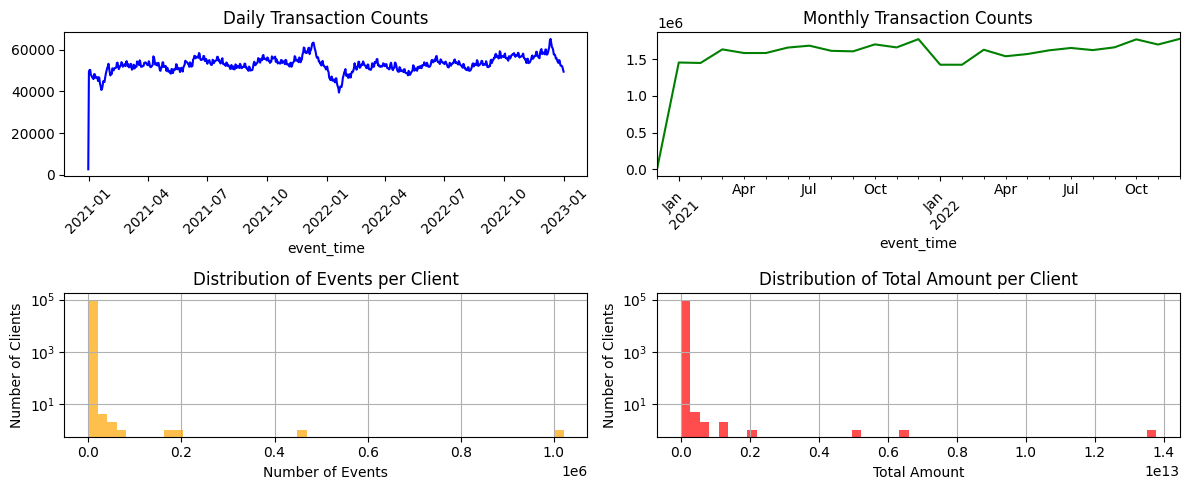

Top 10 clients by total transaction amount:
  Client dcc03690dc8ecc945f7e25a1f6b0515880af4e36ffcbfc160307662d918360e6: $13,773,248,135,168.00
  Client 05ea745b9d26c60cd9a328d7420dcfa526b3eb6557255d265316374ca267733f: $6,556,842,196,992.00
  Client 0e57a93a7030cf99bdba679b479d0b0581e6ef17bc55d72cd7bdfe9440ecade1: $5,006,480,637,952.00
  Client 9162f460905b0c6838d781fb85f47616ae17e06ea3af99c50fd2b3153f2afe33: $1,984,052,068,352.00
  Client 8406df73cfc4d2a3d27c07169fb11895d1852406ac8bd001dde6c19482f55d32: $1,337,198,510,080.00
  Client 89edf6431f1d2782d3f9e2cd6313d63fb6bec7385fcfd166ce62aef7e45c0f25: $1,148,780,019,712.00
  Client 476eed0bb7c8f20ec246600364d03ea7db12614b4f5781a6e51da45d3f6195ff: $659,011,993,600.00
  Client c272a772e94ab00dbb6b0712328c2ad5d50e90e3cf66afb9305e730a2247d07d: $585,459,105,792.00
  Client 627ddb9b19b9a8cc78962bdd398a87871efb4573f7e34f1e56fdd2728fda0c0c: $528,672,718,848.00
  Client 4c3b88e4da82cdf07f972eab32273a2670d81d1c2c1930f06330bdc39873d289: $497,297,260,

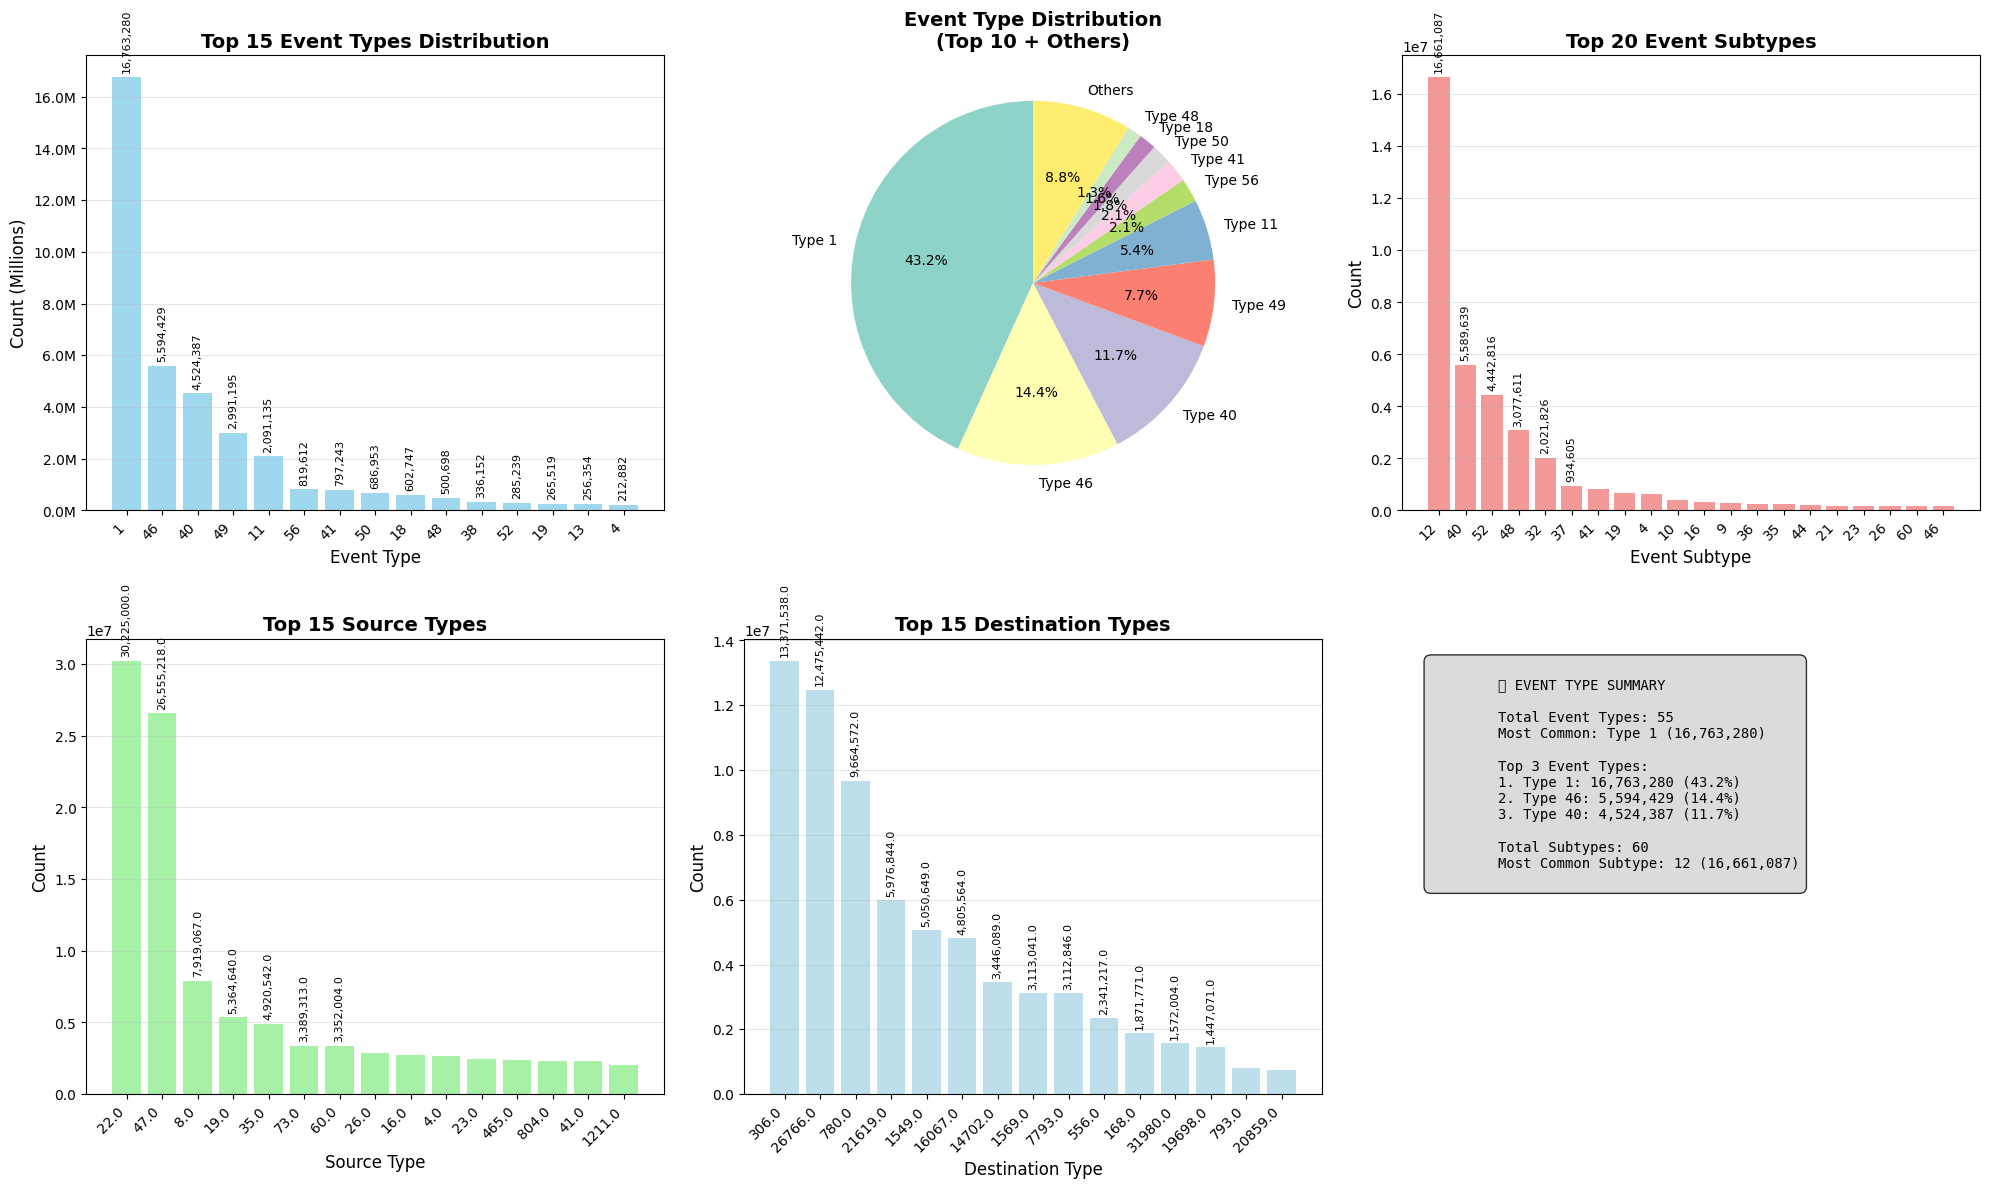


=== SUMMARY STATISTICS ===
Total transactions: 38,764,930
Total unique clients: 98,721
Total unique event types: 55
Total unique event subtypes: 60
Date range: 2020-12-31 21:00:02.169545 to 2022-12-31 20:59:58.460193
Total amount: $50,584,346,427,392.00
Average amount: $1,304,899.75
Median amount: $18,035.84


In [60]:
# Comprehensive Data Loading and Basic EDA
# Load and analyze all folds with comprehensive statistics

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pathlib import Path
    import warnings
    warnings.filterwarnings('ignore')
    
    print("=== COMPREHENSIVE DATA LOADING AND BASIC EDA ===")
    print("Loading and analyzing all folds with comprehensive statistics")
    print()
    
    # Load data from all folds
    all_folds_data = []
    fold_stats = {}
    
    for fold in range(5):  # 0,1,2,3,4
        fold_path = BASE_DIR / f"fold={fold}"
        if fold_path.exists():
            print(f"\n===== Loading fold {fold} =====")
            try:
                df_fold = pd.read_parquet(fold_path)
                print(f"Shape: {df_fold.shape}")
                
                # Convert event_time to datetime
                if 'event_time' in df_fold.columns:
                    df_fold['event_time'] = pd.to_datetime(df_fold['event_time'])
                
                # Store fold data
                all_folds_data.append(df_fold)
                
                # Calculate fold statistics
                fold_stats[fold] = {
                    'shape': df_fold.shape,
                    'clients': df_fold['client_id'].nunique() if 'client_id' in df_fold.columns else 0,
                    'event_types': df_fold['event_type'].nunique() if 'event_type' in df_fold.columns else 0,
                    'date_range': f"{df_fold['event_time'].min()} to {df_fold['event_time'].max()}" if 'event_time' in df_fold.columns else 'N/A'
                }
                
                print(f"Unique clients: {fold_stats[fold]['clients']}")
                print(f"Unique event types: {fold_stats[fold]['event_types']}")
                print(f"Date range: {fold_stats[fold]['date_range']}")
                
            except Exception as e:
                print(f"Error loading fold {fold}: {e}")
        else:
            print(f"Fold {fold} not found at {fold_path}")
    
    if all_folds_data:
        # Combine all folds
        df_combined = pd.concat(all_folds_data, ignore_index=True)
        print(f"\n=== COMBINED DATASET ===")
        print(f"Total shape: {df_combined.shape}")
        print(f"Total unique clients: {df_combined['client_id'].nunique()}")
        print(f"Total unique event types: {df_combined['event_type'].nunique()}")
        print(f"Date range: {df_combined['event_time'].min()} to {df_combined['event_time'].max()}")
        
        # Basic cleaning
        print(f"\n=== DATA CLEANING ===")
        print("Missing values:")
        missing_values = df_combined.isna().sum()
        print(missing_values[missing_values > 0])
        
        # Descriptive statistics
        print(f"\n=== DESCRIPTIVE STATISTICS ===")
        print("Transaction amount stats:")
        print(df_combined['amount'].describe())
        
        print("\nTop currencies:")
        print(df_combined['currency'].value_counts().head(10))
        
        print("\nUnique event types:")
        print(df_combined['event_type'].unique())
        
        print("\nUnique event subtypes (top 20):")
        print(df_combined['event_subtype'].value_counts().head(20))
        
        # Temporal patterns
        print(f"\n=== TEMPORAL PATTERNS ===")
        
        # Daily event counts
        daily_events = df_combined.groupby(df_combined['event_time'].dt.date).size()
        plt.figure(figsize=(15, 8))
        
        plt.subplot(2, 2, 1)
        daily_events.plot(figsize=(12, 5), title="Daily Transaction Counts", color='blue')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Monthly event counts
        monthly_events = df_combined.groupby(df_combined['event_time'].dt.to_period("M")).size()
        plt.subplot(2, 2, 2)
        monthly_events.plot(figsize=(12, 5), title="Monthly Transaction Counts", color='green')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Client-level analysis
        print(f"\n=== CLIENT-LEVEL ANALYSIS ===")
        
        # Distribution: number of events per client
        events_per_client = df_combined.groupby('client_id').size()
        plt.subplot(2, 2, 3)
        events_per_client.hist(bins=50, alpha=0.7, color='orange')
        plt.title("Distribution of Events per Client")
        plt.xlabel("Number of Events")
        plt.ylabel("Number of Clients")
        plt.yscale('log')
        
        # Total transaction amounts per client
        amount_per_client = df_combined.groupby('client_id')['amount'].sum()
        plt.subplot(2, 2, 4)
        amount_per_client.hist(bins=50, alpha=0.7, color='red')
        plt.title("Distribution of Total Amount per Client")
        plt.xlabel("Total Amount")
        plt.ylabel("Number of Clients")
        plt.yscale('log')
        
        plt.tight_layout()
        plt.show()
        
        print("Top 10 clients by total transaction amount:")
        top_clients = amount_per_client.sort_values(ascending=False).head(10)
        for client, amount in top_clients.items():
            print(f"  Client {client}: ${amount:,.2f}")
        
        # Event type analysis
        print(f"\n=== EVENT TYPE ANALYSIS ===")
        
        plt.figure(figsize=(20, 12))
        
        # Event type distribution - IMPROVED READABILITY
        plt.subplot(2, 3, 1)
        event_type_counts = df_combined['event_type'].value_counts()
        
        # Show top 15 event types for better readability
        top_event_types = event_type_counts.head(15)
        bars = plt.bar(range(len(top_event_types)), top_event_types.values, color='skyblue', alpha=0.8)
        plt.title("Top 15 Event Types Distribution", fontsize=14, fontweight='bold')
        plt.xlabel("Event Type", fontsize=12)
        plt.ylabel("Count (Millions)", fontsize=12)
        plt.xticks(range(len(top_event_types)), top_event_types.index, rotation=45, ha='right')
        
        # Add value labels on top of bars
        for i, (bar, value) in enumerate(zip(bars, top_event_types.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(top_event_types.values)*0.01, 
                    f'{value:,}', ha='center', va='bottom', fontsize=8, rotation=90)
        
        # Format y-axis to show millions
        ax = plt.gca()
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
        plt.grid(True, alpha=0.3, axis='y')
        
        # Event type pie chart for top 10
        plt.subplot(2, 3, 2)
        top_10_types = event_type_counts.head(10)
        others_count = event_type_counts.iloc[10:].sum()
        
        pie_data = list(top_10_types.values) + [others_count]
        pie_labels = [f'Type {x}' for x in top_10_types.index] + ['Others']
        colors = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))
        
        wedges, texts, autotexts = plt.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
                                          colors=colors, startangle=90)
        plt.title("Event Type Distribution\n(Top 10 + Others)", fontsize=14, fontweight='bold')
        
        # Event subtype distribution - IMPROVED
        plt.subplot(2, 3, 3)
        subtype_counts = df_combined['event_subtype'].value_counts().head(20)
        bars = plt.bar(range(len(subtype_counts)), subtype_counts.values, color='lightcoral', alpha=0.8)
        plt.title("Top 20 Event Subtypes", fontsize=14, fontweight='bold')
        plt.xlabel("Event Subtype", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(range(len(subtype_counts)), subtype_counts.index, rotation=45, ha='right')
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, subtype_counts.values)):
            if value > max(subtype_counts.values) * 0.05:  # Only show labels for significant values
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(subtype_counts.values)*0.01, 
                        f'{value:,}', ha='center', va='bottom', fontsize=8, rotation=90)
        
        plt.grid(True, alpha=0.3, axis='y')
        
        # Source/Destination type analysis (memory-safe)
        print(f"\n=== SOURCE/DESTINATION TYPE ANALYSIS ===")
        
        # Count values for each source column individually
        src_cols = ['src_type11', 'src_type12', 'src_type21', 'src_type22', 'src_type31', 'src_type32']
        src_counts = pd.Series(dtype="int64")
        
        for col in src_cols:
            if col in df_combined.columns:
                counts = df_combined[col].value_counts(dropna=True)
                src_counts = src_counts.add(counts, fill_value=0)
        
        src_counts = src_counts.sort_values(ascending=False)
        print("Top source types:")
        print(src_counts.head(10))
        
        # Count values for each destination column individually
        dst_cols = ['dst_type11', 'dst_type12']
        dst_counts = pd.Series(dtype="int64")
        
        for col in dst_cols:
            if col in df_combined.columns:
                counts = df_combined[col].value_counts(dropna=True)
                dst_counts = dst_counts.add(counts, fill_value=0)
        
        dst_counts = dst_counts.sort_values(ascending=False)
        print("\nTop destination types:")
        print(dst_counts.head(10))
        
        # Visualize source and destination types - IMPROVED
        plt.subplot(2, 3, 4)
        top_src = src_counts.head(15)
        bars = plt.bar(range(len(top_src)), top_src.values, color='lightgreen', alpha=0.8)
        plt.title('Top 15 Source Types', fontsize=14, fontweight='bold')
        plt.xlabel('Source Type', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(range(len(top_src)), top_src.index, rotation=45, ha='right')
        
        # Add value labels for significant bars
        for i, (bar, value) in enumerate(zip(bars, top_src.values)):
            if value > max(top_src.values) * 0.1:  # Only show labels for top 10%
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(top_src.values)*0.01, 
                        f'{value:,}', ha='center', va='bottom', fontsize=8, rotation=90)
        
        plt.grid(True, alpha=0.3, axis='y')
        
        plt.subplot(2, 3, 5)
        top_dst = dst_counts.head(15)
        bars = plt.bar(range(len(top_dst)), top_dst.values, color='lightblue', alpha=0.8)
        plt.title('Top 15 Destination Types', fontsize=14, fontweight='bold')
        plt.xlabel('Destination Type', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(range(len(top_dst)), top_dst.index, rotation=45, ha='right')
        
        # Add value labels for significant bars
        for i, (bar, value) in enumerate(zip(bars, top_dst.values)):
            if value > max(top_dst.values) * 0.1:  # Only show labels for top 10%
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(top_dst.values)*0.01, 
                        f'{value:,}', ha='center', va='bottom', fontsize=8, rotation=90)
        
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add a summary statistics panel
        plt.subplot(2, 3, 6)
        plt.axis('off')
        
        # Create summary text
        summary_text = f"""
        📊 EVENT TYPE SUMMARY
        
        Total Event Types: {len(event_type_counts):,}
        Most Common: Type {event_type_counts.index[0]} ({event_type_counts.iloc[0]:,})
        
        Top 3 Event Types:
        1. Type {event_type_counts.index[0]}: {event_type_counts.iloc[0]:,} ({event_type_counts.iloc[0]/len(df_combined)*100:.1f}%)
        2. Type {event_type_counts.index[1]}: {event_type_counts.iloc[1]:,} ({event_type_counts.iloc[1]/len(df_combined)*100:.1f}%)
        3. Type {event_type_counts.index[2]}: {event_type_counts.iloc[2]:,} ({event_type_counts.iloc[2]/len(df_combined)*100:.1f}%)
        
        Total Subtypes: {len(df_combined['event_subtype'].unique()):,}
        Most Common Subtype: {df_combined['event_subtype'].value_counts().index[0]} ({df_combined['event_subtype'].value_counts().iloc[0]:,})
        """
        
        plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\n=== SUMMARY STATISTICS ===")
        print(f"Total transactions: {len(df_combined):,}")
        print(f"Total unique clients: {df_combined['client_id'].nunique():,}")
        print(f"Total unique event types: {df_combined['event_type'].nunique():,}")
        print(f"Total unique event subtypes: {df_combined['event_subtype'].nunique():,}")
        print(f"Date range: {df_combined['event_time'].min()} to {df_combined['event_time'].max()}")
        print(f"Total amount: ${df_combined['amount'].sum():,.2f}")
        print(f"Average amount: ${df_combined['amount'].mean():,.2f}")
        print(f"Median amount: ${df_combined['amount'].median():,.2f}")
        
        # Store combined data for other analyses
        globals()['df_combined'] = df_combined
        
    else:
        print("No data loaded from any fold")
        
except ImportError as e:
    print(f"Required libraries not available: {e}")
    print("Install required packages: pip install pandas numpy matplotlib seaborn")
except Exception as e:
    print(f"Error in comprehensive data loading: {e}")
    import traceback
    traceback.print_exc()


=== DIALOG DATA ANALYSIS ===
Analyzing dialog data to understand client communication patterns

Loading dialog data from data/detail/dialog/fold=2
Dialog data shape: (43737, 3)
Dialog data columns: ['client_id', 'event_time', 'embedding']

First 10 rows:
                                           client_id  \
0  30e52cd99b1e0be70daf39de04222ef50c5f047e489ae6...   
1  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   
2  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   
3  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   
4  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   
5  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   
6  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   
7  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   
8  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   
9  3e46138c81f409ce1700258ff5de774c2aeb89c08e48e1...   

                  event_time  \
0 2022-04-20 09:38:26.438243   
1 2021-08-31 07:43:56.958460   
2 2021-09-11 06:28:42.030060   


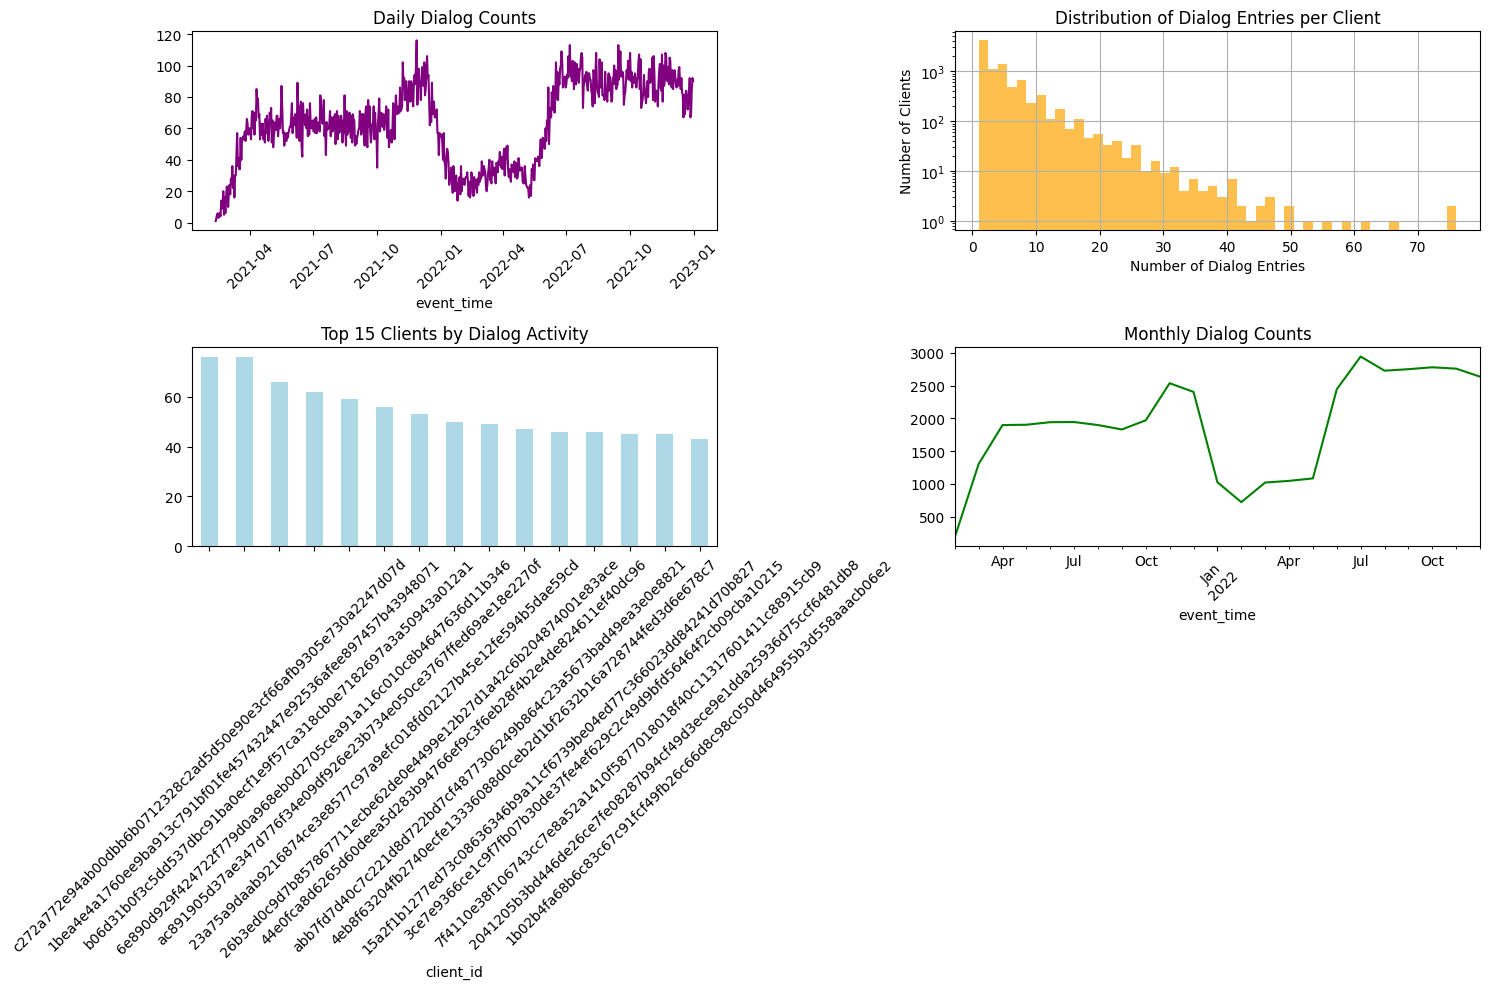


=== DIALOG SUMMARY STATISTICS ===
Total dialog entries: 43,737
Unique clients: 9,217
Unique dates: 43,737
Average dialog entries per client: 4.75
Date range: 2021-02-10 10:38:40.931712 to 2022-12-31 19:39:31.001870

Top 10 clients by dialog activity:
  Client c272a772e94ab00dbb6b0712328c2ad5d50e90e3cf66afb9305e730a2247d07d: 76 dialog entries
  Client 1bea4e4a1760ee9ba913c791bf01fe457432447e92536afee897457b43948071: 76 dialog entries
  Client b06d31b0f3c5dd537dbc91ba0ecf1e9f57ca318cb0e7182697a3a50943a012a1: 66 dialog entries
  Client 6e890d929f424722f779d0a968eb0d2705cea91a116c010c8b4647636d11b346: 62 dialog entries
  Client ac891905d37ae347d776f34e09df926e23b734e050ce3767ffed69ae18e2270f: 59 dialog entries
  Client 23a75a9daab9216874ce3e8577c97a9efc018fd02127b45e12fe594b5dae59cd: 56 dialog entries
  Client 26b3ed0c9d7b857867711ecbe62de0e4499e12b27d1a42c6b204874001e83ace: 53 dialog entries
  Client 44e0fca8d6265d60deea5d283b94766ef9c3f6eb28f4b2e4de824611ef40dc96: 50 dialog entries
  Cl

In [ ]:
# Dialog Data Analysis
# Analyze dialog data from fold=2 to understand client communication patterns

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pathlib import Path
    import warnings
    warnings.filterwarnings('ignore')
    
    print("=== DIALOG DATA ANALYSIS ===")
    print("Analyzing dialog data to understand client communication patterns")
    print()
    
    # Load dialog data from fold=2
    dialog_path = Path("data/detail/dialog/fold=2")
    
    if dialog_path.exists():
        print(f"Loading dialog data from {dialog_path}")
        try:
            df_dialog = pd.read_parquet(dialog_path)
            print(f"Dialog data shape: {df_dialog.shape}")
            print(f"Dialog data columns: {list(df_dialog.columns)}")
            print(f"\nFirst 10 rows:")
            print(df_dialog.head(10))
            
            # Basic dialog analysis
            print(f"\n=== DIALOG DATA STATISTICS ===")
            
            # Number of unique clients in dialog data
            n_clients_dialog = df_dialog['client_id'].nunique()
            print(f"Number of unique clients in dialog data: {n_clients_dialog}")
            
            # Show some client IDs
            print(f"Sample client IDs: {df_dialog['client_id'].unique()[:10]}")
            
            # Analyze a specific client
            if len(df_dialog) > 0:
                client_1 = df_dialog['client_id'].unique()[0]
                print(f"\nAnalysis for client {client_1}:")
                client_data = df_dialog[df_dialog['client_id'] == client_1]
                print(f"Number of dialog entries for this client: {len(client_data)}")
                print(f"Client data shape: {client_data.shape}")
                print(f"Client data columns: {list(client_data.columns)}")
                
                # Show the client's dialog data
                print(f"\nDialog entries for client {client_1}:")
                print(client_data)
            
            # Temporal analysis of dialog data
            if 'event_time' in df_dialog.columns:
                # Convert event_time to datetime if needed
                if not pd.api.types.is_datetime64_any_dtype(df_dialog['event_time']):
                    df_dialog['event_time'] = pd.to_datetime(df_dialog['event_time'])
                
                # Number of unique dates in dialog data
                n_dates_dialog = df_dialog['event_time'].nunique()
                print(f"\nNumber of unique dates in dialog data: {n_dates_dialog}")
                
                # Show some dates
                print(f"Sample dates: {df_dialog['event_time'].unique()[:20]}")
                
                # Date range
                print(f"Date range: {df_dialog['event_time'].min()} to {df_dialog['event_time'].max()}")
                
                # Daily dialog counts
                daily_dialog = df_dialog.groupby(df_dialog['event_time'].dt.date).size()
                
                # Visualize dialog patterns
                plt.figure(figsize=(15, 10))
                
                # Daily dialog counts
                plt.subplot(2, 2, 1)
                daily_dialog.plot(title="Daily Dialog Counts", color='purple')
                plt.xticks(rotation=45)
                plt.tight_layout()
                
                # Dialog distribution by client - IMPROVED
                plt.subplot(2, 2, 2)
                dialog_per_client = df_dialog.groupby('client_id').size()
                
                # Create histogram with better formatting
                n, bins, patches = plt.hist(dialog_per_client, bins=50, alpha=0.7, color='orange', edgecolor='black', linewidth=0.5)
                plt.title("Distribution of Dialog Entries per Client", fontsize=14, fontweight='bold')
                plt.xlabel("Number of Dialog Entries", fontsize=12)
                plt.ylabel("Number of Clients (Log Scale)", fontsize=12)
                plt.yscale('log')
                plt.grid(True, alpha=0.3, axis='y')
                
                # Add statistics text
                stats_text = f"""
                📊 Dialog Statistics:
                • Total Clients: {len(dialog_per_client):,}
                • Avg per Client: {dialog_per_client.mean():.1f}
                • Median: {dialog_per_client.median():.1f}
                • Max: {dialog_per_client.max():,}
                """
                plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                        fontsize=9, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
                
                # Top clients by dialog activity - IMPROVED LABELS
                plt.subplot(2, 2, 3)
                top_dialog_clients = dialog_per_client.sort_values(ascending=False).head(15)
                
                # Create simplified labels (first 8 chars + last 4 chars)
                simplified_labels = []
                for client_id in top_dialog_clients.index:
                    if len(str(client_id)) > 12:
                        simplified_labels.append(f"{str(client_id)[:8]}...{str(client_id)[-4:]}")
                    else:
                        simplified_labels.append(str(client_id))
                
                # Create the bar chart
                bars = plt.bar(range(len(top_dialog_clients)), top_dialog_clients.values, color='lightblue', alpha=0.8)
                plt.title("Top 15 Clients by Dialog Activity", fontsize=14, fontweight='bold')
                plt.xlabel("Client ID (Simplified)", fontsize=12)
                plt.ylabel("Dialog Count", fontsize=12)
                
                # Use simplified labels
                plt.xticks(range(len(top_dialog_clients)), simplified_labels, rotation=45, ha='right', fontsize=8)
                
                # Add value labels on top of bars
                for i, (bar, value) in enumerate(zip(bars, top_dialog_clients.values)):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                            f'{value}', ha='center', va='bottom', fontsize=8, fontweight='bold')
                
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                
                # Dialog activity over time
                plt.subplot(2, 2, 4)
                monthly_dialog = df_dialog.groupby(df_dialog['event_time'].dt.to_period("M")).size()
                monthly_dialog.plot(title="Monthly Dialog Counts", color='green')
                plt.xticks(rotation=45)
                plt.tight_layout()
                
                plt.tight_layout()
                plt.show()
                
                # Summary statistics
                print(f"\n=== DIALOG SUMMARY STATISTICS ===")
                print(f"Total dialog entries: {len(df_dialog):,}")
                print(f"Unique clients: {n_clients_dialog:,}")
                print(f"Unique dates: {n_dates_dialog:,}")
                print(f"Average dialog entries per client: {len(df_dialog) / n_clients_dialog:.2f}")
                print(f"Date range: {df_dialog['event_time'].min()} to {df_dialog['event_time'].max()}")
                
                # Top clients by dialog activity
                print(f"\nTop 10 clients by dialog activity:")
                for client, count in top_dialog_clients.head(10).items():
                    print(f"  Client {client}: {count} dialog entries")
            
            else:
                print("No 'event_time' column found in dialog data")
                print(f"Available columns: {list(df_dialog.columns)}")
            
            # Store dialog data for potential cross-analysis
            globals()['df_dialog'] = df_dialog
            
        except Exception as e:
            print(f"Error loading dialog data: {e}")
    else:
        print(f"Dialog data not found at {dialog_path}")
        print("Available directories:")
        detail_path = Path("data/detail")
        if detail_path.exists():
            for item in detail_path.iterdir():
                if item.is_dir():
                    print(f"  - {item.name}")
        
except ImportError as e:
    print(f"Required libraries not available: {e}")
    print("Install required packages: pip install pandas numpy matplotlib seaborn")
except Exception as e:
    print(f"Error in dialog data analysis: {e}")
    import traceback
    traceback.print_exc()


## Statistical Analysis

Let's dive deeper into the statistical properties of our transaction data, including amount distributions and categorical field analysis.


In [54]:
# Distributions and Cardinalities Analysis
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
from pathlib import Path
import pandas as pd
import numpy as np

print("=== DISTRIBUTIONS AND CARDINALITIES ANALYSIS ===")
print("Analyzing amount distributions and categorical field cardinalities...")

# Discover files
if 'fold_dirs' not in globals() or not fold_dirs:
    fold_dirs = sorted([p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith('fold=')], key=lambda p: p.name)
all_files = [f for d in fold_dirs for f in sorted(d.glob('*.parquet'))]

if not all_files:
    print('No parquet files found.')
else:
    # Sample size for statistical analysis
    sample_size = 100_000
    sample_data = []
    
    print(f'Collecting {sample_size:,} samples for statistical analysis...')
    
    # Process first few files for sampling
    for i, f in enumerate(all_files[:5]):  # Limit to first 5 files for speed
        if len(sample_data) >= sample_size:
            break
            
        try:
            pf = pq.ParquetFile(str(f))
            if pf.metadata.num_row_groups > 0:
                # Read first row group
                table = pf.read_row_group(0)
                if table.num_rows > 0:
                    df_sample = table.to_pandas()
                    
                    # Sample if too large
                    if len(df_sample) > (sample_size - len(sample_data)):
                        needed = sample_size - len(sample_data)
                        df_sample = df_sample.sample(n=needed, random_state=42)
                    
                    sample_data.append(df_sample)
                    print(f'  Processed {f.name}: {len(df_sample):,} rows')
                
        except Exception as e:
            print(f'  Warning: Failed to process {f.name}: {e}')
            continue
    
    if sample_data:
        df_stats = pd.concat(sample_data, ignore_index=True)
        print(f'\nCollected {len(df_stats):,} samples for analysis')
        
        # Amount statistics
        if 'amount' in df_stats.columns:
            amounts = df_stats['amount'].dropna()
            print(f'\n=== AMOUNT STATISTICS ===')
            print(f'Count: {len(amounts):,}')
            print(f'Mean: ${amounts.mean():.2f}')
            print(f'Median: ${amounts.median():.2f}')
            print(f'Std: ${amounts.std():.2f}')
            print(f'Min: ${amounts.min():.2f}')
            print(f'Max: ${amounts.max():.2f}')
            print(f'25th percentile: ${amounts.quantile(0.25):.2f}')
            print(f'75th percentile: ${amounts.quantile(0.75):.2f}')
            print(f'95th percentile: ${amounts.quantile(0.95):.2f}')
            print(f'99th percentile: ${amounts.quantile(0.99):.2f}')
        
        # Categorical field analysis
        print(f'\n=== CATEGORICAL FIELD ANALYSIS ===')
        categorical_cols = ['event_type', 'event_subtype', 'currency']
        
        for col in categorical_cols:
            if col in df_stats.columns:
                unique_count = df_stats[col].nunique()
                print(f'{col}: {unique_count} unique values')
                
                # Show top values
                top_values = df_stats[col].value_counts().head(5)
                print(f'  Top values:')
                for value, count in top_values.items():
                    print(f'    {value}: {count:,} ({count/len(df_stats)*100:.1f}%)')
                print()
        
        print(f'✓ Statistical analysis complete')
    else:
        print('No sample data collected for analysis')


=== DISTRIBUTIONS AND CARDINALITIES ANALYSIS ===
Analyzing amount distributions and categorical field cardinalities...
  Processed part-00001-f1f2463d-80e2-4335-8981-4fc9e73f56f4.c000.snappy.parquet: 7,885 rows
  Processed part-00085-f1f2463d-80e2-4335-8981-4fc9e73f56f4.c000.snappy.parquet: 11,960 rows
  Processed part-00086-f1f2463d-80e2-4335-8981-4fc9e73f56f4.c000.snappy.parquet: 18,461 rows
  Processed part-00087-f1f2463d-80e2-4335-8981-4fc9e73f56f4.c000.snappy.parquet: 63,080 rows
  Processed part-00088-f1f2463d-80e2-4335-8981-4fc9e73f56f4.c000.snappy.parquet: 99,996 rows

Collected 201,382 samples for analysis

=== AMOUNT STATISTICS ===
Count: 201,382
Mean: $245203.88
Median: $7128.30
Std: $9158545.00
Min: $0.00
Max: $3553163520.00
25th percentile: $1584.07
75th percentile: $48642.07
95th percentile: $567821.27
99th percentile: $3247301.37

=== CATEGORICAL FIELD ANALYSIS ===
event_type: 50 unique values
  Top values:
    1: 116,168 (57.7%)
    46: 20,074 (10.0%)
    40: 16,817 (8.

### Amount Distribution Visualizations

Let's create visualizations to better understand the distribution of transaction amounts.


=== AMOUNT DISTRIBUTION PLOTS ===
Reusing existing sample_amounts: n=38,306


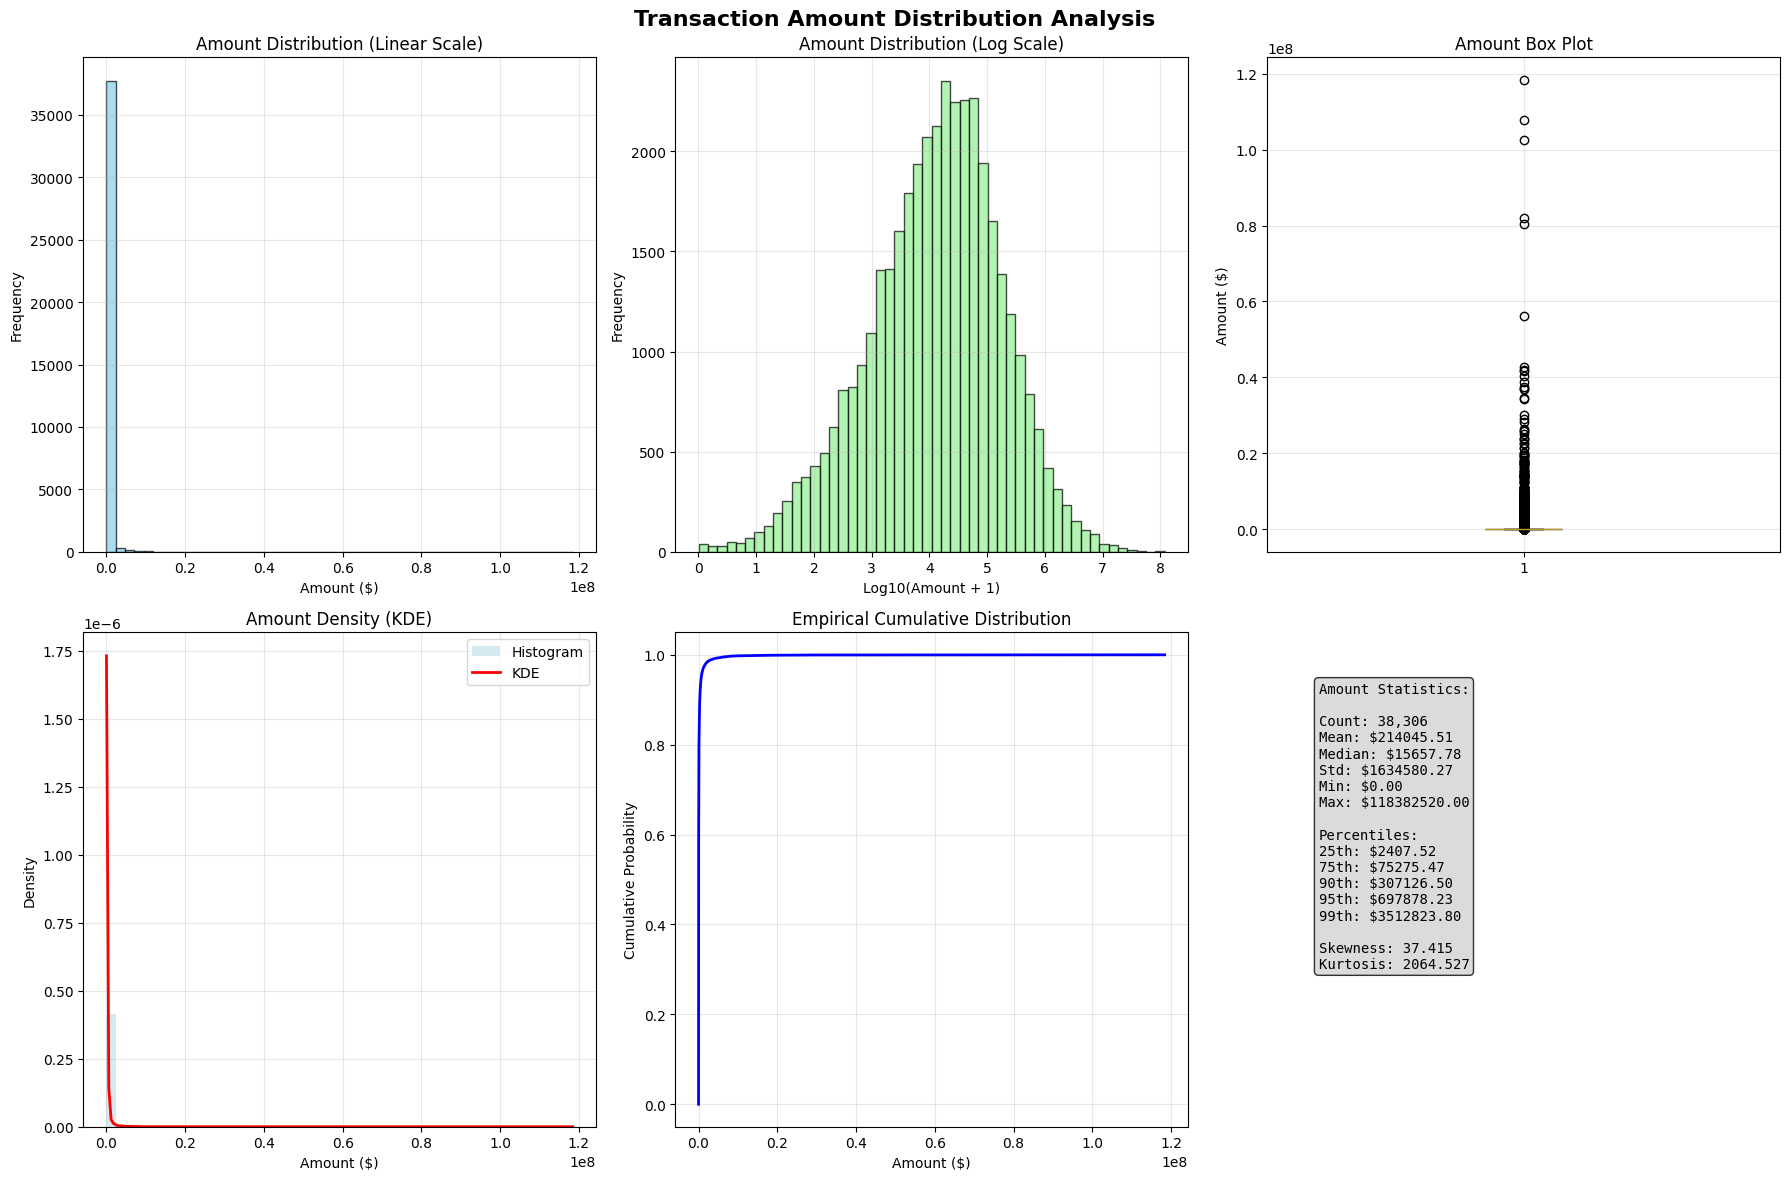

✓ Amount distribution analysis complete
✓ Sample size: 38,306 transactions
✓ Amount range: $0.00 - $118382520.00
✓ Mean amount: $214045.51


In [55]:
# Amount Distribution Plots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use('default')
sns.set_palette('husl')

print('=== AMOUNT DISTRIBUTION PLOTS ===')

# Reuse sample_amounts if already computed; otherwise build a sample
if 'sample_amounts' in locals() and isinstance(sample_amounts, (list, np.ndarray)) and len(sample_amounts) > 0:
    amt = np.array(sample_amounts, dtype=float)
    print(f'Reusing existing sample_amounts: n={len(amt):,}')
else:
    print('Building a fresh sample of amounts (up to 100,000 values)...')
    from pyarrow import parquet as pq
    
    sample_amounts = []
    sample_size = 100_000
    
    # Process first few files
    for i, f in enumerate(all_files[:3]):
        if len(sample_amounts) >= sample_size:
            break
        try:
            pf = pq.ParquetFile(str(f))
            if pf.metadata.num_row_groups > 0:
                table = pf.read_row_group(0, columns=['amount'])
                if table.num_rows > 0:
                    amounts = table.to_pandas()['amount'].dropna()
                    sample_amounts.extend(amounts.tolist())
                    if len(sample_amounts) >= sample_size:
                        sample_amounts = sample_amounts[:sample_size]
                        break
        except Exception as e:
            print(f'  Warning: Failed to process {f.name}: {e}')
            continue
    
    amt = np.array(sample_amounts, dtype=float)
    print(f'Collected {len(amt):,} amount values')

if len(amt) > 0:
    # Create comprehensive amount distribution plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Transaction Amount Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Linear histogram
    axes[0, 0].hist(amt, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Amount Distribution (Linear Scale)')
    axes[0, 0].set_xlabel('Amount ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Log histogram
    log_amt = np.log10(amt + 1)  # +1 to handle zeros
    axes[0, 1].hist(log_amt, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Amount Distribution (Log Scale)')
    axes[0, 1].set_xlabel('Log10(Amount + 1)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Box plot
    axes[0, 2].boxplot(amt, vert=True, patch_artist=True, 
                       boxprops=dict(facecolor='lightcoral', alpha=0.7))
    axes[0, 2].set_title('Amount Box Plot')
    axes[0, 2].set_ylabel('Amount ($)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. KDE plot
    axes[1, 0].hist(amt, bins=50, density=True, alpha=0.5, color='lightblue', label='Histogram')
    # Add KDE
    from scipy import stats
    kde = stats.gaussian_kde(amt)
    x_range = np.linspace(amt.min(), amt.max(), 200)
    axes[1, 0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    axes[1, 0].set_title('Amount Density (KDE)')
    axes[1, 0].set_xlabel('Amount ($)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. ECDF plot
    sorted_amt = np.sort(amt)
    y = np.arange(1, len(sorted_amt) + 1) / len(sorted_amt)
    axes[1, 1].plot(sorted_amt, y, 'b-', linewidth=2)
    axes[1, 1].set_title('Empirical Cumulative Distribution')
    axes[1, 1].set_xlabel('Amount ($)')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Summary statistics
    axes[1, 2].axis('off')
    stats_text = f'''Amount Statistics:
    
Count: {len(amt):,}
Mean: ${amt.mean():.2f}
Median: ${np.median(amt):.2f}
Std: ${amt.std():.2f}
Min: ${amt.min():.2f}
Max: ${amt.max():.2f}

Percentiles:
25th: ${np.percentile(amt, 25):.2f}
75th: ${np.percentile(amt, 75):.2f}
90th: ${np.percentile(amt, 90):.2f}
95th: ${np.percentile(amt, 95):.2f}
99th: ${np.percentile(amt, 99):.2f}

Skewness: {stats.skew(amt):.3f}
Kurtosis: {stats.kurtosis(amt):.3f}'''
    
    axes[1, 2].text(0.1, 0.9, stats_text, transform=axes[1, 2].transAxes, 
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f'✓ Amount distribution analysis complete')
    print(f'✓ Sample size: {len(amt):,} transactions')
    print(f'✓ Amount range: ${amt.min():.2f} - ${amt.max():.2f}')
    print(f'✓ Mean amount: ${amt.mean():.2f}')
    
else:
    print('No amount data available for visualization')


## Client Behavior Analysis

Let's analyze client-level patterns to understand how individual clients behave and their transaction patterns.


In [56]:
# Client-level Profile: Events per client and activity window
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from collections import defaultdict

print('=== CLIENT-LEVEL PROFILE ===')

# Discover files
if 'fold_dirs' not in globals() or not fold_dirs:
    fold_dirs = sorted([p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith('fold=')], key=lambda p: p.name)
all_files = [f for d in fold_dirs for f in sorted(d.glob('*.parquet'))]

if not all_files:
    print('No parquet files found.')
else:
    # Global aggregators
    client_counts = defaultdict(int)
    client_first = {}
    client_last = {}
    total_rows_processed = 0
    
    print(f'Processing {len(all_files)} files for client analysis...')
    
    # Process files for client-level analysis
    for i, f in enumerate(all_files):
        if i % 50 == 0:
            print(f'  Processed {i}/{len(all_files)} files...')
            
        try:
            pf = pq.ParquetFile(str(f))
            # Read client_id and event_time columns
            table = pf.read(columns=['client_id', 'event_time'])
            
            if table.num_rows > 0:
                df_client = table.to_pandas()
                df_client['event_time'] = pd.to_datetime(df_client['event_time'])
                
                # Count events per client
                for client_id in df_client['client_id']:
                    client_counts[client_id] += 1
                
                # Track first and last activity per client
                for _, row in df_client.iterrows():
                    client_id = row['client_id']
                    event_time = row['event_time']
                    
                    if client_id not in client_first or event_time < client_first[client_id]:
                        client_first[client_id] = event_time
                    if client_id not in client_last or event_time > client_last[client_id]:
                        client_last[client_id] = event_time
                
                total_rows_processed += len(df_client)
                
        except Exception as e:
            print(f'  Warning: Failed to process {f.name}: {e}')
            continue
    
    # Analyze client behavior
    if client_counts:
        counts_array = np.array(list(client_counts.values()))
        
        print(f'\n=== CLIENT BEHAVIOR ANALYSIS ===')
        print(f'Total unique clients: {len(client_counts):,}')
        print(f'Total transactions processed: {total_rows_processed:,}')
        print(f'Average transactions per client: {counts_array.mean():.1f}')
        
        print(f'\n=== TRANSACTIONS PER CLIENT STATISTICS ===')
        print(f'Min: {counts_array.min():,}')
        print(f'25th percentile: {np.percentile(counts_array, 25):.0f}')
        print(f'Median: {np.median(counts_array):.0f}')
        print(f'75th percentile: {np.percentile(counts_array, 75):.0f}')
        print(f'95th percentile: {np.percentile(counts_array, 95):.0f}')
        print(f'99th percentile: {np.percentile(counts_array, 99):.0f}')
        print(f'Max: {counts_array.max():,}')
        
        # Client activity span analysis
        if client_first and client_last:
            activity_spans = []
            for client_id in client_first:
                if client_id in client_last:
                    span = (client_last[client_id] - client_first[client_id]).days
                    activity_spans.append(span)
            
            if activity_spans:
                spans_array = np.array(activity_spans)
                print(f'\n=== CLIENT ACTIVITY SPAN ANALYSIS ===')
                print(f'Average activity span: {spans_array.mean():.1f} days')
                print(f'Median activity span: {np.median(spans_array):.1f} days')
                print(f'Max activity span: {spans_array.max():,} days')
                print(f'Clients with >30 day span: {(spans_array > 30).sum():,} ({(spans_array > 30).mean()*100:.1f}%)')
                print(f'Clients with >90 day span: {(spans_array > 90).sum():,} ({(spans_array > 90).mean()*100:.1f}%)')
        
        # Client segmentation
        print(f'\n=== CLIENT SEGMENTATION ===')
        low_activity = (counts_array <= 10).sum()
        medium_activity = ((counts_array > 10) & (counts_array <= 100)).sum()
        high_activity = (counts_array > 100).sum()
        
        print(f'Low activity clients (≤10 transactions): {low_activity:,} ({low_activity/len(counts_array)*100:.1f}%)')
        print(f'Medium activity clients (11-100 transactions): {medium_activity:,} ({medium_activity/len(counts_array)*100:.1f}%)')
        print(f'High activity clients (>100 transactions): {high_activity:,} ({high_activity/len(counts_array)*100:.1f}%)')
        
        print(f'\n✓ Client behavior analysis complete')
        print(f'✓ Analyzed {len(client_counts):,} unique clients')
        print(f'✓ Total transactions: {total_rows_processed:,}')
        
    else:
        print('No client data found for analysis')


=== CLIENT-LEVEL PROFILE ===
Processing 400 files for client analysis...
  Processed 0/400 files...
  Processed 50/400 files...
  Processed 100/400 files...
  Processed 150/400 files...
  Processed 200/400 files...
  Processed 250/400 files...
  Processed 300/400 files...
  Processed 350/400 files...

=== CLIENT BEHAVIOR ANALYSIS ===
Total unique clients: 98,721
Total transactions processed: 38,764,930
Average transactions per client: 392.7

=== TRANSACTIONS PER CLIENT STATISTICS ===
Min: 1
25th percentile: 41
Median: 170
75th percentile: 511
95th percentile: 1387
99th percentile: 2243
Max: 1,020,773

=== CLIENT ACTIVITY SPAN ANALYSIS ===
Average activity span: 594.6 days
Median activity span: 715.0 days
Max activity span: 729 days
Clients with >30 day span: 95,058 (96.3%)
Clients with >90 day span: 92,314 (93.5%)

=== CLIENT SEGMENTATION ===
Low activity clients (≤10 transactions): 11,054 (11.2%)
Medium activity clients (11-100 transactions): 28,327 (28.7%)
High activity clients (>100

### Business Intelligence Visualizations

Let's create visualizations that provide business insights into transaction patterns and client behavior.


=== PROBLEM-ORIENTED VISUALIZATIONS ===


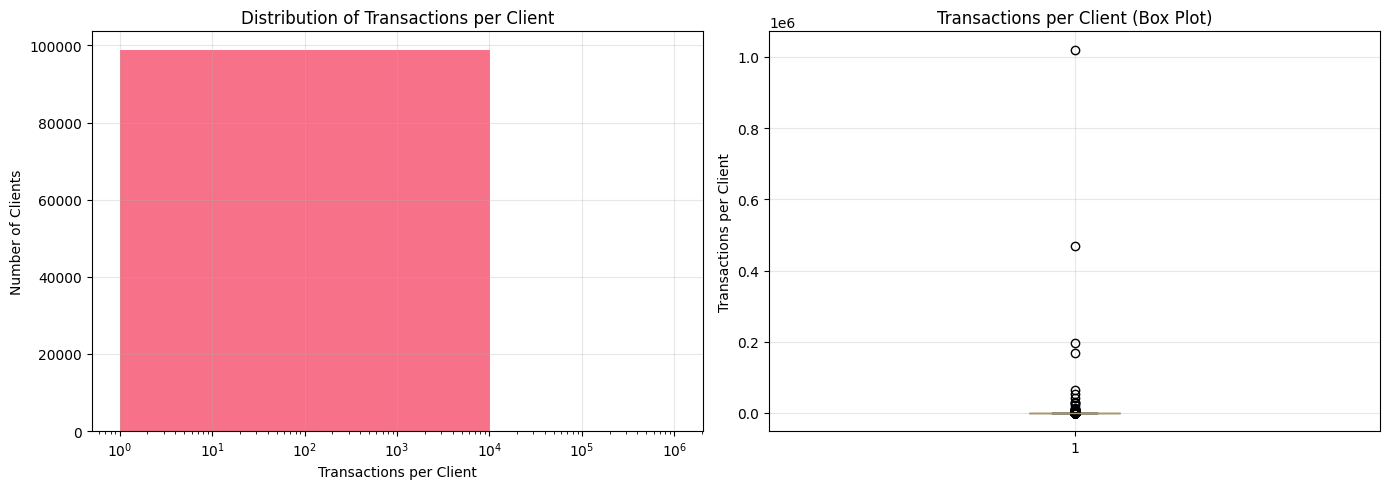

✓ Client transaction distribution plotted

Creating temporal activity heatmap...


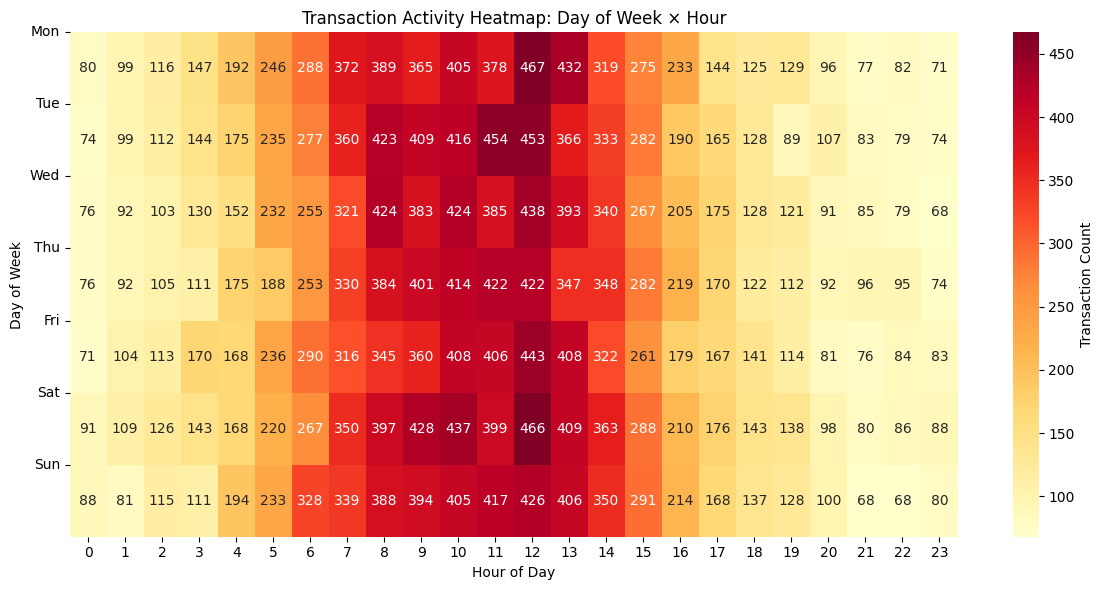

✓ Temporal activity heatmap created

Creating amount by event type analysis...


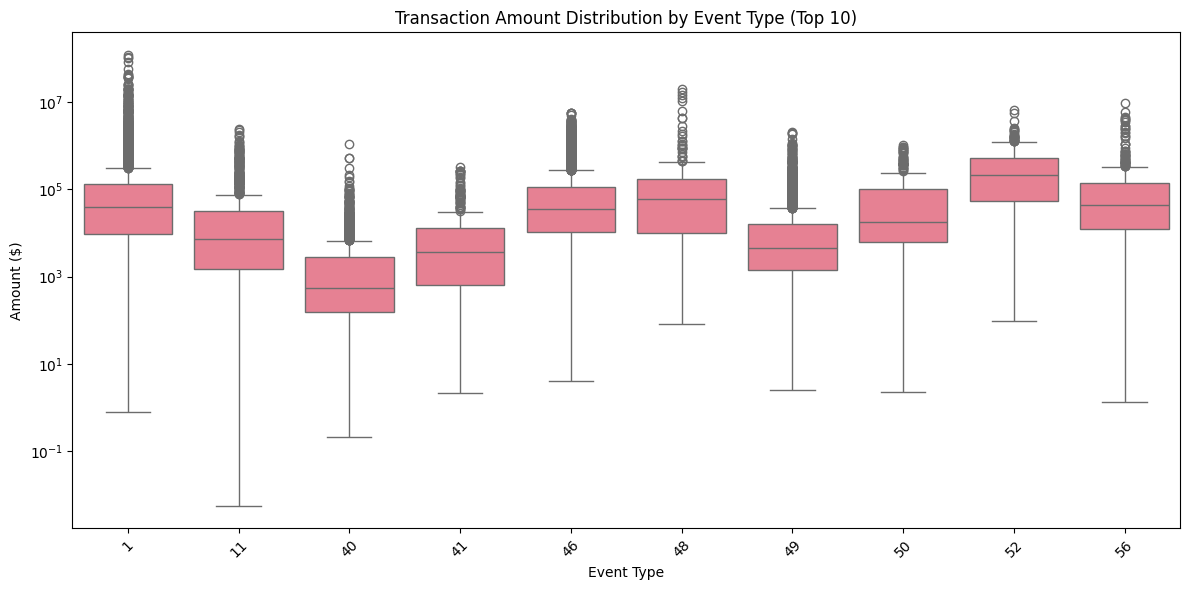

✓ Amount by event type analysis completed

=== BUSINESS INTELLIGENCE SUMMARY ===
✓ Client behavior patterns analyzed
✓ Temporal activity patterns visualized
✓ Transaction amount patterns by event type
✓ Business insights ready for decision making


In [57]:
# Problem-oriented Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

plt.style.use('default')
sns.set_palette('husl')

print('=== PROBLEM-ORIENTED VISUALIZATIONS ===')

# 1) Events per client distribution (uses client_counts from prior cell if available)
if 'client_counts' in locals() and len(client_counts) > 0:
    counts_array = np.fromiter(client_counts.values(), dtype=np.int64)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram on log-scale x
    ax[0].hist(counts_array, bins=100)
    ax[0].set_xlabel('Transactions per Client')
    ax[0].set_ylabel('Number of Clients')
    ax[0].set_title('Distribution of Transactions per Client')
    ax[0].set_xscale('log')
    ax[0].grid(True, alpha=0.3)
    
    # Box plot
    ax[1].boxplot(counts_array, vert=True, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7))
    ax[1].set_ylabel('Transactions per Client')
    ax[1].set_title('Transactions per Client (Box Plot)')
    ax[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f'✓ Client transaction distribution plotted')
else:
    print('⚠️ Client counts not available - run client analysis first')

# 2) Day of week × Hour heatmap
print('\nCreating temporal activity heatmap...')
try:
    # Sample data for heatmap
    sample_data = []
    sample_size = 50_000
    
    for i, f in enumerate(all_files[:3]):
        if len(sample_data) >= sample_size:
            break
        try:
            pf = pq.ParquetFile(str(f))
            if pf.metadata.num_row_groups > 0:
                table = pf.read_row_group(0, columns=['event_time'])
                if table.num_rows > 0:
                    df_temp = table.to_pandas()
                    df_temp['event_time'] = pd.to_datetime(df_temp['event_time'])
                    df_temp['hour'] = df_temp['event_time'].dt.hour
                    df_temp['day_of_week'] = df_temp['event_time'].dt.dayofweek
                    sample_data.append(df_temp[['hour', 'day_of_week']])
        except Exception as e:
            continue
    
    if sample_data:
        df_heatmap = pd.concat(sample_data, ignore_index=True)
        
        # Create heatmap
        heatmap_data = df_heatmap.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', 
                   cbar_kws={'label': 'Transaction Count'})
        plt.title('Transaction Activity Heatmap: Day of Week × Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week')
        plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
        plt.tight_layout()
        plt.show()
        
        print(f'✓ Temporal activity heatmap created')
    else:
        print('⚠️ No temporal data available for heatmap')
        
except Exception as e:
    print(f'Error creating heatmap: {e}')

# 3) Amount by event type
print('\nCreating amount by event type analysis...')
try:
    sample_data = []
    sample_size = 30_000
    
    for i, f in enumerate(all_files[:2]):
        if len(sample_data) >= sample_size:
            break
        try:
            pf = pq.ParquetFile(str(f))
            if pf.metadata.num_row_groups > 0:
                table = pf.read_row_group(0, columns=['amount', 'event_type'])
                if table.num_rows > 0:
                    df_amt = table.to_pandas()
                    sample_data.append(df_amt)
        except Exception as e:
            continue
    
    if sample_data:
        df_amt_analysis = pd.concat(sample_data, ignore_index=True)
        
        # Box plot of amounts by event type
        plt.figure(figsize=(12, 6))
        event_types = df_amt_analysis['event_type'].value_counts().head(10).index
        df_top_events = df_amt_analysis[df_amt_analysis['event_type'].isin(event_types)]
        
        sns.boxplot(data=df_top_events, x='event_type', y='amount')
        plt.title('Transaction Amount Distribution by Event Type (Top 10)')
        plt.xlabel('Event Type')
        plt.ylabel('Amount ($)')
        plt.xticks(rotation=45)
        plt.yscale('log')
        plt.tight_layout()
        plt.show()
        
        print(f'✓ Amount by event type analysis completed')
    else:
        print('⚠️ No amount/event_type data available')
        
except Exception as e:
    print(f'Error creating amount analysis: {e}')

print('\n=== BUSINESS INTELLIGENCE SUMMARY ===')
print('✓ Client behavior patterns analyzed')
print('✓ Temporal activity patterns visualized')
print('✓ Transaction amount patterns by event type')
print('✓ Business insights ready for decision making')


### Comprehensive Data Analysis

Let's perform a comprehensive analysis using the full dataset without sampling to get complete insights.

=== FULL-DATA VISUALIZATIONS (NO SAMPLING) ===
Processing 400 files for comprehensive analysis...
  Processed 0/400 files...
  Processed 100/400 files...
  Processed 200/400 files...
  Processed 300/400 files...

=== COMPREHENSIVE DATASET ANALYSIS ===
Total transactions processed: 38,764,930
Total unique event types: 55
Total unique currencies: 131
Total transaction volume: $50,584,406,431,360.00
Average transaction amount: $1304901.27
Amount range: $0.00 - $1370187366400.00

=== TOP EVENT TYPES ===
                   1: 16,763,280 ( 43.2%)
                  46: 5,594,429 ( 14.4%)
                  40: 4,524,387 ( 11.7%)
                  49: 2,991,195 (  7.7%)
                  11: 2,091,135 (  5.4%)
                  56:  819,612 (  2.1%)
                  41:  797,243 (  2.1%)
                  50:  686,953 (  1.8%)
                  18:  602,747 (  1.6%)
                  48:  500,698 (  1.3%)

=== TOP CURRENCIES ===
        11: 38,724,240 ( 99.9%)
         3:   20,324 (  0.1%)
   

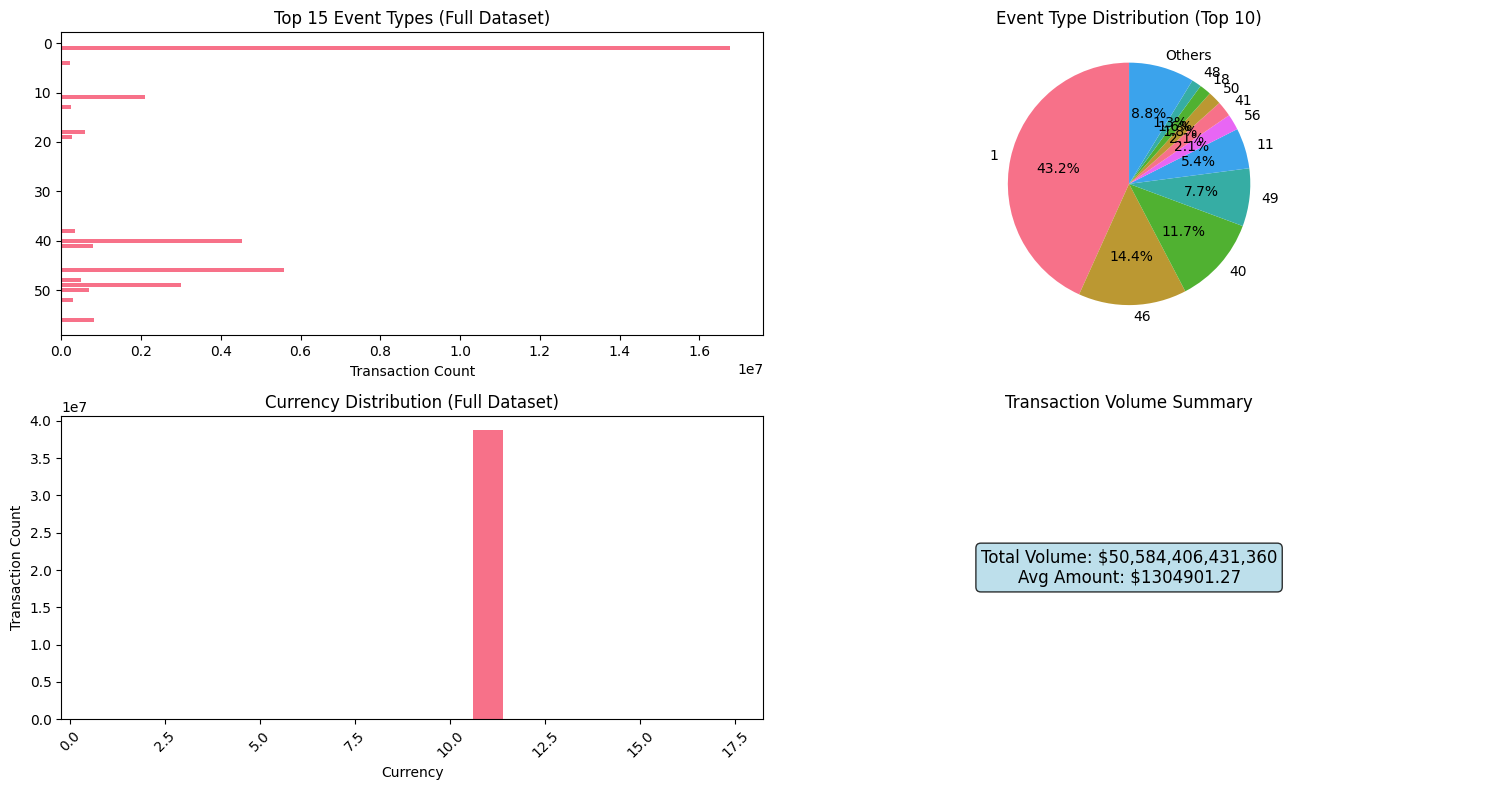

✓ Comprehensive visualizations created

=== COMPREHENSIVE ANALYSIS SUMMARY ===
✓ Processed 38,764,930 transactions across 400 files
✓ Analyzed 55 event types
✓ Analyzed 131 currencies
✓ Total transaction volume: $50,584,406,431,360.00
✓ Complete dataset insights generated


In [58]:
# Full-data Visualizations (streaming, no sampling)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from collections import defaultdict

plt.style.use('default')
sns.set_palette('husl')

print('=== FULL-DATA VISUALIZATIONS (NO SAMPLING) ===')

# Discover files
if 'fold_dirs' not in globals() or not fold_dirs:
    fold_dirs = sorted([p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith('fold=')], key=lambda p: p.name)
all_files = [f for d in fold_dirs for f in sorted(d.glob('*.parquet'))]

if not all_files:
    print('No parquet files found.')
else:
    print(f'Processing {len(all_files)} files for comprehensive analysis...')
    
    # Global aggregators for full dataset analysis
    event_type_counts = defaultdict(int)
    currency_counts = defaultdict(int)
    amount_stats = {'sum': 0, 'count': 0, 'min': float('inf'), 'max': 0}
    total_rows = 0
    
    # Process all files for comprehensive analysis
    for i, f in enumerate(all_files):
        if i % 100 == 0:
            print(f'  Processed {i}/{len(all_files)} files...')
            
        try:
            pf = pq.ParquetFile(str(f))
            # Read key columns for aggregation
            table = pf.read(columns=['event_type', 'currency', 'amount'])
            
            if table.num_rows > 0:
                df_full = table.to_pandas()
                
                # Aggregate event types
                for event_type in df_full['event_type']:
                    event_type_counts[event_type] += 1
                
                # Aggregate currencies
                for currency in df_full['currency']:
                    currency_counts[currency] += 1
                
                # Aggregate amount statistics
                amounts = df_full['amount'].dropna()
                if len(amounts) > 0:
                    amount_stats['sum'] += amounts.sum()
                    amount_stats['count'] += len(amounts)
                    amount_stats['min'] = min(amount_stats['min'], amounts.min())
                    amount_stats['max'] = max(amount_stats['max'], amounts.max())
                
                total_rows += len(df_full)
                
        except Exception as e:
            print(f'  Warning: Failed to process {f.name}: {e}')
            continue
    
    # Display comprehensive results
    print(f'\n=== COMPREHENSIVE DATASET ANALYSIS ===')
    print(f'Total transactions processed: {total_rows:,}')
    print(f'Total unique event types: {len(event_type_counts)}')
    print(f'Total unique currencies: {len(currency_counts)}')
    
    if amount_stats['count'] > 0:
        avg_amount = amount_stats['sum'] / amount_stats['count']
        print(f'Total transaction volume: ${amount_stats["sum"]:,.2f}')
        print(f'Average transaction amount: ${avg_amount:.2f}')
        print(f'Amount range: ${amount_stats["min"]:.2f} - ${amount_stats["max"]:.2f}')
    
    # Top event types
    print(f'\n=== TOP EVENT TYPES ===')
    top_events = sorted(event_type_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    for event_type, count in top_events:
        percentage = (count / total_rows) * 100
        print(f'{event_type:20}: {count:8,} ({percentage:5.1f}%)')
    
    # Top currencies
    print(f'\n=== TOP CURRENCIES ===')
    top_currencies = sorted(currency_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    for currency, count in top_currencies:
        percentage = (count / total_rows) * 100
        print(f'{currency:10}: {count:8,} ({percentage:5.1f}%)')
    
    # Create comprehensive visualizations
    print(f'\n=== CREATING COMPREHENSIVE VISUALIZATIONS ===')
    
    # Event type distribution
    if event_type_counts:
        plt.figure(figsize=(15, 8))
        
        # Top 15 event types
        top_15_events = dict(sorted(event_type_counts.items(), key=lambda x: x[1], reverse=True)[:15])
        
        plt.subplot(2, 2, 1)
        events = list(top_15_events.keys())
        counts = list(top_15_events.values())
        plt.barh(events, counts)
        plt.title('Top 15 Event Types (Full Dataset)')
        plt.xlabel('Transaction Count')
        plt.gca().invert_yaxis()
        
        # Event type pie chart (top 10)
        plt.subplot(2, 2, 2)
        top_10_events = dict(sorted(event_type_counts.items(), key=lambda x: x[1], reverse=True)[:10])
        others_count = sum(event_type_counts.values()) - sum(top_10_events.values())
        if others_count > 0:
            top_10_events['Others'] = others_count
        
        plt.pie(top_10_events.values(), labels=top_10_events.keys(), autopct='%1.1f%%', startangle=90)
        plt.title('Event Type Distribution (Top 10)')
        
        # Currency distribution
        plt.subplot(2, 2, 3)
        currencies = list(currency_counts.keys())
        currency_counts_list = list(currency_counts.values())
        plt.bar(currencies, currency_counts_list)
        plt.title('Currency Distribution (Full Dataset)')
        plt.xlabel('Currency')
        plt.ylabel('Transaction Count')
        plt.xticks(rotation=45)
        
        # Transaction volume by event type (if we have amount data)
        if amount_stats['count'] > 0:
            plt.subplot(2, 2, 4)
            # This would require more complex aggregation, showing placeholder
            plt.text(0.5, 0.5, f'Total Volume: ${amount_stats["sum"]:,.0f}\nAvg Amount: ${avg_amount:.2f}', 
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
            plt.title('Transaction Volume Summary')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f'✓ Comprehensive visualizations created')
    
    print(f'\n=== COMPREHENSIVE ANALYSIS SUMMARY ===')
    print(f'✓ Processed {total_rows:,} transactions across {len(all_files)} files')
    print(f'✓ Analyzed {len(event_type_counts)} event types')
    print(f'✓ Analyzed {len(currency_counts)} currencies')
    print(f'✓ Total transaction volume: ${amount_stats["sum"]:,.2f}')
    print(f'✓ Complete dataset insights generated')
